# Consumer purchasing behaviors, consumer groups, changes and COVID


Metrics per user:
- total spend
- number of distinct products purchased
- purchase frequency: purchase days per month


Data restrictions:
- drop GC purchases
- users with data in both 2018 and 2022
- data beyond 10-2022 excluded -- data collection began 11-2022


In [1]:
from datetime import date, datetime
import math

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr

# For Amazon data, make easier to access col names by defining here
RESPONSE_ID = 'Survey ResponseID'
DATE = 'Order Date'
UNIT_PRICE = 'Purchase Price Per Unit'
QUANTITY = 'Quantity'
STATE = 'Shipping Address State'
TITLE = 'Title'
PRODUCT_CODE = 'ASIN/ISBN (Product Code)'
CATEGORY = 'Category'

# Additional / added columns
TOTAL_SPEND = 'spend' # unit price x quantity
YEAR = 'year'
MONTH = 'month'
QUARTER = 'quarter'
YEAR_Q = 'year-Q'
YYYY_MM = 'yyyy-mm'

IS_GIFT_CARD = 'gift card'

## Read in Amazon data


In [2]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_data = pd.read_csv(amzn_data_fpath, parse_dates=['Order Date'])
# add date columns for analysis convenience
amzn_data[YEAR] = amzn_data[DATE].apply(lambda d: d.year)
amzn_data[YYYY_MM] = amzn_data[DATE].apply(lambda d: date.strftime(d, '%Y-%m'))
amzn_data[MONTH] = amzn_data[DATE].apply(lambda d: d.month)
# quarters: map months to quarters as month 1-3: 1, 4-6: 2, 7-9: 3, 10-12: 4, 13-15: 5, etc
amzn_data[QUARTER] = amzn_data[MONTH].apply(lambda m: math.ceil(m/3))
amzn_data[YEAR_Q] = amzn_data.apply(lambda row: '%s-Q%s' % (row[YEAR], row[QUARTER]), axis=1)
# amzn_data[YEAR_Q] = amzn_data.apply(lambda row: '%s-Q%s' % (row[YEAR], math.ceil(row[MONTH]/3)), axis=1)
amzn_data[TOTAL_SPEND] = amzn_data.apply(lambda row: row[UNIT_PRICE]*row[QUANTITY], axis=1)
# peek at it:
amzn_data.head(3)

Order Date  Purchase Price Per Unit  Quantity Shipping Address State   
0 2018-12-04                     7.98       1.0                     NJ  \
1 2018-12-22                    13.99       1.0                     NJ   
2 2018-12-24                     8.99       1.0                     NJ   

                                               Title ASIN/ISBN (Product Code)   
0  SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...               B0143RTB1E  \
1  Betron BS10 Earphones Wired Headphones in Ear ...               B01MA1MJ6H   
2                                                NaN               B078JZTFN3   

       Category  Survey ResponseID  year  yyyy-mm  month  quarter   year-Q   
0  FLASH_MEMORY  R_01vNIayewjIIKMF  2018  2018-12     12        4  2018-Q4  \
1    HEADPHONES  R_01vNIayewjIIKMF  2018  2018-12     12        4  2018-Q4   
2           NaN  R_01vNIayewjIIKMF  2018  2018-12     12        4  2018-Q4   

   spend  
0   7.98  
1  13.99  
2   8.99

In [3]:
def print_amazon_data_metrics(df):
    print('%s purchases' % len(df))
    print('%s product codes' % df[PRODUCT_CODE].nunique())
    print('%s categories' % df[CATEGORY].nunique())
    print('%s response Ids' % df[RESPONSE_ID].nunique())
    
print_amazon_data_metrics(amzn_data)

1850717 purchases
939082 product codes
1871 categories
5027 response Ids


## Amazon Data preprocessing

### Data restrictions
Limit data to:
- remove gift cards (GCs)
- purchases before 2022-11
- response ids that appear in both 2018 and 2022

#### Note: This means we are measuring growth WITHIN our sample
- additional growth can be attributed by growth in number of users


#### Handle gift cards

There are multiple category names for gift cards.

Find them and drop them.
It might be tempting to analyze growth of GC use, but keep in mind we crowdsourced data from internet workers -- their GC use is likely not representative.

In [4]:
def is_gift_code(row):
    cat = str(row['Category'])
    if cat in ['GIFT_CARD']:
        return True
    title = str(row['Title']).lower()
    if ('gift code' in title) or ('gift card' in title) or ('digital code' in title):
        return True
    if ('amazon reload' in title):
        return True
    return False

amzn_data[IS_GIFT_CARD] = amzn_data.apply(is_gift_code, axis=1)
gc_data = amzn_data[amzn_data[IS_GIFT_CARD]]
gc_pcodes = gc_data[PRODUCT_CODE].unique()
print('%s gift card purchases from %s users with %s different product codes and %s distinct categories' % 
      (len(gc_data), gc_data[RESPONSE_ID].nunique(), len(gc_pcodes), gc_data[CATEGORY].nunique()))
# gc_data.head(3)

43060 gift card purchases from 3220 users with 2203 different product codes and 77 distinct categories


In [5]:
# drop the gift cards
print('Dropping all gift cards purchases.')
amzn_data = amzn_data[amzn_data[IS_GIFT_CARD]==False]
print_amazon_data_metrics(amzn_data)

Dropping all gift cards purchases.
1807657 purchases
936894 product codes
1863 categories
5026 response Ids


In [6]:
# Limit data to purchases before 2022-11
print('limiting data to purchases before 2022-11')
amzn_data = amzn_data[amzn_data[YYYY_MM] < '2022-11']
print_amazon_data_metrics(amzn_data)
# amzn_data.sort_values(DATE, ascending=False).head(3)

limiting data to purchases before 2022-11
1696690 purchases
886248 product codes
1862 categories
5014 response Ids


In [7]:
# Limit data to response ids in both 2018 and 2022
print('Limiting data to users (response ids) consistently in 2018 and 2022')
rids2018 = amzn_data[amzn_data[YEAR]==2018][RESPONSE_ID].unique()
rids2022 = amzn_data[amzn_data[YEAR]==2022][RESPONSE_ID].unique()
rids = list(set(rids2018).intersection(set(rids2022)))
amzn_data = amzn_data[amzn_data[RESPONSE_ID].isin(rids)]
print_amazon_data_metrics(amzn_data)

Limiting data to users (response ids) consistently in 2018 and 2022
1594055 purchases
842340 product codes
1838 categories
4115 response Ids


In [8]:
print('FYI there are %s users with null product codes in 2018' % amzn_data[
    (amzn_data[YEAR]==2018) & (amzn_data[PRODUCT_CODE].isna())][RESPONSE_ID].nunique())

FYI there are 4 users with null product codes in 2018


### Amazon prime day

Get the dates for Amazon prime day, as this impact purchases

In [9]:
amzn_prime_ms = [
    '2018-07',
    '2019-07',
    '2020-10',
    '2021-06',
    '2022-07',
]

In [10]:
years = [2018, 2019, 2020, 2021, 2022]

In [11]:
yyyy_mm_idx = sorted(list(amzn_data['yyyy-mm'].unique()))

In [12]:
ym_to_qs_idx = pd.Series([
    '2018-Q1',
    '2018-Q2',
    '2018-Q3',
    '2018-Q4',
    '2019-Q1',
    '2019-Q2',
    '2019-Q3',
    '2019-Q4',
    '2020-Q1',
    '2020-Q2',
    '2020-Q3',
    '2020-Q4',
    '2021-Q1',
    '2021-Q2',
    '2021-Q3',
    '2021-Q4',
    '2022-Q1',
    '2022-Q2',
    '2022-Q3'
], index=[ym for ym in yyyy_mm_idx if ym.split('-')[1] in ['02', '05','08','11']])
ym_to_qs_idx.head()

2018-02    2018-Q1
2018-05    2018-Q2
2018-08    2018-Q3
2018-11    2018-Q4
2019-02    2019-Q1
dtype: object

## Amazon quarterly earnings data

Amazon releases quarterly earnings results. Data are available at https://ir.aboutamazon.com/quarterly-results/default.aspx. 


I compiled data for the North America Segment net sales for each quarter from 2018 Q1 to 2022 Q4 in a spreadsheet here: https://docs.google.com/spreadsheets/d/1ho73vQHHlzJaq9MM63oLCtvtp09p9cqfyGJzmbfpfv8/edit#gid=250251799

In [13]:
# below is copied from the quarterly sales data (see spreadsheet)
# in billions ($)
amzn_quarterly_sales = """30.730
32.170
34.350
44.124
35.812
38.653
42.638
53.670
46.127
55.436
59.373
75.346
64.366
67.550
65.557
82.360
69.244
74.430
78.843""".split('\n') # for 2022-Q4 would include 93.363 as the last element
amzn_quarterly_sales = pd.Series(amzn_quarterly_sales, index=ym_to_qs_idx.values).astype(float)

In [14]:
amzn_sales = amzn_quarterly_sales.rename('Amazon net sales').to_frame()
amzn_sales[YYYY_MM] = amzn_sales.index.map(ym_to_qs_idx.rename('Q').reset_index().set_index('Q')['index'])
amzn_sales = amzn_sales.reset_index().rename(columns={'index':YEAR_Q}).set_index(YYYY_MM)
# amzn_sales = amzn_sales.reindex(yyyy_mm_idx)
amzn_sales.head()

year-Q  Amazon net sales
yyyy-mm                           
2018-02  2018-Q1            30.730
2018-05  2018-Q2            32.170
2018-08  2018-Q3            34.350
2018-11  2018-Q4            44.124
2019-02  2019-Q1            35.812

Get the total Amazon sample metrics

In [15]:
total_spend_m = amzn_data.groupby(YYYY_MM)[TOTAL_SPEND].sum()
total_spend_q = amzn_data.groupby(YEAR_Q)[TOTAL_SPEND].sum().to_frame()
# limit metrics to 2022-Q3 and earlier
total_spend_q = total_spend_q[total_spend_q.index < '2022-Q4']
# set up yyyy-mm as index for q metrics
total_spend_q[YYYY_MM] = total_spend_q.index.map(ym_to_qs_idx.rename('Q').reset_index().set_index('Q')['index'])
total_spend_q = total_spend_q.reset_index().set_index(YYYY_MM)
total_spend_q.head()

year-Q       spend
yyyy-mm                     
2018-02  2018-Q1  1169006.37
2018-05  2018-Q2  1139010.35
2018-08  2018-Q3  1320391.31
2018-11  2018-Q4  1625228.46
2019-02  2019-Q1  1268073.48

In [16]:
# total distinct products purchased per user each month, summed over users
total_distinct_products_m = amzn_data.groupby(YYYY_MM)[PRODUCT_CODE].nunique()
# total_distinct_products_m = amzn_data.groupby(
#     [YYYY_MM, RESPONSE_ID]
# )[PRODUCT_CODE].nunique().reset_index().groupby(YYYY_MM)[PRODUCT_CODE].sum()
total_distinct_products_m.head(3)

yyyy-mm
2018-01    16304
2018-02    14162
2018-03    15445
Name: ASIN/ISBN (Product Code), dtype: int64

In [17]:
# Total month days of purchases per user, summed over users
total_user_purchase_days_m = amzn_data.groupby(
    [YYYY_MM, RESPONSE_ID]
)[DATE].nunique().reset_index().groupby(YYYY_MM)[DATE].sum()
total_user_purchase_days_m.head()

yyyy-mm
2018-01    8331
2018-02    7260
2018-03    7882
2018-04    7472
2018-05    7955
Name: Order Date, dtype: int64

#### Correlation between sample data and Amazon data

In [18]:
print('Pearson r=%0.3f (p=%0.3f)' % 
      pearsonr(total_spend_q['spend'], amzn_sales['Amazon net sales']))

Pearson r=0.976 (p=0.000)


In [19]:
amzn_color = 'blue'

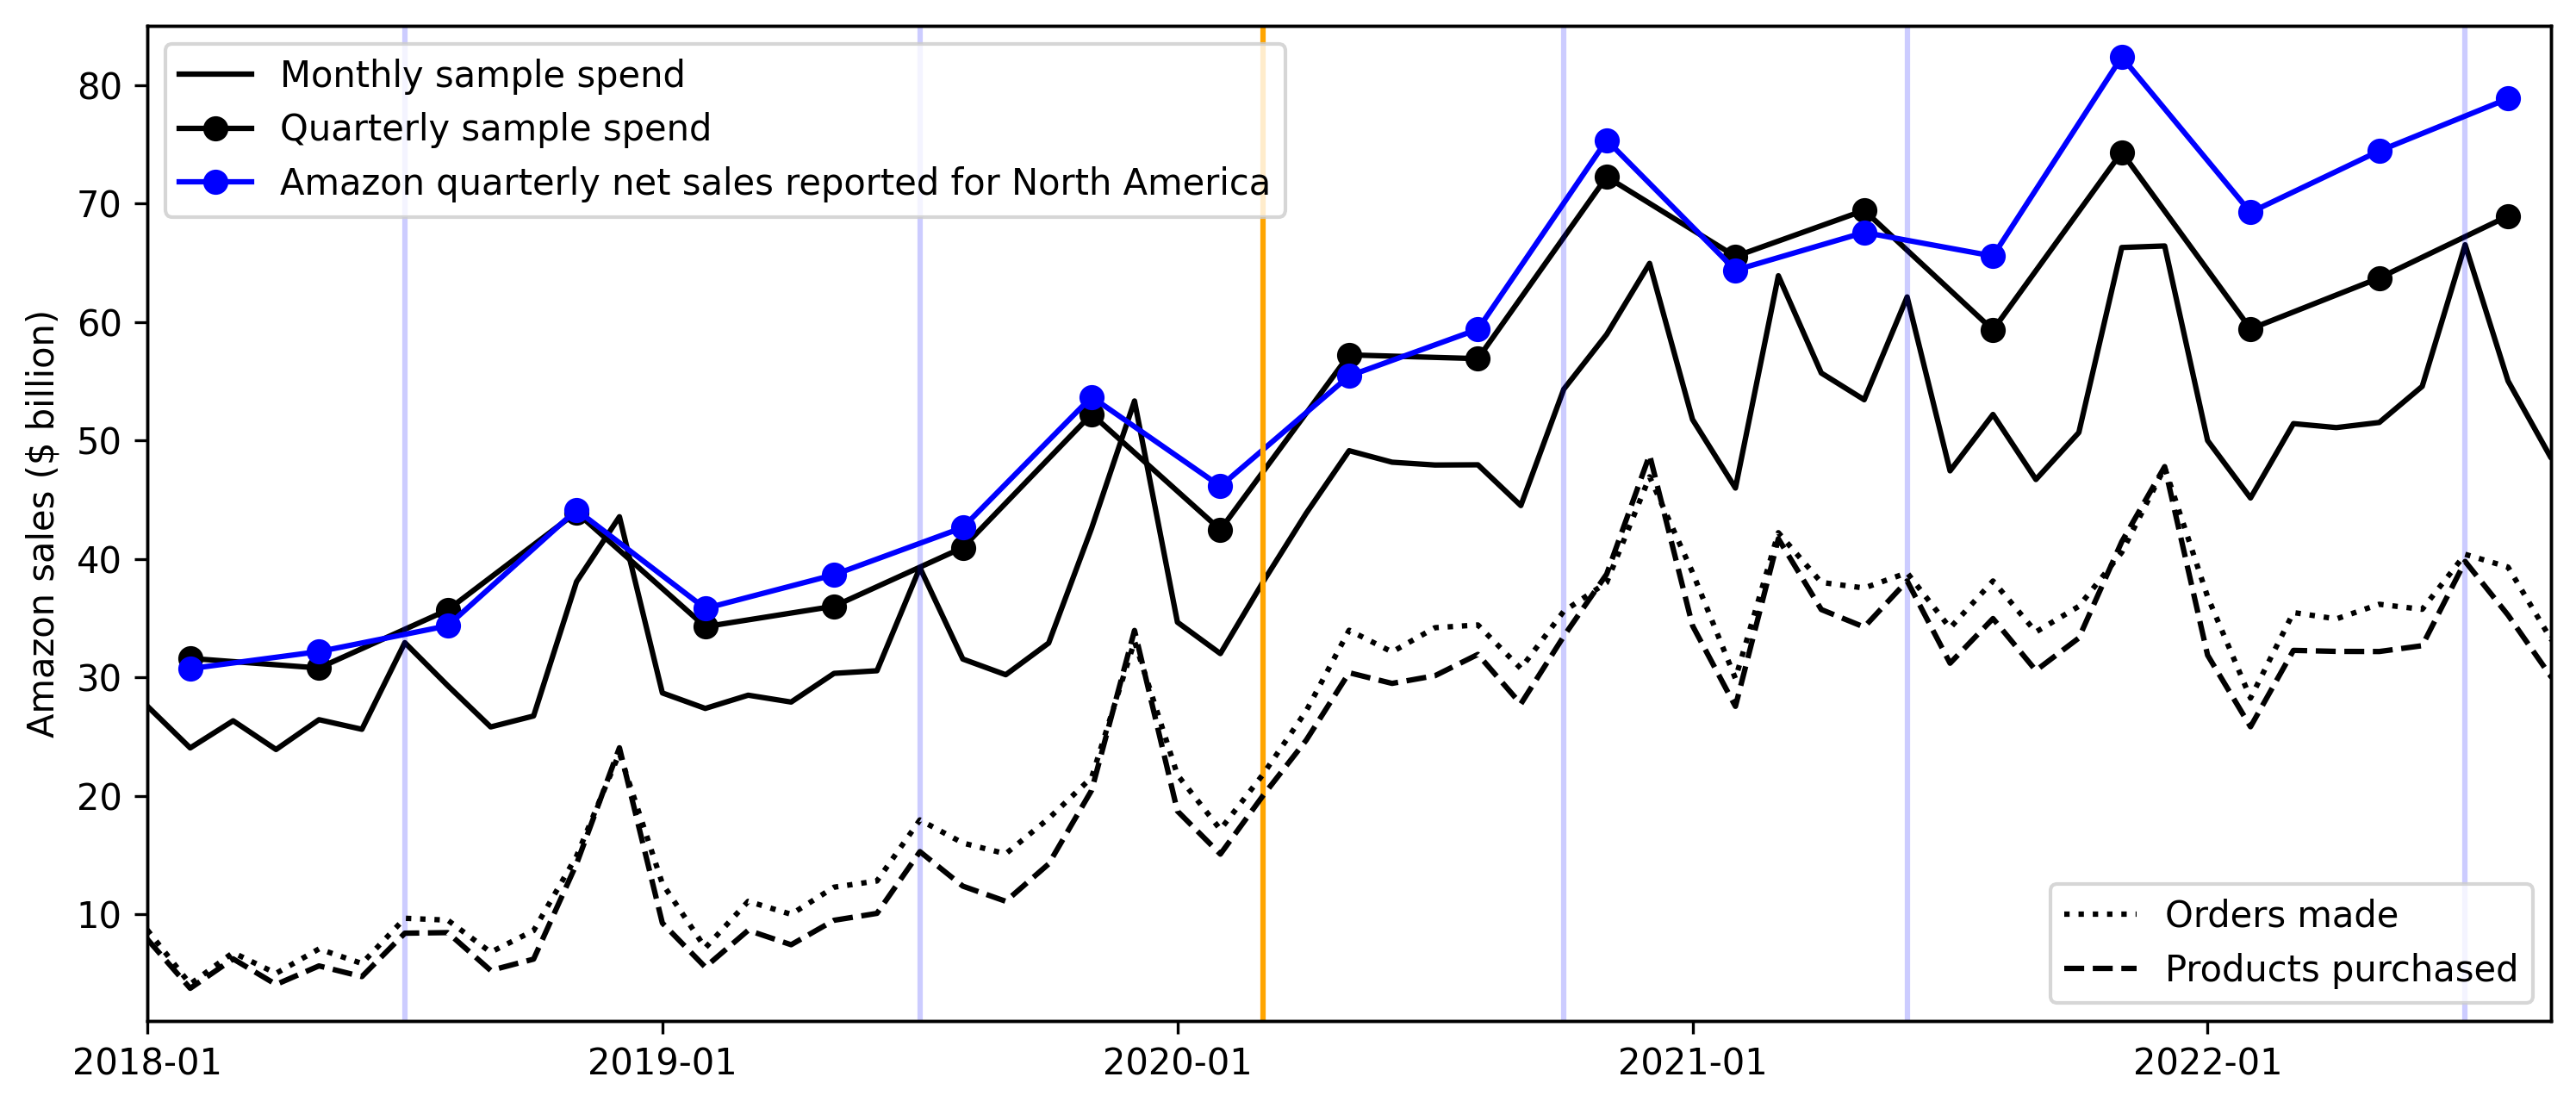

In [71]:
fig, ax1 = plt.subplots(1,1,figsize=(12,5), dpi=300)
ax1.plot(
    (total_spend_m/15000), label='Monthly sample spend',
    linestyle='-', color='black'
)
ax1.plot(
    (total_spend_q['spend']/37000), label='Quarterly sample spend',
    linestyle='-', color='black', marker='o'
)
ax1.set_xlim('2018-01', '2022-09')
ax1.set_xticks(['2018-01','2019-01','2020-01','2021-01','2022-01'])
ax1.plot(amzn_sales['Amazon net sales'].index, amzn_sales['Amazon net sales'], 
             linestyle='-', marker='o',
             color='blue', label='Amazon quarterly net sales reported for North America')
_ = ax1.set_ylabel('Amazon sales ($ billion)')
_ = ax1.legend()

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.plot(total_user_purchase_days_m, color='black', linestyle=':', label='Orders made')
ax3.plot(total_distinct_products_m, color='black', linestyle='--', label='Products purchased')

ax2.set_yticks([])
ax3.set_yticks([])
_ = ax2.legend(handles=[ax2.get_lines()[0], ax3.get_lines()[0]], loc='lower right')

# shift things up
ax1.set_ylim(1, 85)
ax2.set_ylim(total_user_purchase_days_m.min() - 0.1*total_user_purchase_days_m.min(), 1.5*total_user_purchase_days_m.max())
ax3.set_ylim(total_distinct_products_m.min() - 0.1*total_distinct_products_m.min(), 1.5*total_distinct_products_m.max())
# show prime days
[ax1.axvline(x=m, ymin=0, color=amzn_color, alpha=0.2, linestyle='-') for m in amzn_prime_ms]
# plot COVID
_ = ax1.axvline(x='2020-03', ymin=0, color='orange', linestyle='-')

## Check metrics without groceries

Amazon pushed their grocery business. Do groceries play an outsized role in our sample metrics?

Compute the total metrics without grocery related purchases.

In [21]:
grocery_cats = [
    'GROCERY', 'FOOD', 'VEGETABLE', 'FRUIT', 'DAIRY_BASED_CHEESE', 'BREAD', 'POULTRY', 
    'DRINK_FLAVORED', 'SNACK_CHIP_AND_CRISP', 
    'HERB', 'MEAT', 'FRUIT_SNACK', 'SAUCE', 'NUT_AND_SEED', 'SNACK_MIX', 'WATER', 
    'DAIRY_BASED_CREAM', 'NOODLE', 'PUFFED_SNACK', 'PACKAGED_SOUP_AND_STEW', 
    'MILK_SUBSTITUTE', 'CRACKER', 'COOKIE', 'SUGAR_CANDY', 'SYRUP', 'DAIRY_BASED_BUTTER', 
    'BREAKFAST_CEREAL', 'COFFEE', 'TEA', 'SNACK_FOOD_BAR', 'POPCORN', 'LEAVENING_AGENT', 
    'Grocery', 'DAIRY_BASED_YOGURT', 'CHOCOLATE_CANDY', 'EDIBLE_OIL_VEGETABLE', 
    'JUICE_AND_JUICE_DRINK', 'SEASONING', 'CAKE', 'DAIRY_BASED_ICE_CREAM', 
    'DAIRY_BASED_DRINK', 'CONDIMENT', 'LEGUME', 'RICE_MIX', 
    'CHEWING_GUM', 'FISH', 'CULINARY_SALT', 'SUGAR', 'NUTRITIONAL_SUPPLEMENT', 
    'NUT_BUTTER', 'PASTRY', 'THICKENING_AGENT', 'CEREAL', 'BAKING_MIX', 'SALAD_DRESSING', 
    'HERBAL_SUPPLEMENT'
]

In [22]:
print('Amazon data without grocery related purchases:')
amzn_data_wout_groc = amzn_data[~amzn_data[CATEGORY].isin(grocery_cats)]
print_amazon_data_metrics(amzn_data_wout_groc)

Amazon data without grocery related purchases:
1390065 purchases
789522 product codes
1783 categories
4115 response Ids


In [23]:
total_spend_wout_groc_m = amzn_data_wout_groc.groupby(YYYY_MM)[TOTAL_SPEND].sum()
# total distinct products purchased per user each month, summed over users
total_distinct_products_wout_groc_m = amzn_data_wout_groc.groupby(YYYY_MM)[PRODUCT_CODE].nunique()
# total_distinct_products_m = amzn_data.groupby(
#     [YYYY_MM, RESPONSE_ID]
# )[PRODUCT_CODE].nunique().reset_index().groupby(YYYY_MM)[PRODUCT_CODE].sum()
# Total month days of purchases per user, summed over users
total_user_purchase_days_wout_groc_m = amzn_data_wout_groc.groupby(
    [YYYY_MM, RESPONSE_ID]
)[DATE].nunique().reset_index().groupby(YYYY_MM)[DATE].sum()
total_user_purchase_days_wout_groc_m.head()

yyyy-mm
2018-01    8027
2018-02    6919
2018-03    7577
2018-04    7167
2018-05    7659
Name: Order Date, dtype: int64

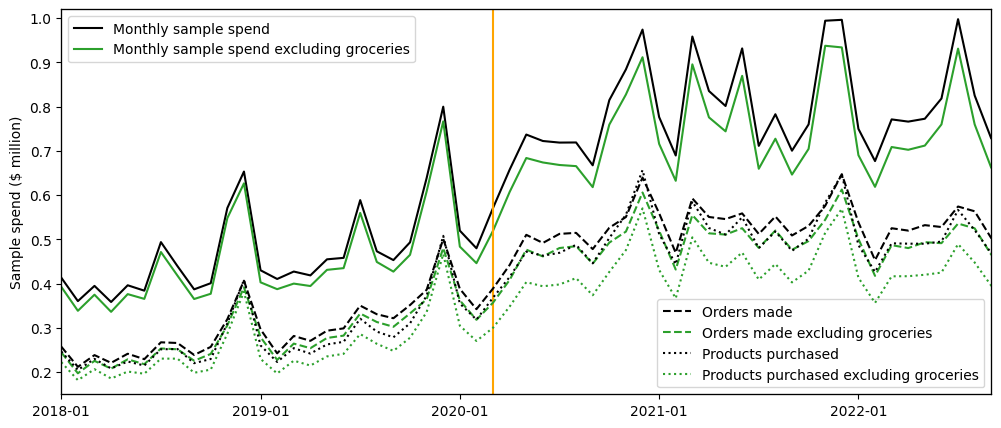

In [24]:
wout_groc_color = 'tab:green'

fig, ax1 = plt.subplots(1,1,figsize=(12, 5))#, dpi=300)
ax1.plot(
    (total_spend_m/1000000), label='Monthly sample spend',
    linestyle='-', color='black'
)
ax1.plot(
    (total_spend_wout_groc_m/1000000), label='Monthly sample spend excluding groceries',
    linestyle='-', color=wout_groc_color
)
ax1.set_xlim('2018-01', '2022-09')
ax1.set_xticks(['2018-01','2019-01','2020-01','2021-01','2022-01'])
_ = ax1.set_ylabel('Sample spend ($ million)')
_ = ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.plot(total_user_purchase_days_m, 
         color='black', linestyle='--', label='Orders made')
ax2.plot(total_user_purchase_days_wout_groc_m, 
         color=wout_groc_color, linestyle='--', label='Orders made excluding groceries')
ax3.plot(total_distinct_products_m, 
         color='black', linestyle=':', label='Products purchased')
ax3.plot(total_distinct_products_wout_groc_m, 
         color=wout_groc_color, linestyle=':', label='Products purchased excluding groceries')
ax2.set_yticks([])
ax3.set_yticks([])
_ = ax2.legend(
    handles=[ax2.get_lines()[0],ax2.get_lines()[1], ax3.get_lines()[0], ax3.get_lines()[1]], 
    loc='lower right'
)
# # shift things up
ax1.set_ylim(0.15, 1.02)
ax2.set_ylim(total_user_purchase_days_m.min() - 0.2*total_user_purchase_days_m.min(), 1.5*total_user_purchase_days_m.max())
ax3.set_ylim(total_distinct_products_m.min() - 0.2*total_distinct_products_m.min(), 1.5*total_distinct_products_m.max())
# show prime days
# [ax1.axvline(x=m, ymin=0, color=amzn_color, alpha=0.2, linestyle='-') for m in amzn_prime_ms]
# plot COVID
_ = ax1.axvline(x='2020-03', ymin=0, color='orange', linestyle='-')

In [25]:
# Compute the correlation between the emtrics computed with and without groceries.
print('Sample spend')
print('Pearson r=%0.3f (p=%0.3f)' % pearsonr(total_spend_m, total_spend_wout_groc_m))
print('Orders made')
print('Pearson r=%0.3f (p=%0.3f)' % pearsonr(total_user_purchase_days_m, 
                                             total_user_purchase_days_wout_groc_m))
print('Products purchased')
print('Pearson r=%0.3f (p=%0.3f)' % pearsonr(total_distinct_products_m, 
                                             total_distinct_products_wout_groc_m))

Sample spend
Pearson r=0.999 (p=0.000)
Orders made
Pearson r=0.999 (p=0.000)
Products purchased
Pearson r=0.996 (p=0.000)


## Survey data setup

Process survey data to connect with purchases.

In [26]:
# only inspect the fields related to demographics of interest for this notebook
demo_fields = [
    RESPONSE_ID,
    'Q-demos-age', 
    'Q-demos-hispanic', 'Q-demos-race',
    'Q-demos-education', 
    'Q-demos-income', 
    'Q-demos-gender',
    'Q-demos-state',
    'Q-amazon-use-hh-size',
    'Q-life-changes',
    'Q-personal-wheelchair',
]
# Here are the fields
fields_df = pd.read_csv('../data/survey-data/fields.pub.csv', index_col=0).loc[demo_fields]
fields_df

fields
Survey ResponseID                                            Response ID
Q-demos-age                                      What is your age group?
Q-demos-hispanic         Are you of Spanish, Hispanic, or Latino origin?
Q-demos-race           Choose one or more races that you consider you...
Q-demos-education      What is the highest level of education you hav...
Q-demos-income         What was your total household income before ta...
Q-demos-gender                             How do you describe yourself?
Q-demos-state                            50 States, D.C. and Puerto Rico
Q-amazon-use-hh-size            How many people are in your "household"?
Q-life-changes         In 2021 did you, or someone you share your Ama...
Q-personal-wheelchair  Are any of the following the case for:\n\nYou ...

In [27]:
# Read in survey data and keep only the columns to be used below
# Want ResponseId, state, and demographic data used to compare purchase behaviors and stratify
survey_data_fpath = '../data/survey-data/survey.pub.csv'
survey_df = pd.read_csv(survey_data_fpath,  usecols=demo_fields).set_index(RESPONSE_ID)
# Only include data for rids
survey_df = survey_df.loc[rids]
display(survey_df.head(3))

Q-demos-age Q-demos-hispanic        Q-demos-race   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN  25 - 34 years               No  White or Caucasian  \
R_10TA7pCDmelHi5H  55 - 64 years               No  White or Caucasian   
R_2aaw2bhbdPwHa1w  45 - 54 years               No  White or Caucasian   

                            Q-demos-education     Q-demos-income   
Survey ResponseID                                                  
R_3nH1Odp9Yjm86gN  High school diploma or GED  $25,000 - $49,999  \
R_10TA7pCDmelHi5H           Bachelor's degree   $150,000 or more   
R_2aaw2bhbdPwHa1w           Bachelor's degree  Less than $25,000   

                  Q-demos-gender  Q-demos-state Q-amazon-use-hh-size   
Survey ResponseID                                                      
R_3nH1Odp9Yjm86gN           Male        Alabama                   4+  \
R_10TA7pCDmelHi5H           Male         Oregon                    3   
R_2aaw2bhbdPwHa1w         Female  West Virginia                   4+   

                  Q-personal-wheelchair Q-life-changes  
Survey ResponseID                                       
R_3nH1Odp9Yjm86gN                    No    Had a child  
R_10TA7pCDmelHi5H                    No            NaN  
R_2aaw2bhbdPwHa1w                    No    Lost a job

In [28]:
collapse_age_map = {
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 and older',
    '65 and older': '55 and older',
}
collapse_income_map = {
    'Less than $25,000': 'Less than $50,000', 
    '$25,000 - $49,999': 'Less than $50,000', 
    '$50,000 - $74,999': '\$50,000 - \$99,999',
    '$75,000 - $99,999': '\$50,000 - \$99,999',
    '$100,000 - $149,999': '$100,000 or more',
    '$150,000 or more': '$100,000 or more',
}
survey_df['Age3'] = survey_df['Q-demos-age'].map(collapse_age_map)
survey_df = survey_df.rename(columns={'Q-demos-age': 'Age6'})
# effectively drops 'income': prefer not to say
survey_df['Income3'] = survey_df['Q-demos-income'].map(collapse_income_map)
survey_df['Income6'] = survey_df['Q-demos-income'].apply(lambda i: np.nan if i=='Prefer not to say' else i)
survey_df.head(3)

Age6 Q-demos-hispanic        Q-demos-race   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN  25 - 34 years               No  White or Caucasian  \
R_10TA7pCDmelHi5H  55 - 64 years               No  White or Caucasian   
R_2aaw2bhbdPwHa1w  45 - 54 years               No  White or Caucasian   

                            Q-demos-education     Q-demos-income   
Survey ResponseID                                                  
R_3nH1Odp9Yjm86gN  High school diploma or GED  $25,000 - $49,999  \
R_10TA7pCDmelHi5H           Bachelor's degree   $150,000 or more   
R_2aaw2bhbdPwHa1w           Bachelor's degree  Less than $25,000   

                  Q-demos-gender  Q-demos-state Q-amazon-use-hh-size   
Survey ResponseID                                                      
R_3nH1Odp9Yjm86gN           Male        Alabama                   4+  \
R_10TA7pCDmelHi5H           Male         Oregon                    3   
R_2aaw2bhbdPwHa1w         Female  West Virginia                   4+   

                  Q-personal-wheelchair Q-life-changes           Age3   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN                    No    Had a child  18 - 34 years  \
R_10TA7pCDmelHi5H                    No            NaN   55 and older   
R_2aaw2bhbdPwHa1w                    No    Lost a job   35 - 54 years   

                             Income3            Income6  
Survey ResponseID                                        
R_3nH1Odp9Yjm86gN  Less than $50,000  $25,000 - $49,999  
R_10TA7pCDmelHi5H   $100,000 or more   $150,000 or more  
R_2aaw2bhbdPwHa1w  Less than $50,000  Less than $25,000

Handle race: Add a column indicating whether someone is in each race

- White
- Black
- Asian
- Other or Native Hawaiian or Other Pacific Islander or American Indian/Native American or Alaska Native

Note: A respondent can be of multiple races


In [29]:
is_white = lambda r: 'White or Caucasian' in str(r)
is_black = lambda r: 'Black or African American' in str(r)
is_asian = lambda r: 'Asian' in str(r)
other_races = [
    'Other',
    'American Indian/Native American or Alaska Native',
    'Native Hawaiian or Other Pacific Islander'
]
is_other = lambda r: any([o in str(r) for o in other_races])
survey_df['White'] = survey_df['Q-demos-race'].apply(is_white)
survey_df['Asian'] = survey_df['Q-demos-race'].apply(is_asian)
survey_df['Black'] = survey_df['Q-demos-race'].apply(is_black)
survey_df['Other'] = survey_df['Q-demos-race'].apply(is_other)
survey_df.head(3)

Age6 Q-demos-hispanic        Q-demos-race   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN  25 - 34 years               No  White or Caucasian  \
R_10TA7pCDmelHi5H  55 - 64 years               No  White or Caucasian   
R_2aaw2bhbdPwHa1w  45 - 54 years               No  White or Caucasian   

                            Q-demos-education     Q-demos-income   
Survey ResponseID                                                  
R_3nH1Odp9Yjm86gN  High school diploma or GED  $25,000 - $49,999  \
R_10TA7pCDmelHi5H           Bachelor's degree   $150,000 or more   
R_2aaw2bhbdPwHa1w           Bachelor's degree  Less than $25,000   

                  Q-demos-gender  Q-demos-state Q-amazon-use-hh-size   
Survey ResponseID                                                      
R_3nH1Odp9Yjm86gN           Male        Alabama                   4+  \
R_10TA7pCDmelHi5H           Male         Oregon                    3   
R_2aaw2bhbdPwHa1w         Female  West Virginia                   4+   

                  Q-personal-wheelchair Q-life-changes           Age3   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN                    No    Had a child  18 - 34 years  \
R_10TA7pCDmelHi5H                    No            NaN   55 and older   
R_2aaw2bhbdPwHa1w                    No    Lost a job   35 - 54 years   

                             Income3            Income6  White  Asian  Black   
Survey ResponseID                                                              
R_3nH1Odp9Yjm86gN  Less than $50,000  $25,000 - $49,999   True  False  False  \
R_10TA7pCDmelHi5H   $100,000 or more   $150,000 or more   True  False  False   
R_2aaw2bhbdPwHa1w  Less than $50,000  Less than $25,000   True  False  False   

                   Other  
Survey ResponseID         
R_3nH1Odp9Yjm86gN  False  
R_10TA7pCDmelHi5H  False  
R_2aaw2bhbdPwHa1w  False

#### Handle life changes: A a column indicating whether someone had each life change

- Lost a job
- Divorce
- Moved place of residence
- Became pregnant
- Had a child

In [30]:
Q = 'Q-life-changes'
print(fields_df.loc[Q][0])
life_changes = [
    'Lost a job',
    'Divorce',
    'Moved place of residence',
    'Became pregnant',
    'Had a child',
]
for lc in life_changes:
    survey_df[lc] = survey_df[Q].apply(lambda q: lc in str(q))
survey_df.head(3)

In 2021 did you, or someone you share your Amazon account with, experience any of the following life changes?

Please mark all that apply.


Age6 Q-demos-hispanic        Q-demos-race   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN  25 - 34 years               No  White or Caucasian  \
R_10TA7pCDmelHi5H  55 - 64 years               No  White or Caucasian   
R_2aaw2bhbdPwHa1w  45 - 54 years               No  White or Caucasian   

                            Q-demos-education     Q-demos-income   
Survey ResponseID                                                  
R_3nH1Odp9Yjm86gN  High school diploma or GED  $25,000 - $49,999  \
R_10TA7pCDmelHi5H           Bachelor's degree   $150,000 or more   
R_2aaw2bhbdPwHa1w           Bachelor's degree  Less than $25,000   

                  Q-demos-gender  Q-demos-state Q-amazon-use-hh-size   
Survey ResponseID                                                      
R_3nH1Odp9Yjm86gN           Male        Alabama                   4+  \
R_10TA7pCDmelHi5H           Male         Oregon                    3   
R_2aaw2bhbdPwHa1w         Female  West Virginia                   4+   

                  Q-personal-wheelchair Q-life-changes  ...   
Survey ResponseID                                       ...   
R_3nH1Odp9Yjm86gN                    No    Had a child  ...  \
R_10TA7pCDmelHi5H                    No            NaN  ...   
R_2aaw2bhbdPwHa1w                    No    Lost a job   ...   

                             Income6 White  Asian  Black  Other  Lost a job   
Survey ResponseID                                                             
R_3nH1Odp9Yjm86gN  $25,000 - $49,999  True  False  False  False       False  \
R_10TA7pCDmelHi5H   $150,000 or more  True  False  False  False       False   
R_2aaw2bhbdPwHa1w  Less than $25,000  True  False  False  False        True   

                   Divorce  Moved place of residence  Became pregnant   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN    False                     False            False  \
R_10TA7pCDmelHi5H    False                     False            False   
R_2aaw2bhbdPwHa1w    False                     False            False   

                   Had a child  
Survey ResponseID               
R_3nH1Odp9Yjm86gN         True  
R_10TA7pCDmelHi5H        False  
R_2aaw2bhbdPwHa1w        False  

[3 rows x 22 columns]

### Handle regional geography: Map 2021 US residential state to region

In [31]:
state_regions_df = pd.read_csv('../data/census/us-census-bureau-regions-and-divisions.csv').set_index('State')
print('Regions:', state_regions_df['Region'].unique())
state_regions_df.head()

Regions: ['West' 'South' 'Northeast' 'Midwest']


State Code Region            Division
State                                           
Alaska             AK   West             Pacific
Alabama            AL  South  East South Central
Arkansas           AR  South  West South Central
Arizona            AZ   West            Mountain
California         CA   West             Pacific

In [32]:
states_to_regions = state_regions_df['Region']
survey_df['Region'] = survey_df['Q-demos-state'].map(states_to_regions)
survey_df.head()

Age6 Q-demos-hispanic        Q-demos-race   
Survey ResponseID                                                       
R_3nH1Odp9Yjm86gN  25 - 34 years               No  White or Caucasian  \
R_10TA7pCDmelHi5H  55 - 64 years               No  White or Caucasian   
R_2aaw2bhbdPwHa1w  45 - 54 years               No  White or Caucasian   
R_1LIJDv6NDuvkCi4  25 - 34 years               No  White or Caucasian   
R_2b2HfsI0sUHFVyL  35 - 44 years               No  White or Caucasian   

                            Q-demos-education       Q-demos-income   
Survey ResponseID                                                    
R_3nH1Odp9Yjm86gN  High school diploma or GED    $25,000 - $49,999  \
R_10TA7pCDmelHi5H           Bachelor's degree     $150,000 or more   
R_2aaw2bhbdPwHa1w           Bachelor's degree    Less than $25,000   
R_1LIJDv6NDuvkCi4           Bachelor's degree    $75,000 - $99,999   
R_2b2HfsI0sUHFVyL           Bachelor's degree  $100,000 - $149,999   

                  Q-demos-gender  Q-demos-state Q-amazon-use-hh-size   
Survey ResponseID                                                      
R_3nH1Odp9Yjm86gN           Male        Alabama                   4+  \
R_10TA7pCDmelHi5H           Male         Oregon                    3   
R_2aaw2bhbdPwHa1w         Female  West Virginia                   4+   
R_1LIJDv6NDuvkCi4         Female       Kentucky                    2   
R_2b2HfsI0sUHFVyL           Male  Massachusetts                   4+   

                  Q-personal-wheelchair Q-life-changes  ... White  Asian   
Survey ResponseID                                       ...                
R_3nH1Odp9Yjm86gN                    No    Had a child  ...  True  False  \
R_10TA7pCDmelHi5H                    No            NaN  ...  True  False   
R_2aaw2bhbdPwHa1w                    No    Lost a job   ...  True  False   
R_1LIJDv6NDuvkCi4                    No            NaN  ...  True  False   
R_2b2HfsI0sUHFVyL                    No            NaN  ...  True  False   

                   Black  Other  Lost a job  Divorce   
Survey ResponseID                                      
R_3nH1Odp9Yjm86gN  False  False       False    False  \
R_10TA7pCDmelHi5H  False  False       False    False   
R_2aaw2bhbdPwHa1w  False  False        True    False   
R_1LIJDv6NDuvkCi4  False  False       False    False   
R_2b2HfsI0sUHFVyL  False  False       False    False   

                   Moved place of residence  Became pregnant  Had a child   
Survey ResponseID                                                           
R_3nH1Odp9Yjm86gN                     False            False         True  \
R_10TA7pCDmelHi5H                     False            False        False   
R_2aaw2bhbdPwHa1w                     False            False        False   
R_1LIJDv6NDuvkCi4                     False            False        False   
R_2b2HfsI0sUHFVyL                     False            False        False   

                      Region  
Survey ResponseID             
R_3nH1Odp9Yjm86gN      South  
R_10TA7pCDmelHi5H       West  
R_2aaw2bhbdPwHa1w      South  
R_1LIJDv6NDuvkCi4      South  
R_2b2HfsI0sUHFVyL  Northeast  

[5 rows x 23 columns]

In [33]:
# rename attributes to be ready for models
survey_df = survey_df.rename(columns={
    'Q-demos-state': 'state',
    'Q-demos-hispanic': 'Hispanic', 
    'Q-demos-education': 'education',
    'Q-amazon-use-hh-size': 'hh_size',
    'Lost a job': 'lost_job', 
    'Divorce': 'divorce', 
    'Moved place of residence': 'moved', 
    'Became pregnant': 'pregnant',
    'Had a child': 'had_child',
    
})
# drop gender: 'Other' or 'Prefer not to say'
survey_df['Sex'] = survey_df['Q-demos-gender'].apply(lambda g: g if g in ['Male','Female'] else np.nan)
# Drop wheelchair: 'Prefer not to say'
survey_df['wheelchair'] = survey_df['Q-personal-wheelchair'].apply(lambda i: np.nan if i=='Prefer not to say' else i)
survey_df = survey_df.drop([
    #'Q-demos-race', 
    'Q-demos-gender', 'Q-personal-wheelchair', 'Q-life-changes'
], axis=1)
survey_df.head(3)

Age6 Hispanic        Q-demos-race   
Survey ResponseID                                               
R_3nH1Odp9Yjm86gN  25 - 34 years       No  White or Caucasian  \
R_10TA7pCDmelHi5H  55 - 64 years       No  White or Caucasian   
R_2aaw2bhbdPwHa1w  45 - 54 years       No  White or Caucasian   

                                    education     Q-demos-income   
Survey ResponseID                                                  
R_3nH1Odp9Yjm86gN  High school diploma or GED  $25,000 - $49,999  \
R_10TA7pCDmelHi5H           Bachelor's degree   $150,000 or more   
R_2aaw2bhbdPwHa1w           Bachelor's degree  Less than $25,000   

                           state hh_size           Age3            Income3   
Survey ResponseID                                                            
R_3nH1Odp9Yjm86gN        Alabama      4+  18 - 34 years  Less than $50,000  \
R_10TA7pCDmelHi5H         Oregon       3   55 and older   $100,000 or more   
R_2aaw2bhbdPwHa1w  West Virginia      4+  35 - 54 years  Less than $50,000   

                             Income6  ...  Black  Other  lost_job  divorce   
Survey ResponseID                     ...                                    
R_3nH1Odp9Yjm86gN  $25,000 - $49,999  ...  False  False     False    False  \
R_10TA7pCDmelHi5H   $150,000 or more  ...  False  False     False    False   
R_2aaw2bhbdPwHa1w  Less than $25,000  ...  False  False      True    False   

                   moved  pregnant  had_child  Region     Sex wheelchair  
Survey ResponseID                                                         
R_3nH1Odp9Yjm86gN  False     False       True   South    Male         No  
R_10TA7pCDmelHi5H  False     False      False    West    Male         No  
R_2aaw2bhbdPwHa1w  False     False      False   South  Female         No  

[3 rows x 22 columns]

## Panel data

Make panel data for each metric to enable timeseries analyses and event study.

Metrics:
- spend
- products
- purchase_days

```
ResponseId, t, yyyy-mm, month, metric, isPrimeMonth, postCovid, March2020, [survey data]
```
can then join on demographics

In [34]:
resp_ids = amzn_data[RESPONSE_ID].unique()
idx = pd.MultiIndex.from_product([resp_ids, yyyy_mm_idx], names=[RESPONSE_ID, YYYY_MM])
yyyy_mm_to_t_map = {ym: t for t,ym in enumerate(yyyy_mm_idx)}


def setup_month_panel(panel_data, survey_data):
    """
    args: 
    - panel_data, indexed by (responseId, yyyy-mm)
    - survey_data: indexed by responseId, to join with panel_data
    """
    panel_data = panel_data.reindex(idx).fillna(0)
    panel_data = panel_data.reset_index(YYYY_MM)
    panel_data['t'] = panel_data[YYYY_MM].map(yyyy_mm_to_t_map)
    #panel_data['ym'] = panel_data['t']
    panel_data[YEAR] = panel_data[YYYY_MM].apply(lambda ym: ym.split('-')[0])
    panel_data[MONTH] = panel_data[YYYY_MM].apply(lambda ym: ym.split('-')[1])
    panel_data[QUARTER] = panel_data[MONTH].apply(lambda m: math.ceil(int(m)/3))
    panel_data[YEAR_Q] = panel_data.apply(lambda row: '%s-Q%s' % (row[YEAR], row[QUARTER]), axis=1)
    panel_data['isPrimeMonth'] = panel_data[YYYY_MM].apply(lambda ym: ym in amzn_prime_ms)
    # add the data related to COVID
    panel_data['March2020'] = panel_data[YYYY_MM].apply(lambda ym: 1 if ym == '2020-03' else 0)
    panel_data['postCovid'] = panel_data[YYYY_MM].apply(lambda ym: 1 if ym >= '2020-03' else 0)
    panel_data['preCovid'] = panel_data[YYYY_MM].apply(lambda ym: 1 if ym < '2020-03' else 0)
    # add the survey data
    panel_data = pd.merge(
        panel_data, survey_data, left_index=True, right_index=True
    ).reset_index().rename(columns={RESPONSE_ID: 'ResponseID'})
    #return panel_data.set_index(['ResponseID', YYYY_MM])
    return panel_data

In [35]:
spend_m = amzn_data.groupby([RESPONSE_ID, YYYY_MM])[TOTAL_SPEND].sum().rename('spend').to_frame()

In [36]:
products_m = amzn_data.groupby([RESPONSE_ID, YYYY_MM])[PRODUCT_CODE].nunique().rename('products').to_frame()

In [37]:
purchase_days_m = amzn_data.groupby([RESPONSE_ID, YYYY_MM])[DATE].nunique().rename('purchase_days').to_frame()

In [38]:
pm = pd.merge(
    spend_m, purchase_days_m, left_index=True, right_index=True
).merge(products_m, left_index=True, right_index=True)
pm.head()

spend  purchase_days  products
Survey ResponseID yyyy-mm                                 
R_01vNIayewjIIKMF 2018-12   51.41              4         5
                  2019-02   15.98              1         2
                  2019-03  124.99              1         1
                  2019-04   37.68              1         2
                  2019-05   41.91              3         4

In [39]:
panel_m = setup_month_panel(pm, survey_df)
panel_m.head()

ResponseID  yyyy-mm  spend  purchase_days  products  t  year month   
0  R_01vNIayewjIIKMF  2018-01    0.0            0.0       0.0  0  2018    01  \
1  R_01vNIayewjIIKMF  2018-02    0.0            0.0       0.0  1  2018    02   
2  R_01vNIayewjIIKMF  2018-03    0.0            0.0       0.0  2  2018    03   
3  R_01vNIayewjIIKMF  2018-04    0.0            0.0       0.0  3  2018    04   
4  R_01vNIayewjIIKMF  2018-05    0.0            0.0       0.0  4  2018    05   

   quarter   year-Q  ...  Black  Other  lost_job  divorce  moved pregnant   
0        1  2018-Q1  ...   True  False     False    False  False    False  \
1        1  2018-Q1  ...   True  False     False    False  False    False   
2        1  2018-Q1  ...   True  False     False    False  False    False   
3        2  2018-Q2  ...   True  False     False    False  False    False   
4        2  2018-Q2  ...   True  False     False    False  False    False   

  had_child     Region   Sex wheelchair  
0     False  Northeast  Male         No  
1     False  Northeast  Male         No  
2     False  Northeast  Male         No  
3     False  Northeast  Male         No  
4     False  Northeast  Male         No  

[5 rows x 36 columns]

In [40]:
spend_panel_q1_groupby = panel_m[panel_m[QUARTER]==1].groupby(
    ['ResponseID', YEAR]
)['spend'].median().reset_index().groupby(YEAR)#['spend']

In [41]:
spend_panel_q1_groupby['spend'].describe().transpose().round(2)

year      2018     2019     2020     2021     2022
count  4115.00  4115.00  4115.00  4115.00  4115.00
mean     77.49    83.05   105.46   167.15   151.67
std     147.56   136.55   168.91   241.57   229.89
min       0.00     0.00     0.00     0.00     0.00
25%       0.00     0.00     0.00    19.95    18.97
50%      24.99    33.55    47.59    83.09    76.89
75%      99.08   108.00   133.98   217.10   195.41
max    2665.77  1575.20  2391.92  3492.65  3501.27

In [42]:
def make_q1_boxplots(groupby, ax, showfliers=False):
    return groupby.boxplot(
        subplots=False, ax=ax, grid=False, color='black', showmeans=True, 
        showfliers=showfliers,
        meanprops={
            'markerfacecolor': 'white', 
            'markeredgecolor':'black'
        }
    )
    

In [43]:
products_panel_q1_groupby = panel_m[panel_m[QUARTER]==1].groupby(
    ['ResponseID', YEAR]
)['products'].median().reset_index().groupby(YEAR)#['products']

In [44]:
products_panel_q1_groupby['products'].describe().transpose().round(2)

year      2018     2019     2020     2021     2022
count  4115.00  4115.00  4115.00  4115.00  4115.00
mean      3.54     3.77     5.19     7.54     6.90
std       5.93     5.95     7.86    10.42    10.08
min       0.00     0.00     0.00     0.00     0.00
25%       0.00     0.00     0.00     1.00     1.00
50%       1.00     2.00     3.00     4.00     4.00
75%       5.00     5.00     7.00    10.00     9.00
max      93.00   106.00    77.00   135.00   240.00

In [45]:
purchase_days_panel_q1_groupby = panel_m[panel_m[QUARTER]==1].groupby(
    ['ResponseID', YEAR]
)['purchase_days'].median().reset_index().groupby(YEAR)#['purchase_days']

In [46]:
purchase_days_panel_q1_groupby['purchase_days'].describe().transpose().round(2)

year      2018     2019     2020     2021     2022
count  4115.00  4115.00  4115.00  4115.00  4115.00
mean      1.78     1.98     2.55     3.50     3.31
std       2.43     2.53     3.07     3.75     3.61
min       0.00     0.00     0.00     0.00     0.00
25%       0.00     0.00     0.00     1.00     1.00
50%       1.00     1.00     1.00     2.00     2.00
75%       3.00     3.00     4.00     5.00     5.00
max      22.00    27.00    24.00    26.00    25.00

Version with fliers

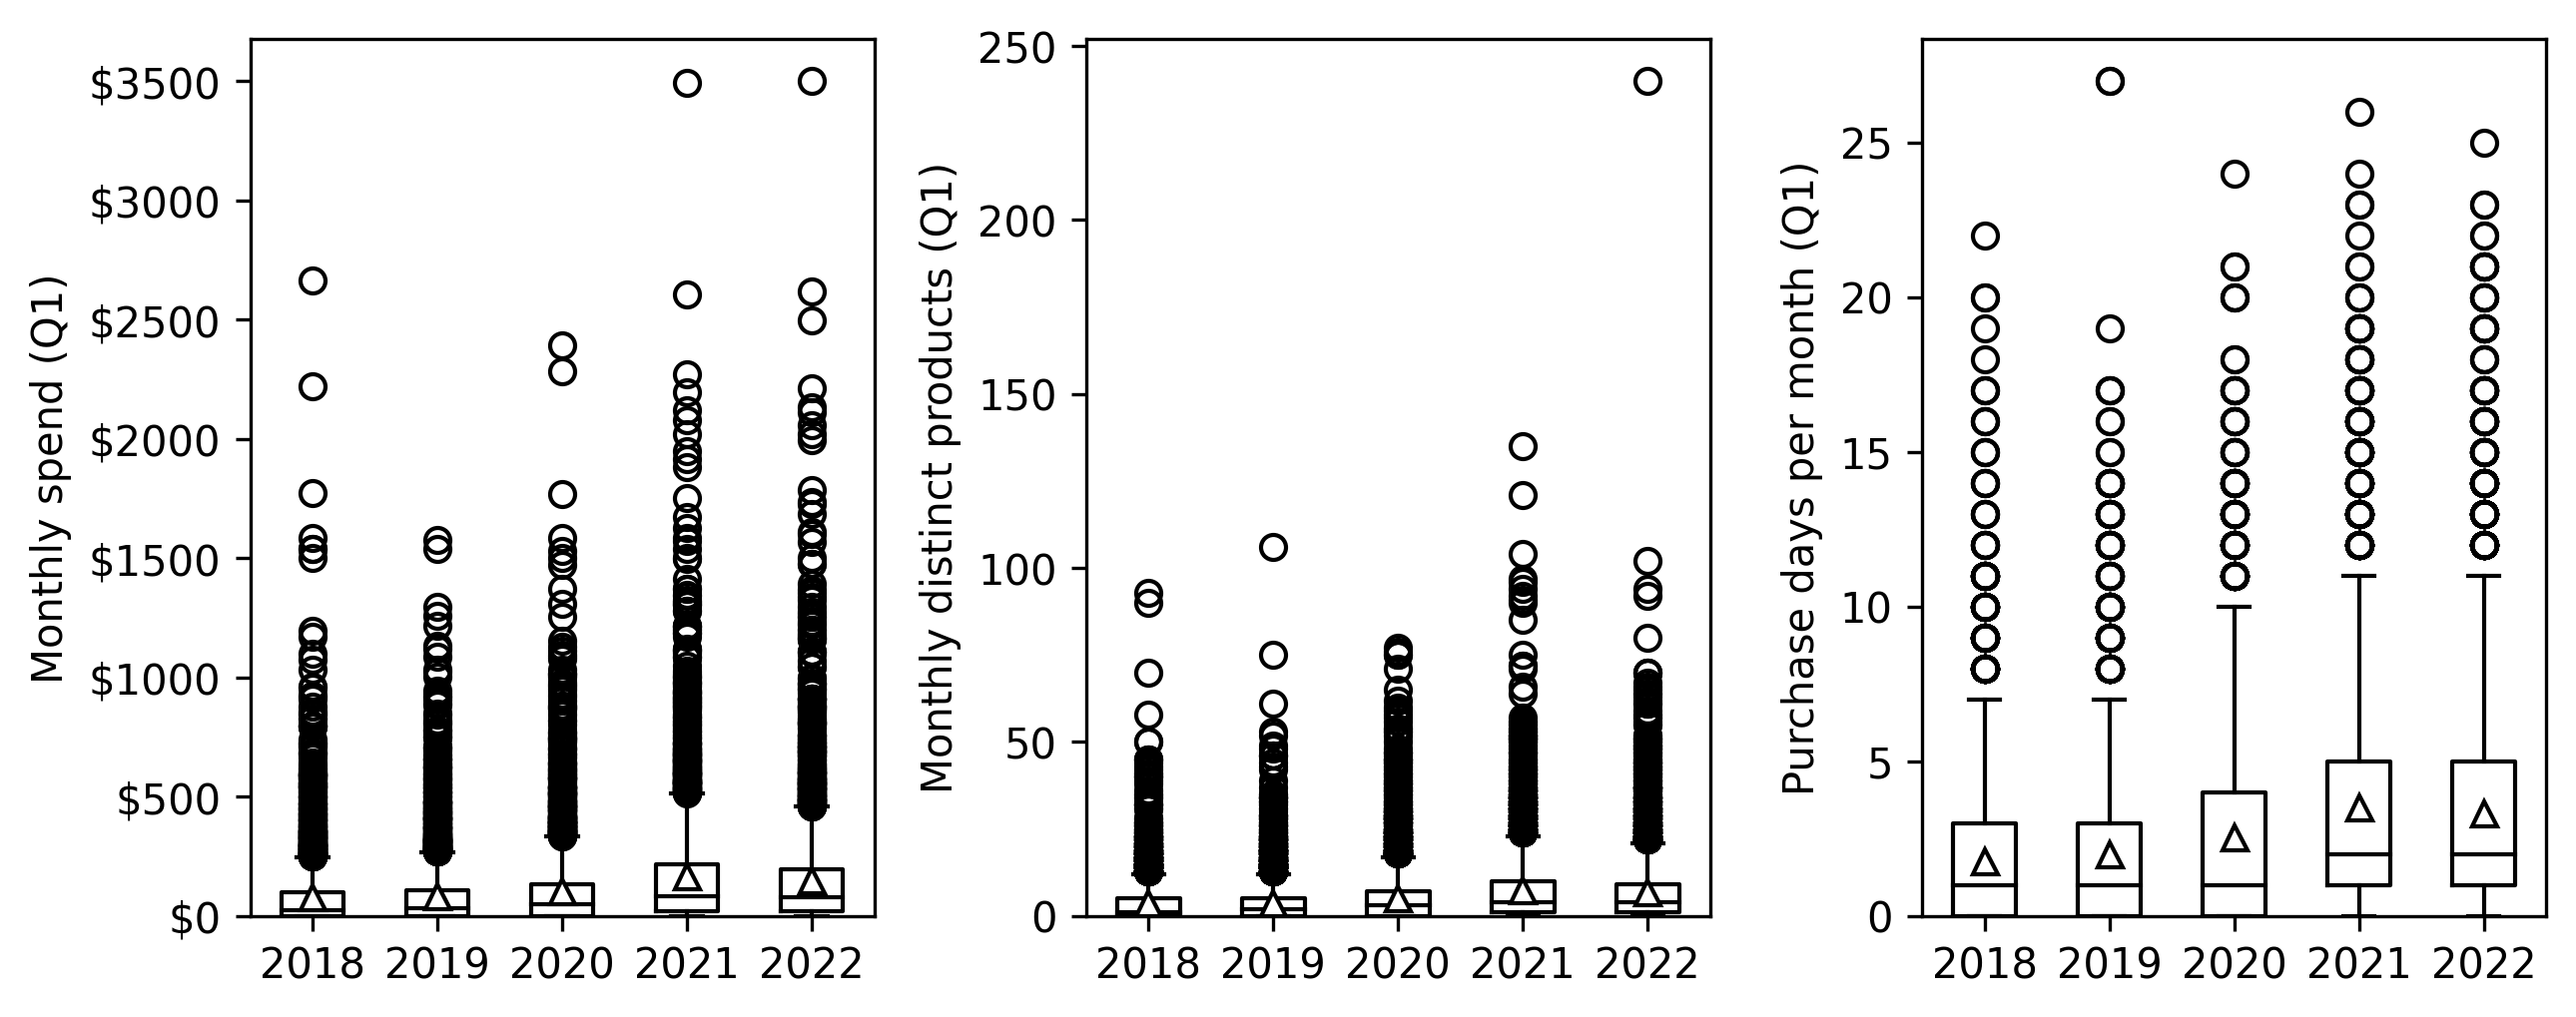

In [47]:
fliers=True
fig, axes = plt.subplots(1,3,figsize=(2.9*3,3.5), dpi=300)
_ = make_q1_boxplots(spend_panel_q1_groupby, ax=axes[0], showfliers=fliers)
axes[0].set_ylabel('Monthly spend (Q1)')
axes[0].yaxis.set_major_formatter('${x:1.0f}')
_ = make_q1_boxplots(products_panel_q1_groupby, ax=axes[1], showfliers=fliers)
axes[1].set_ylabel('Monthly distinct products (Q1)')
_ = make_q1_boxplots(purchase_days_panel_q1_groupby, ax=axes[2], showfliers=fliers)
axes[2].set_ylabel('Purchase days per month (Q1)')
[ax.set_xticklabels(years) for ax in axes]
[ax.set_ylim(0, ax.get_ylim()[1]) for ax in axes]
_ = plt.tight_layout()

Version without fliers

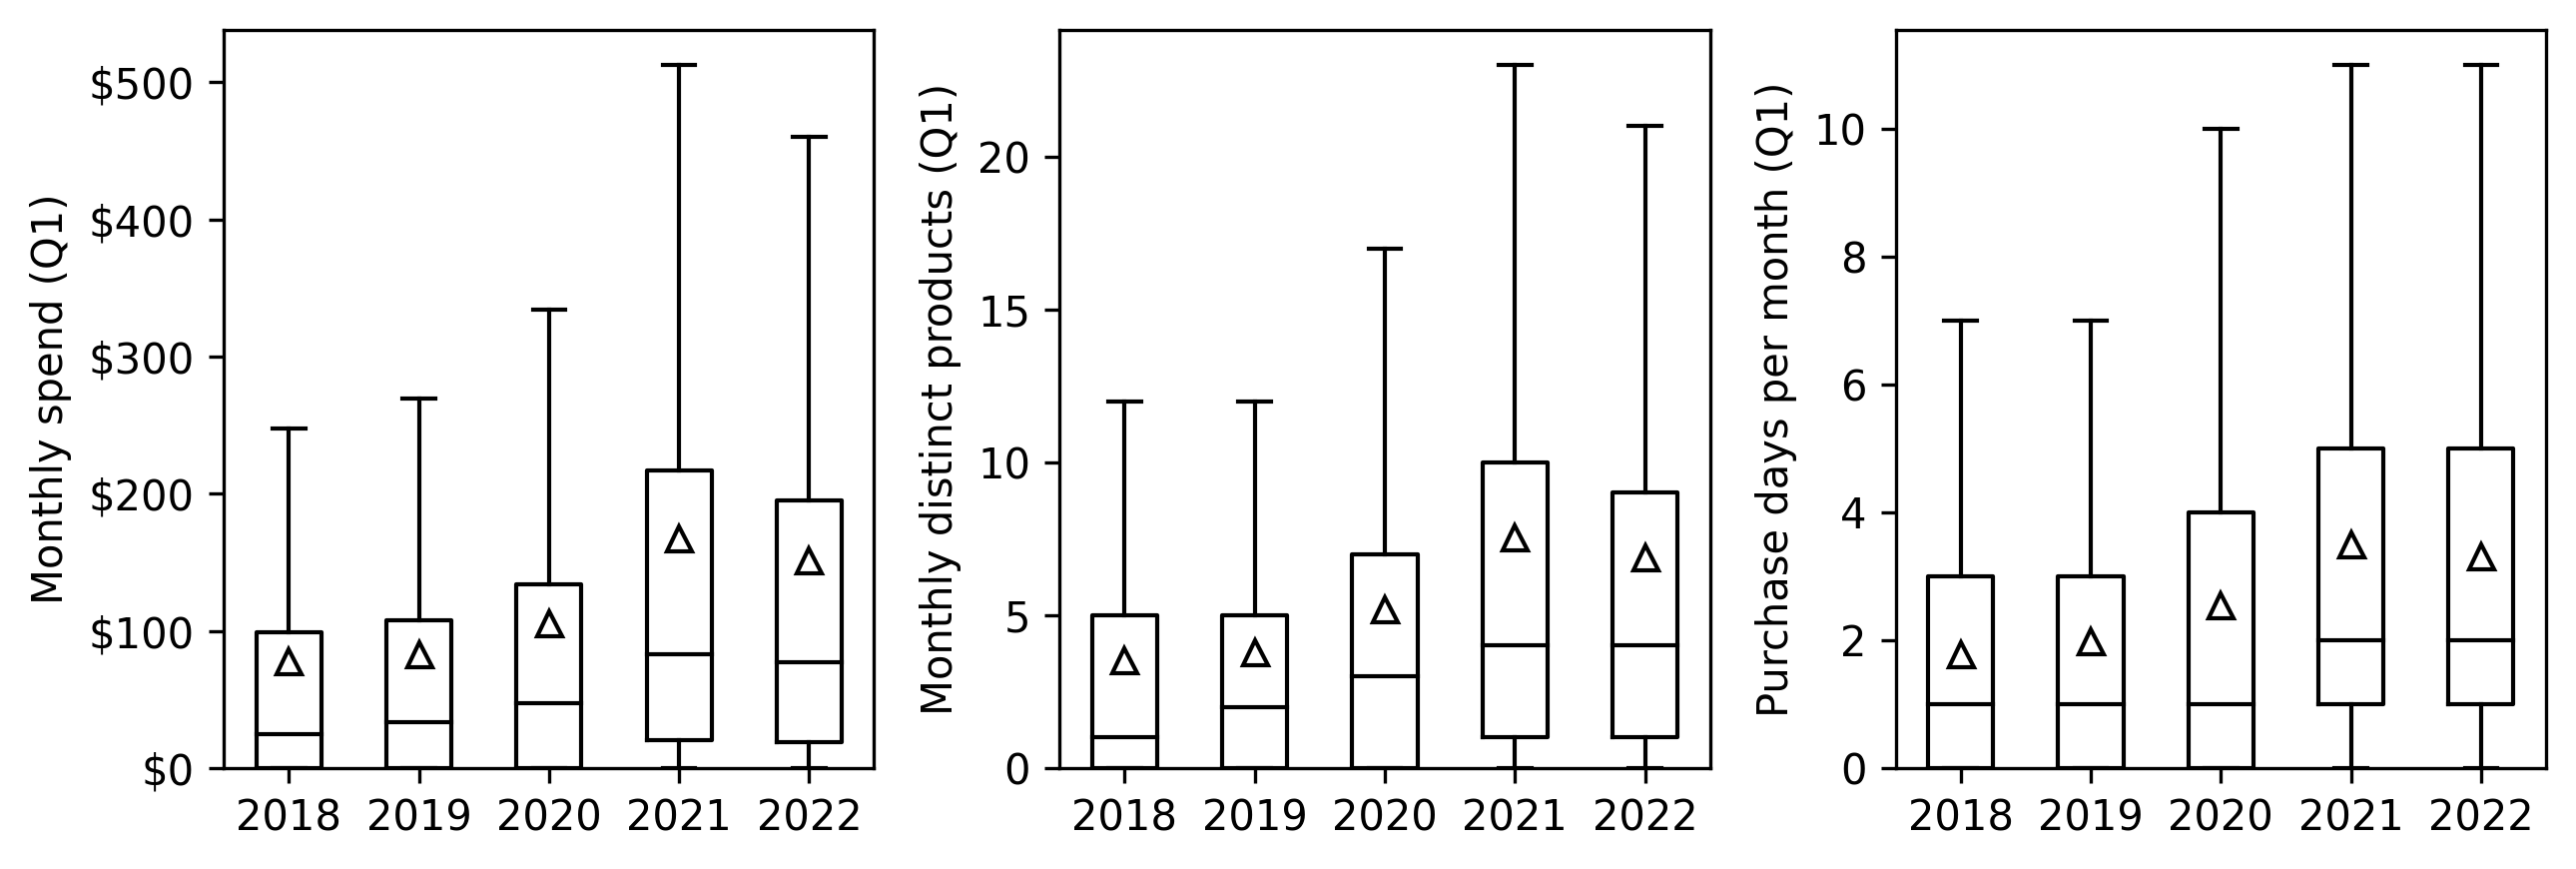

In [48]:
fliers=False
fig, axes = plt.subplots(1,3,figsize=(2.9*3, 3), dpi=300)
_ = make_q1_boxplots(spend_panel_q1_groupby, ax=axes[0], showfliers=fliers)
axes[0].set_ylabel('Monthly spend (Q1)')
axes[0].yaxis.set_major_formatter('${x:1.0f}')
_ = make_q1_boxplots(products_panel_q1_groupby, ax=axes[1], showfliers=fliers)
axes[1].set_ylabel('Monthly distinct products (Q1)')
_ = make_q1_boxplots(purchase_days_panel_q1_groupby, ax=axes[2], showfliers=fliers)
axes[2].set_ylabel('Purchase days per month (Q1)')
[ax.set_xticklabels(years) for ax in axes]
[ax.set_ylim(0, ax.get_ylim()[1]) for ax in axes]
_ = plt.tight_layout()

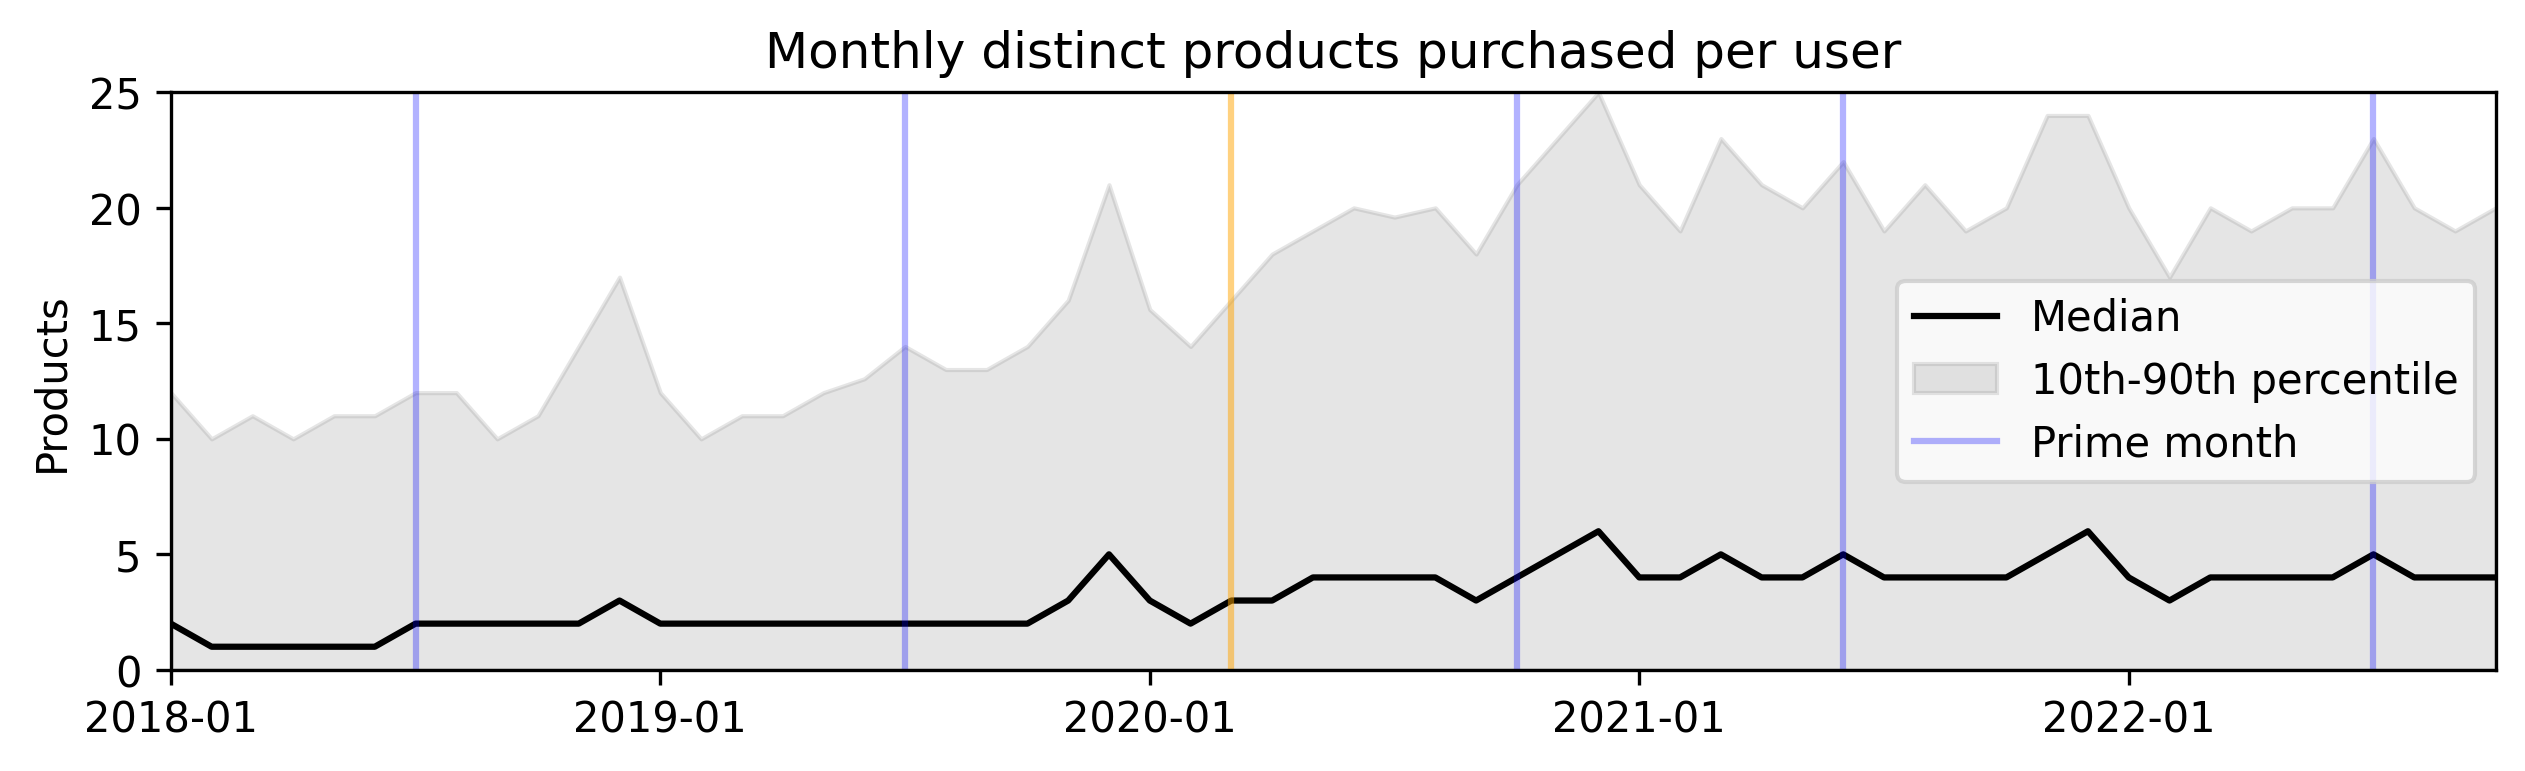

In [49]:
fig, ax = plt.subplots(1,1, figsize=(10, 2.5), dpi=300)
med = panel_m.groupby(['t'])['products'].median()
pct10 = panel_m.groupby(['t'])['products'].quantile(0.1)
pct90 = panel_m.groupby(['t'])['products'].quantile(0.9)
ax.plot(yyyy_mm_idx, med, color='black', label='Median')
ax.fill_between(
    yyyy_mm_idx, pct10, pct90, label='10th-90th percentile', 
    color='gray', alpha=0.2)
# show prime day months
[ax.axvline(x=m, ymin=0, color='blue', alpha=0.3, label=('Prime month' if i==0 else None)) for i, m in enumerate(amzn_prime_ms)]
ax.set_xlim('2018-01', '2022-10')
ax.set_ylim(0, pct90.max())
ax.set_xticks(['2018-01', '2019-01', '2020-01', '2021-01', '2022-01'])
ax.axvline(x='2020-03', ymin=0, color='orange', alpha=0.5)
_ = ax.legend(loc='center right')
ax.set_ylabel('Products')
_ = ax.set_title('Monthly distinct products purchased per user')

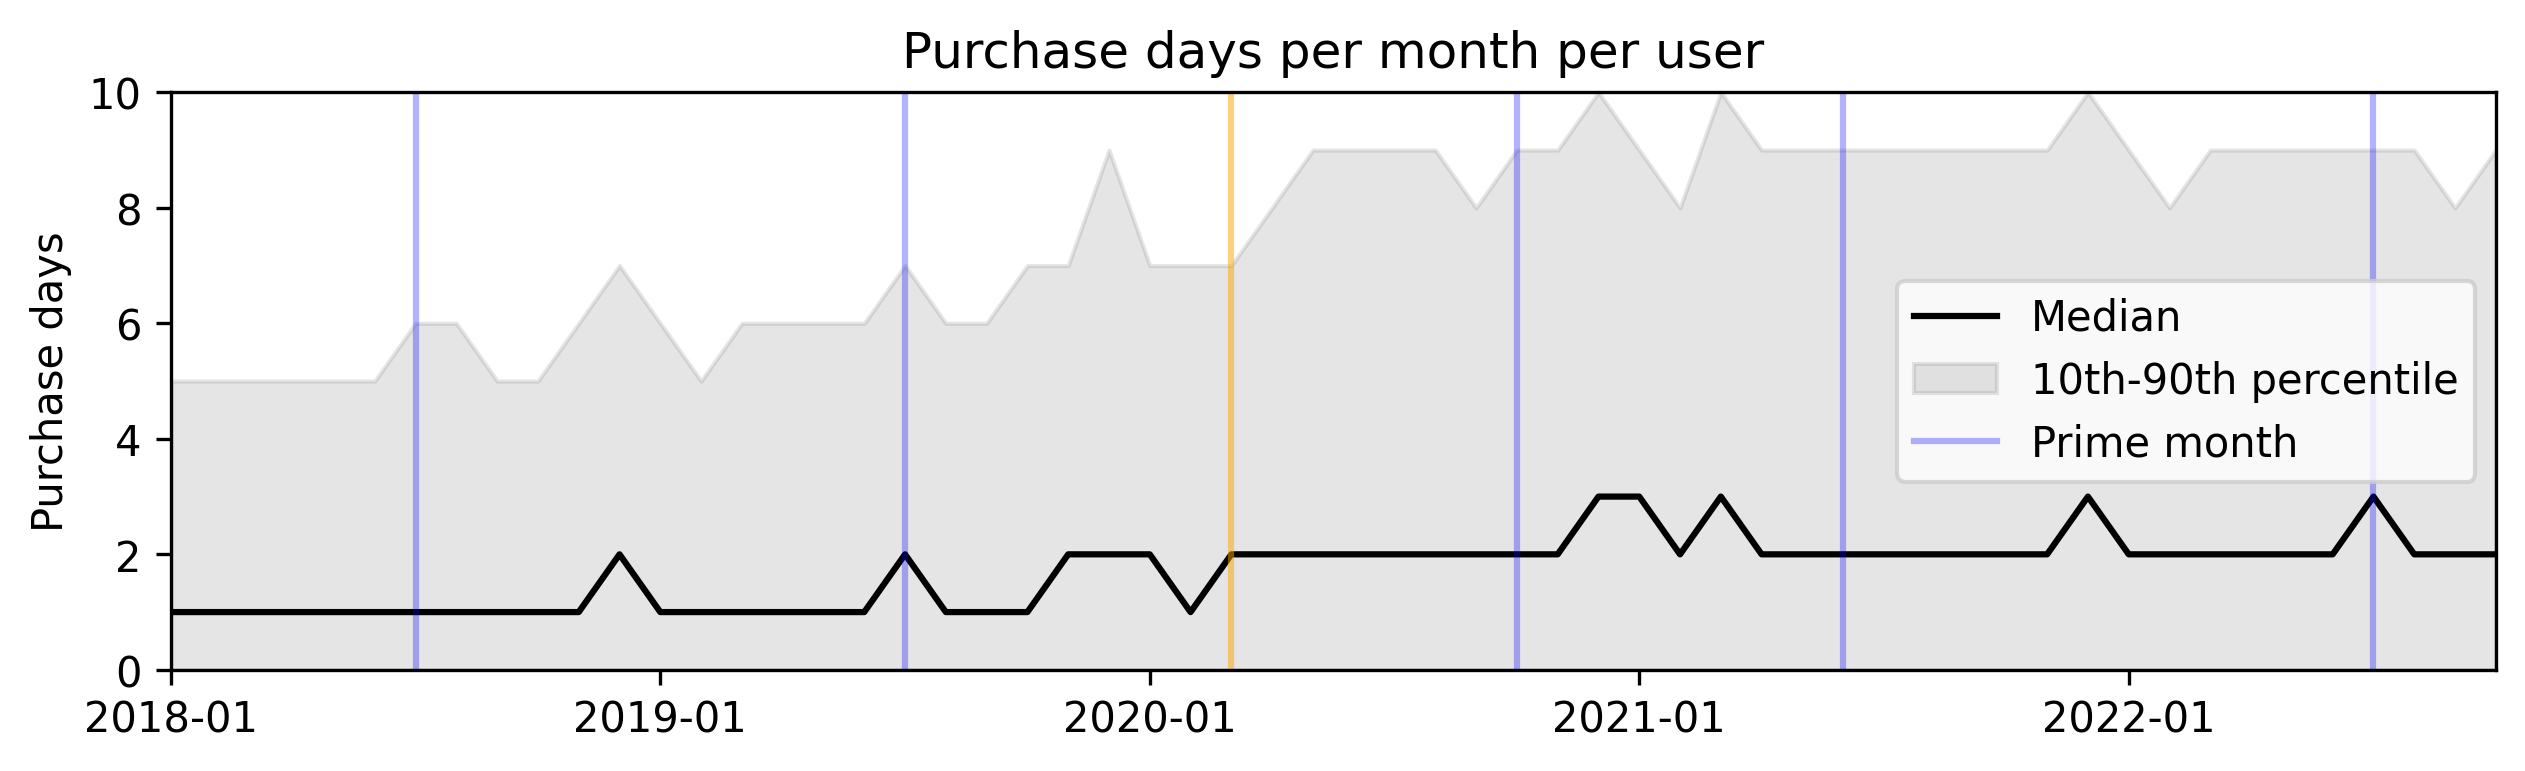

In [50]:
fig, ax = plt.subplots(1,1, figsize=(10, 2.5), dpi=300)
med = panel_m.groupby(['t'])['purchase_days'].median()
pct10 = panel_m.groupby(['t'])['purchase_days'].quantile(0.1)
pct90 = panel_m.groupby(['t'])['purchase_days'].quantile(0.9)
ax.plot(yyyy_mm_idx, med, color='black', label='Median')
ax.fill_between(
    yyyy_mm_idx, pct10, pct90, label='10th-90th percentile', 
    color='gray', alpha=0.2)
# show prime day months
[ax.axvline(x=m, ymin=0, color='blue', alpha=0.3, label=('Prime month' if i==0 else None)) for i, m in enumerate(amzn_prime_ms)]
ax.set_xlim('2018-01', '2022-10')
ax.set_ylim(0, pct90.max())
ax.set_xticks(['2018-01', '2019-01', '2020-01', '2021-01', '2022-01'])
ax.axvline(x='2020-03', ymin=0, color='orange', alpha=0.5)
_ = ax.legend(loc='center right')
ax.set_ylabel('Purchase days')
_ = ax.set_title('Purchase days per month per user')

### By demographic group

In [51]:
linestyles = ['-','-.',':']
alphas = [0.7, 0.7, 1]

def plot_median_for_demos(panel, metric='purchase_days', agg=YEAR, legend=True, 
                          axes=None, dpi=None):
    if agg not in [YEAR, YEAR_Q]:
        raise NotImplemented()
    if agg == YEAR: # only compute over months 1-10
        panel = panel[panel[MONTH] < '11']
    if axes is None:
        fig, axes = plt.subplots(1,3,figsize=(14,3.5), sharex=True, sharey=True, dpi=dpi)#, dpi=300)
        fig.subplots_adjust(wspace=0.09)
    ax = axes[0]
    for i, sex in enumerate(['Male', 'Female']):
        df = panel[panel['Sex']==sex]
        med = df.groupby(agg)[metric].median()
        ax.plot(med, label=sex, linestyle=linestyles[i], color='black', alpha=alphas[i])
    ax = axes[1]
    ages = sorted(list(panel['Age3'].unique()))
    for i, age in enumerate(ages):
        df = panel[panel['Age3']==age]
        med = df.groupby(agg)[metric].median()
        ax.plot(med, label=age, linestyle=linestyles[i], color='black', alpha=alphas[i])
    ax = axes[2]
    incomes = ['Less than $50,000', '\\$50,000 - \\$99,999', '$100,000 or more']
    for i, income in enumerate(incomes):
        df = panel[panel['Income3']==income]
        med = df.groupby(agg)[metric].median()
        ax.plot(med, label=income, linestyle=linestyles[i], color='black', alpha=alphas[i])
    if legend:
        [ax.legend(loc='upper left') for ax in axes]
    return axes

Purchase days per month

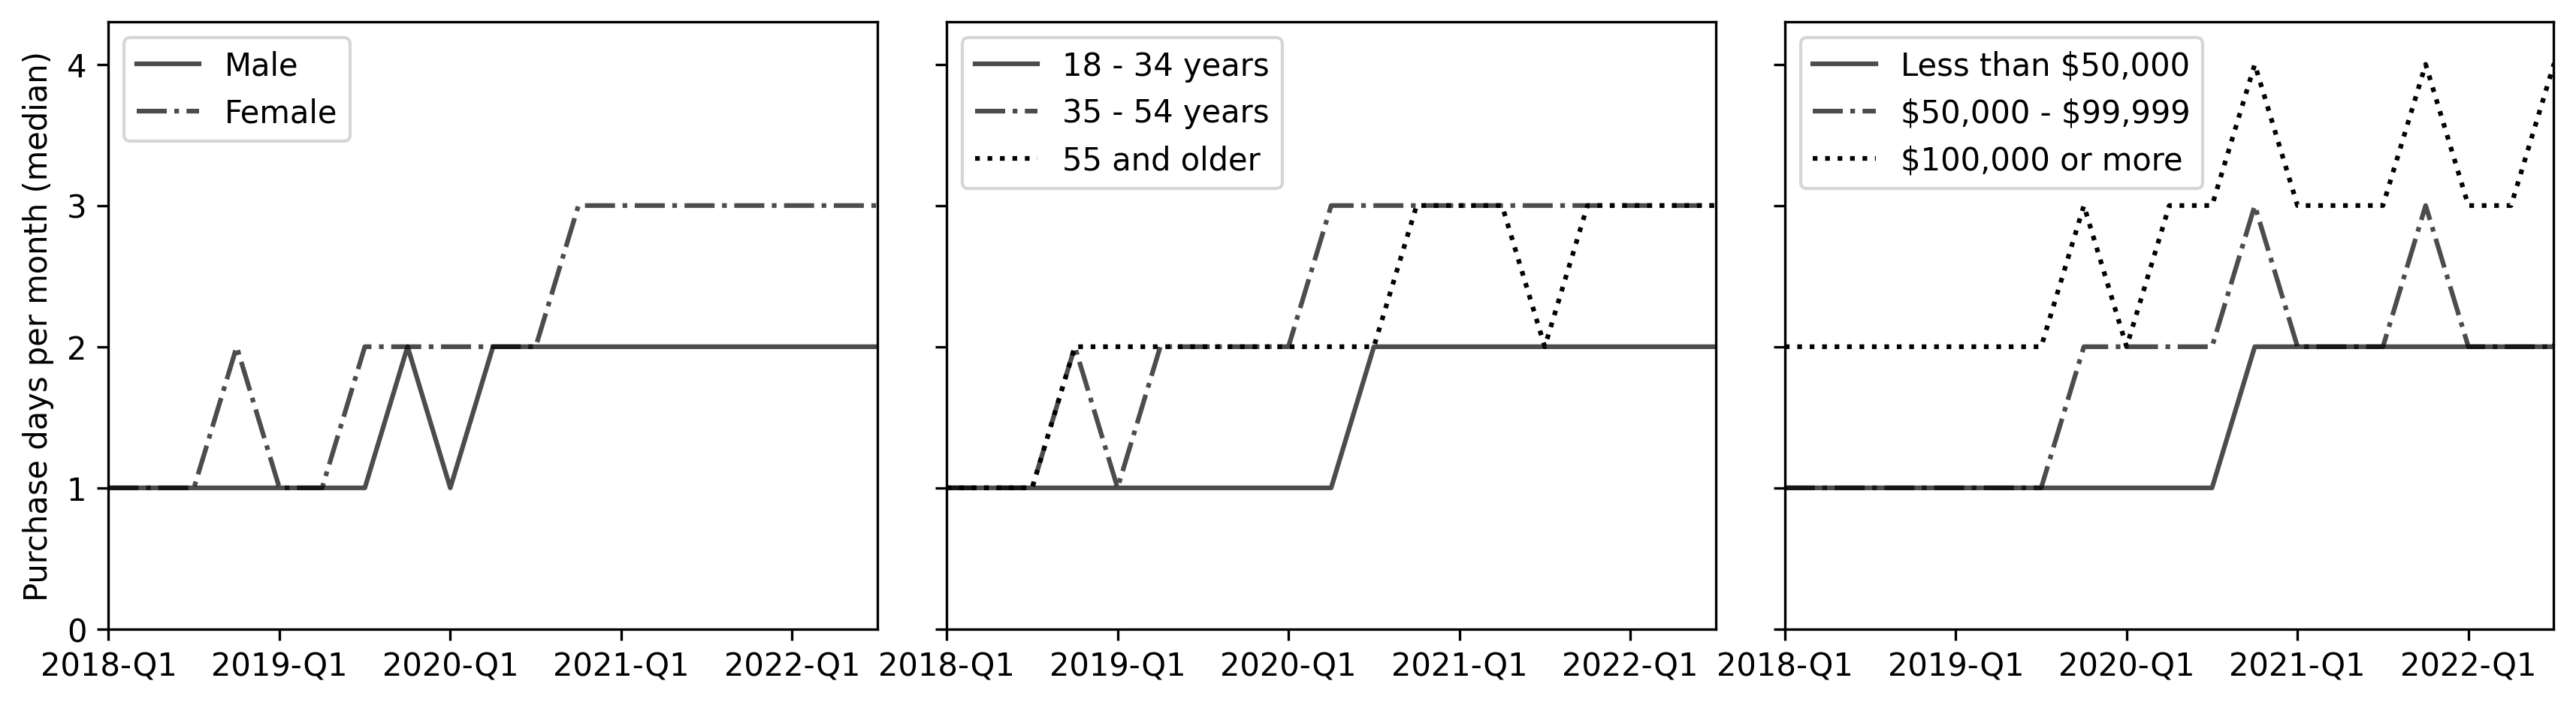

In [52]:
axes = plot_median_for_demos(panel_m, 'purchase_days', agg=YEAR_Q, dpi=300)
axes[0].set_yticks([0,1,2,3,4])
axes[0].set_ylim(0, 4.3)
axes[0].set_xticks(['2018-Q1', '2019-Q1', '2020-Q1', '2021-Q1', '2022-Q1'])
axes[0].set_xlim('2018-Q1', '2022-Q3')
_ = axes[0].set_ylabel('Purchase days per month (median)')

Monthly distinct products

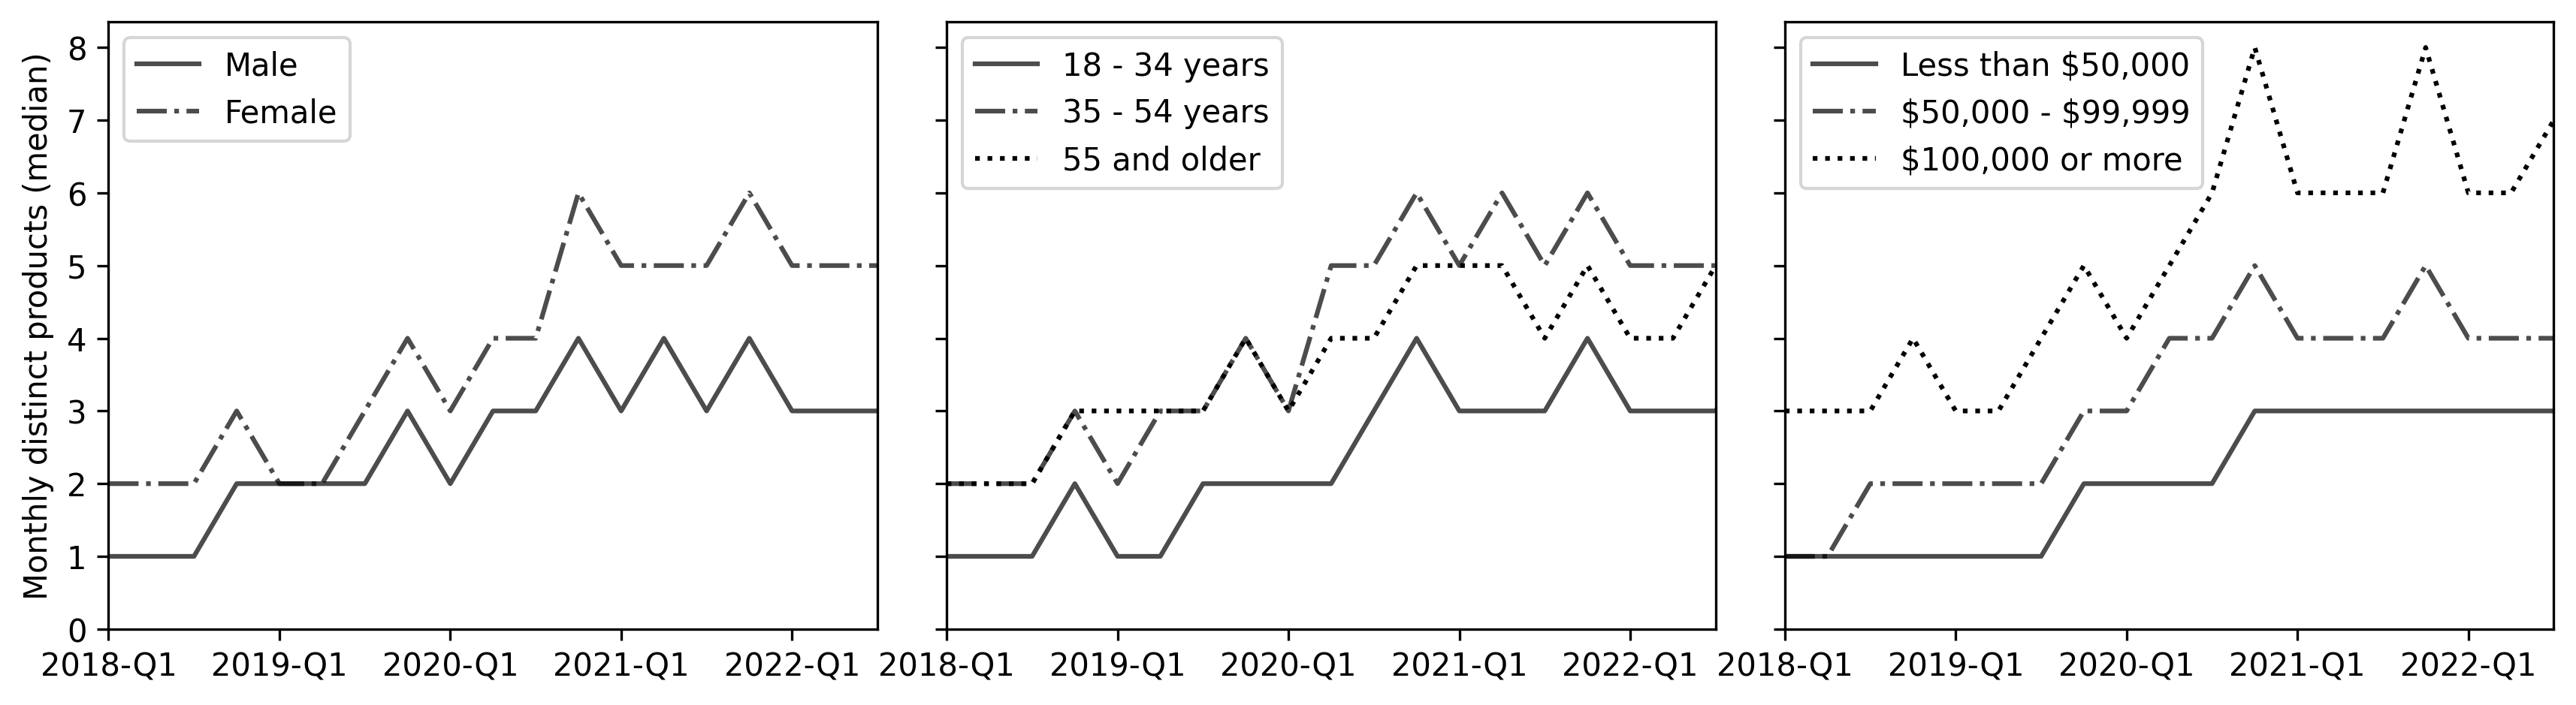

In [53]:
axes = plot_median_for_demos(panel_m, 'products', agg=YEAR_Q, dpi=300)
axes[0].set_ylim(0, axes[0].get_ylim()[1])
axes[0].set_xticks(['2018-Q1', '2019-Q1', '2020-Q1', '2021-Q1', '2022-Q1'])
axes[0].set_xlim('2018-Q1', '2022-Q3')
_ = axes[0].set_ylabel('Monthly distinct products (median)')

Monthly spend

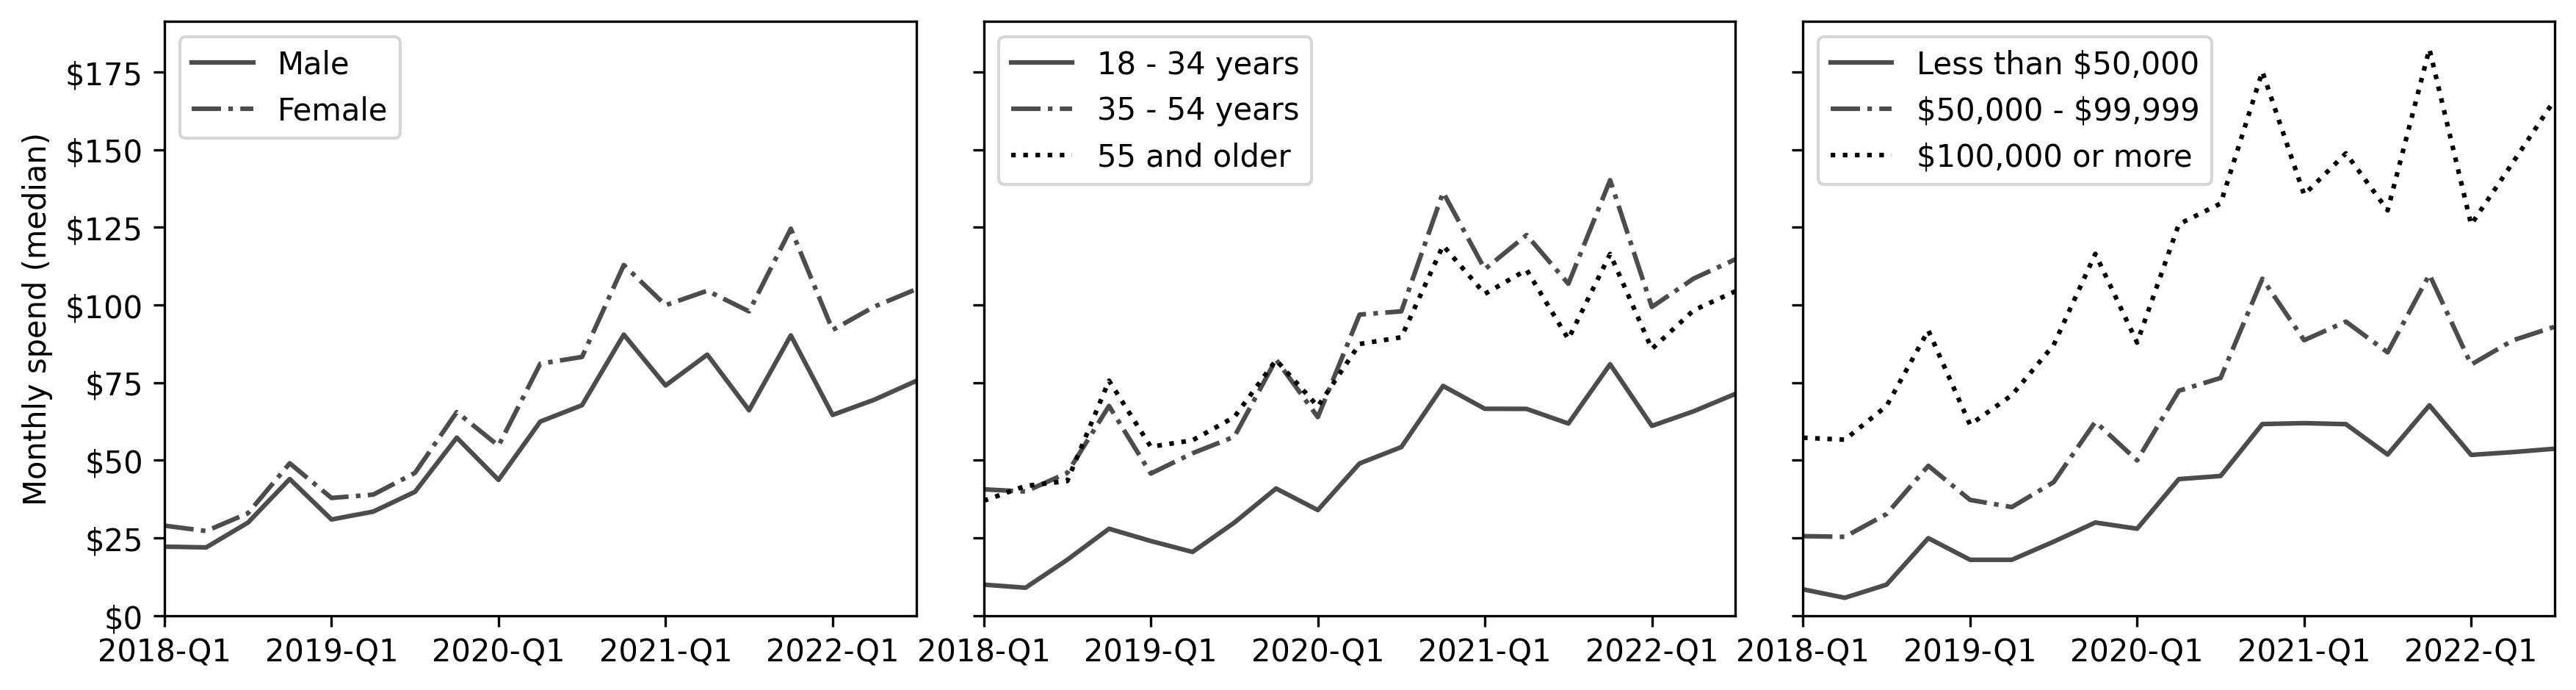

In [54]:
axes = plot_median_for_demos(panel_m, 'spend', agg=YEAR_Q, dpi=300)
axes[0].yaxis.set_major_formatter('${x:1.0f}')
axes[0].set_ylim(0, axes[0].get_ylim()[1])
axes[0].set_xticks(['2018-Q1', '2019-Q1', '2020-Q1', '2021-Q1', '2022-Q1'])
axes[0].set_xlim('2018-Q1', '2022-Q3')
_ = axes[0].set_ylabel('Monthly spend (median)')

All together

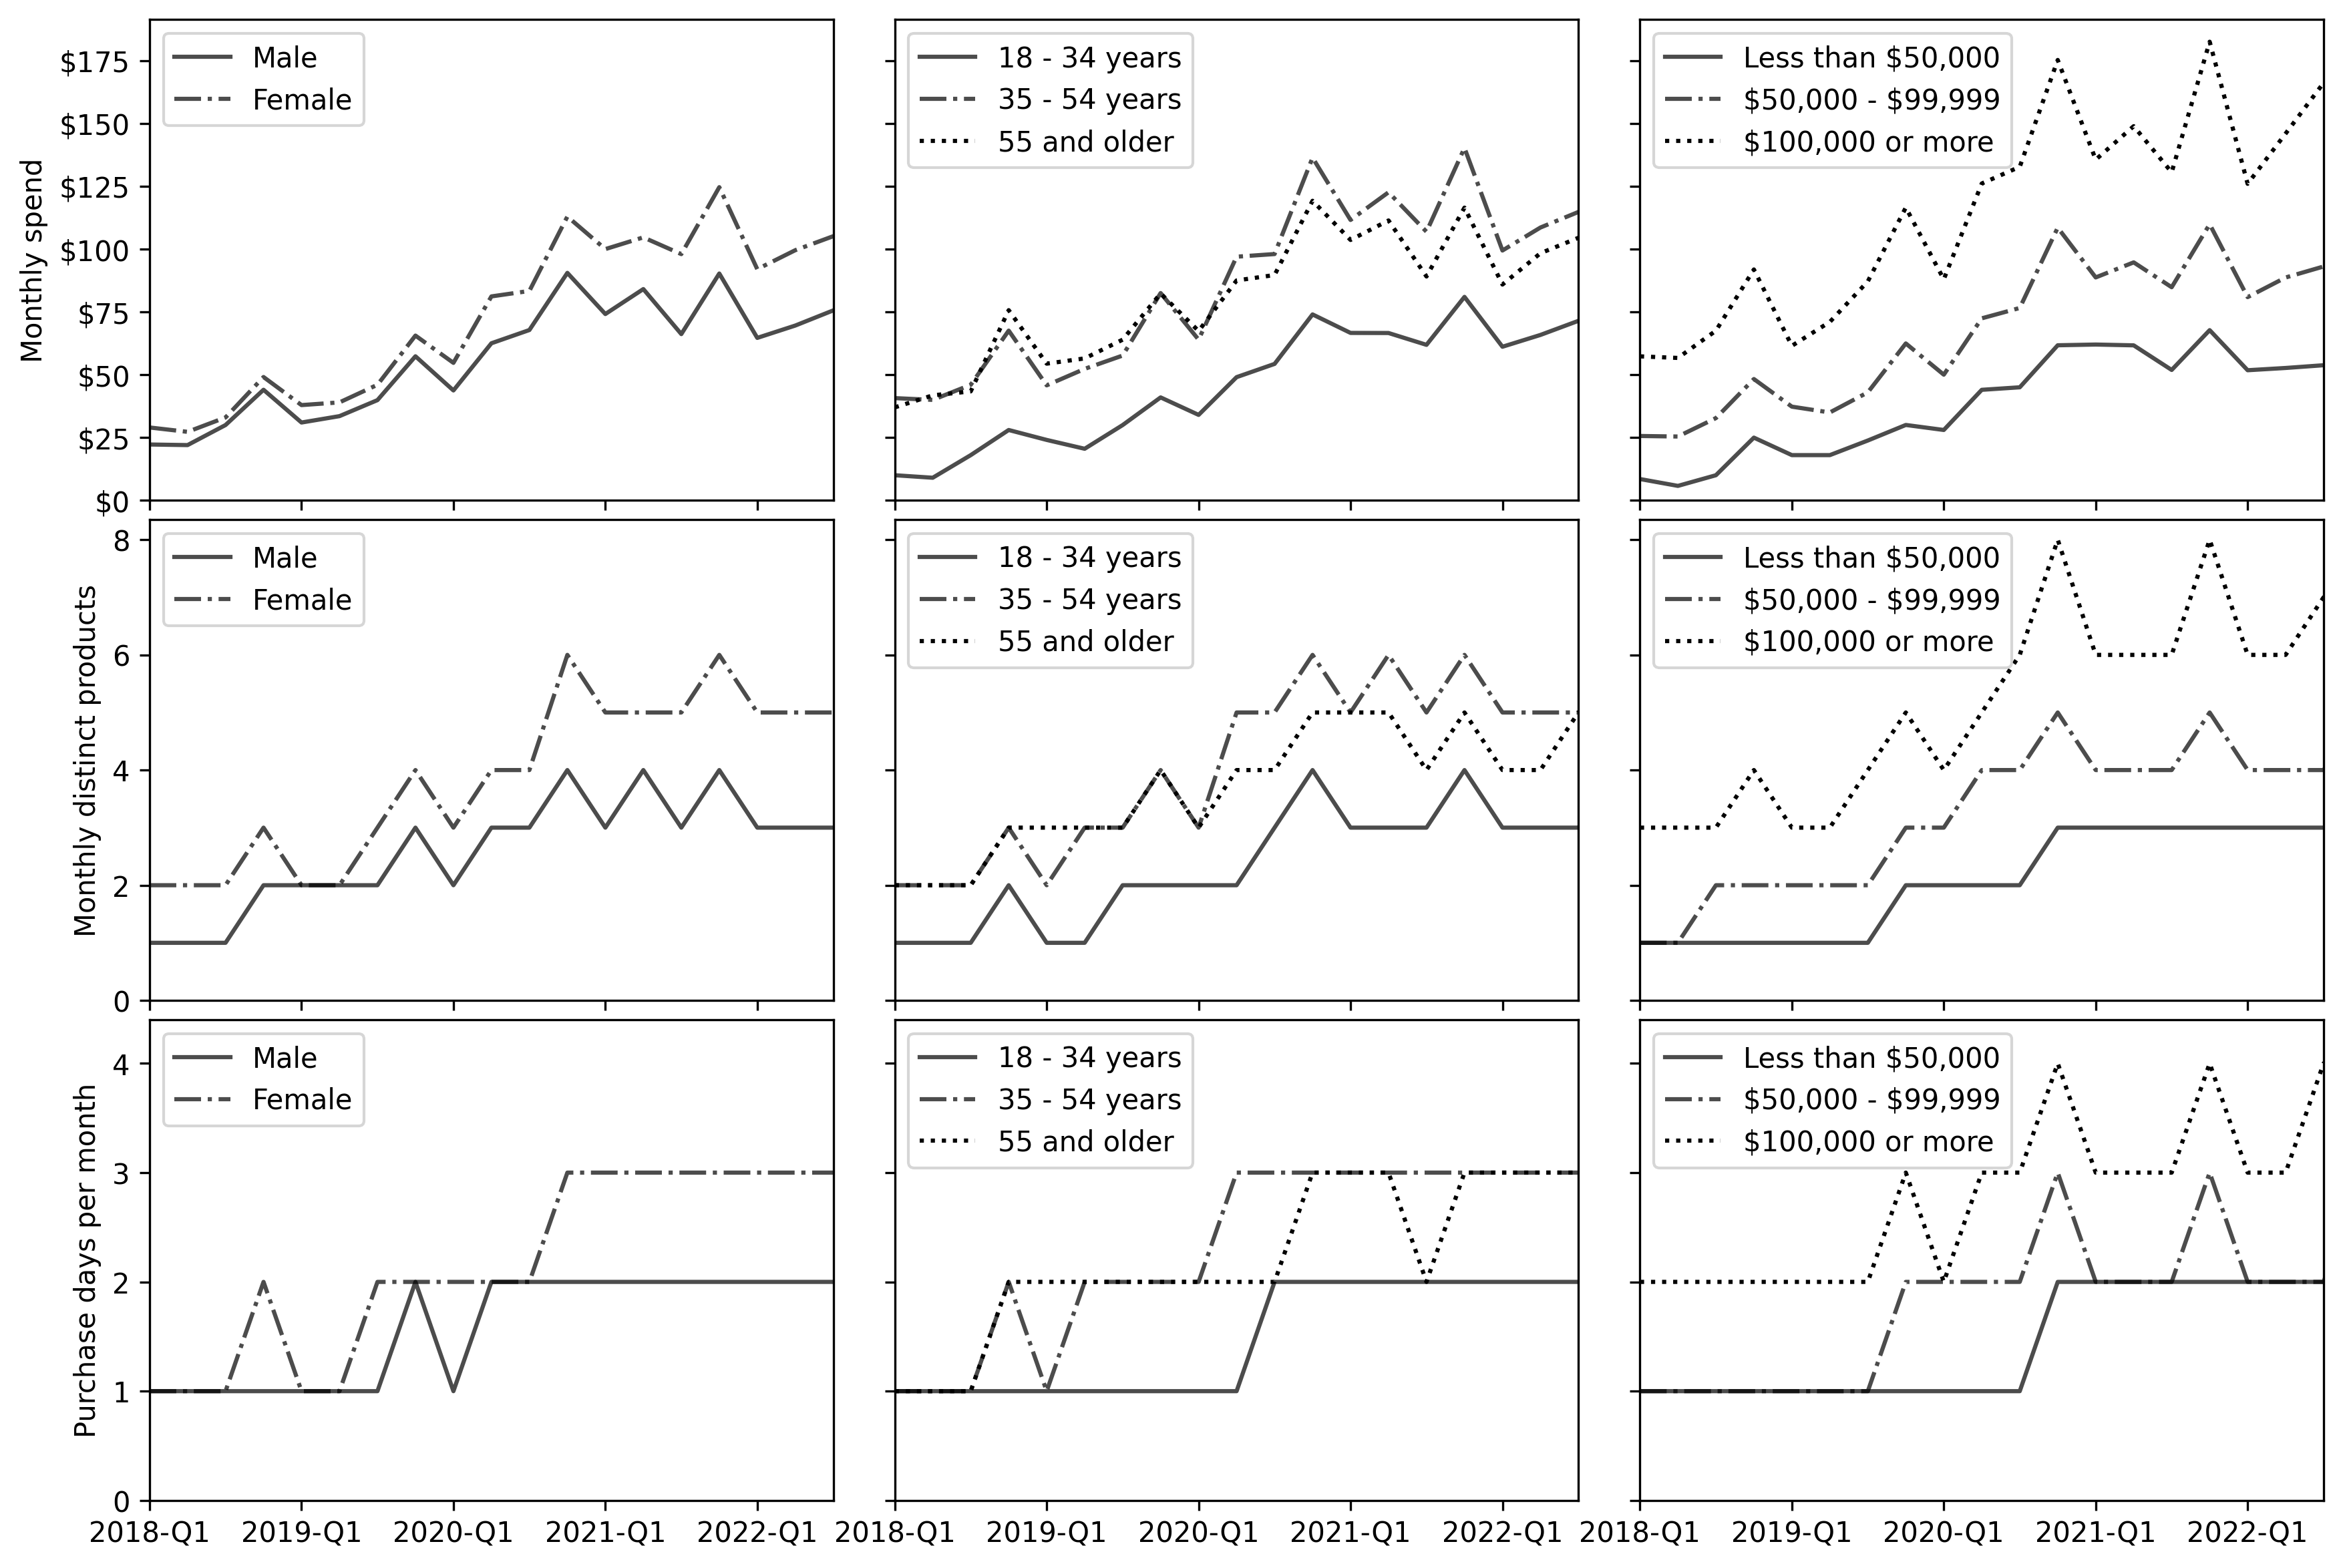

In [55]:
dpi=300
fig, (axes0, axes1, axes2) = plt.subplots(3,3,figsize=(14,3*3.2),sharex=True,sharey='row', dpi=dpi)
fig.subplots_adjust(wspace=0.09, hspace=0.04)
plot_median_for_demos(panel_m, 'spend', agg=YEAR_Q, axes=axes0)
axes0[0].yaxis.set_major_formatter('${x:1.0f}')
axes0[0].set_ylim(0, axes[0].get_ylim()[1])
axes0[0].set_xticks(['2018-Q1', '2019-Q1', '2020-Q1', '2021-Q1', '2022-Q1'])
axes0[0].set_xlim('2018-Q1', '2022-Q3')
axes0[0].set_ylabel('Monthly spend')# (median)')
plot_median_for_demos(panel_m, 'products', agg=YEAR_Q, axes=axes1)
axes1[0].set_ylim(0, axes1[0].get_ylim()[1])
axes1[0].set_ylabel('Monthly distinct products')# (median)')
plot_median_for_demos(panel_m, 'purchase_days', agg=YEAR_Q, axes=axes2)
axes2[0].set_yticks([0,1,2,3,4])
axes2[0].set_ylim(0, 4.4)
_ = axes2[0].set_ylabel('Purchase days per month')# (median)')

#### Year plots

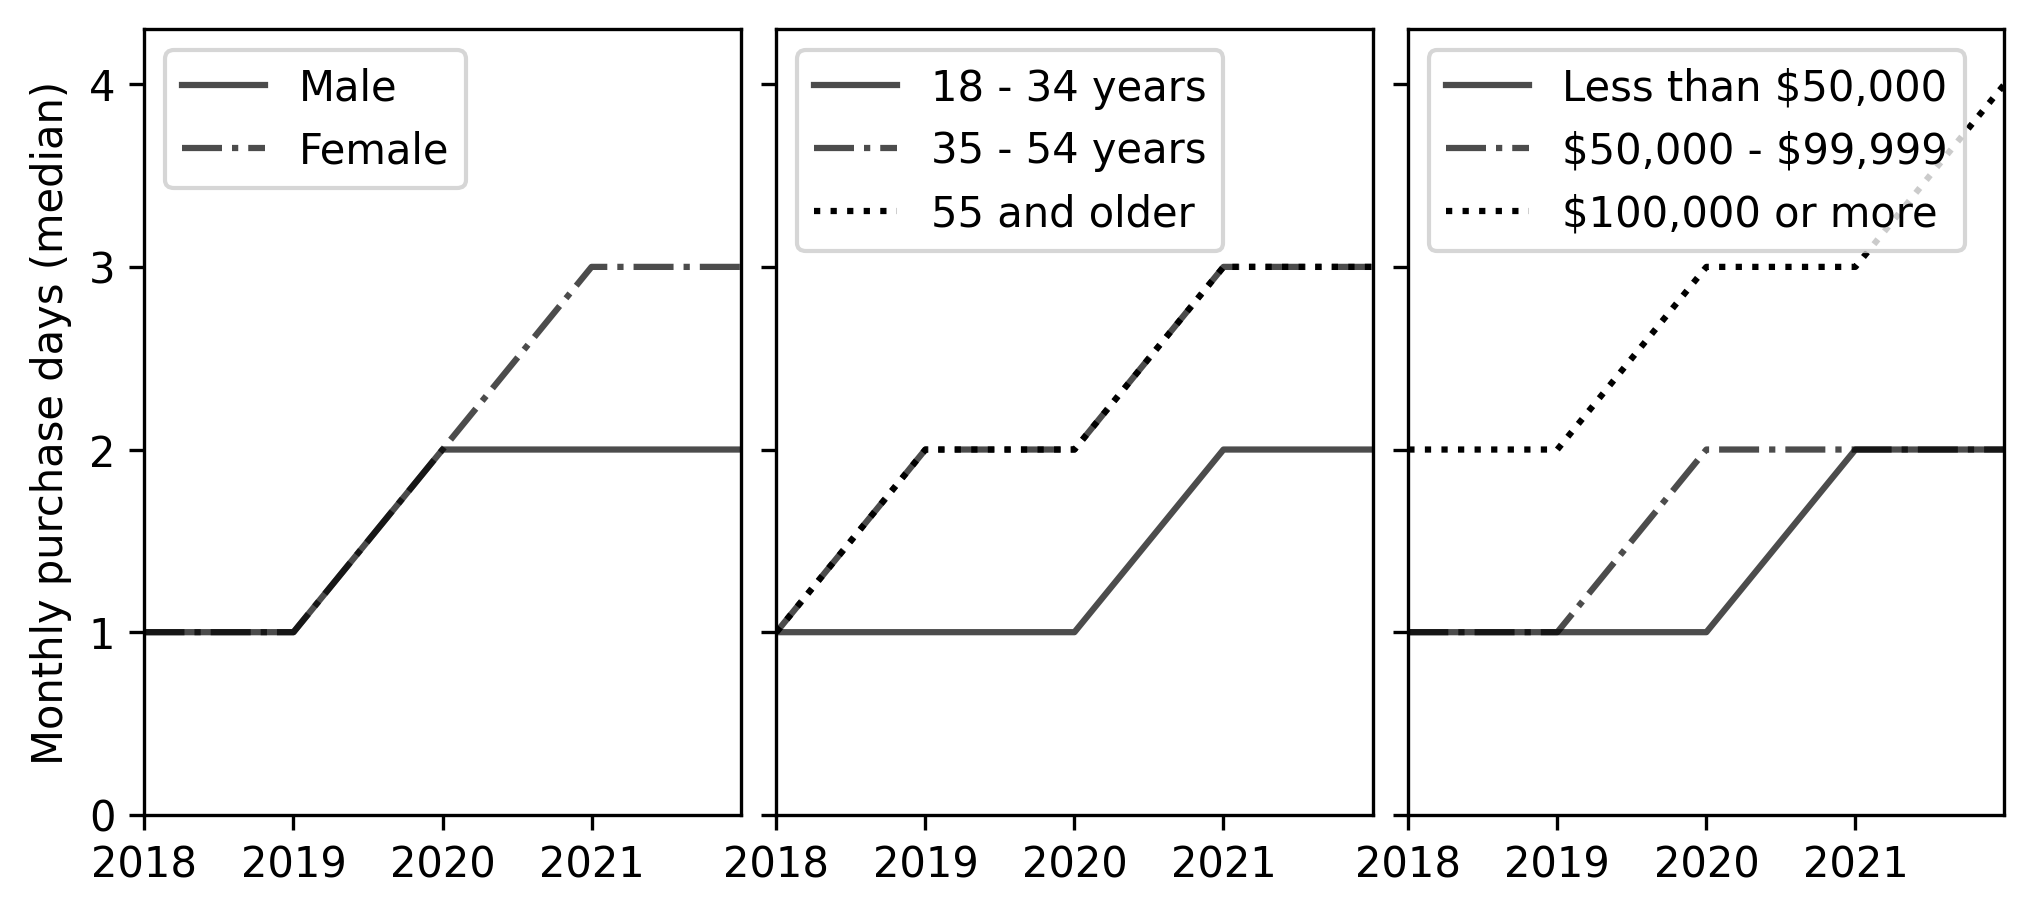

In [56]:
fig, axes = plt.subplots(1,3,figsize=(8,3.4), sharex=True, sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.06)
axes = plot_median_for_demos(panel_m, 'purchase_days', agg=YEAR, axes=axes)
axes[0].set_yticks([0,1,2,3,4])
axes[0].set_ylim(0, 4.3)
axes[0].set_xticks(['2018', '2019', '2020', '2021'])
axes[0].set_xlim('2018', '2022')
_ = axes[0].set_ylabel('Monthly purchase days (median)')

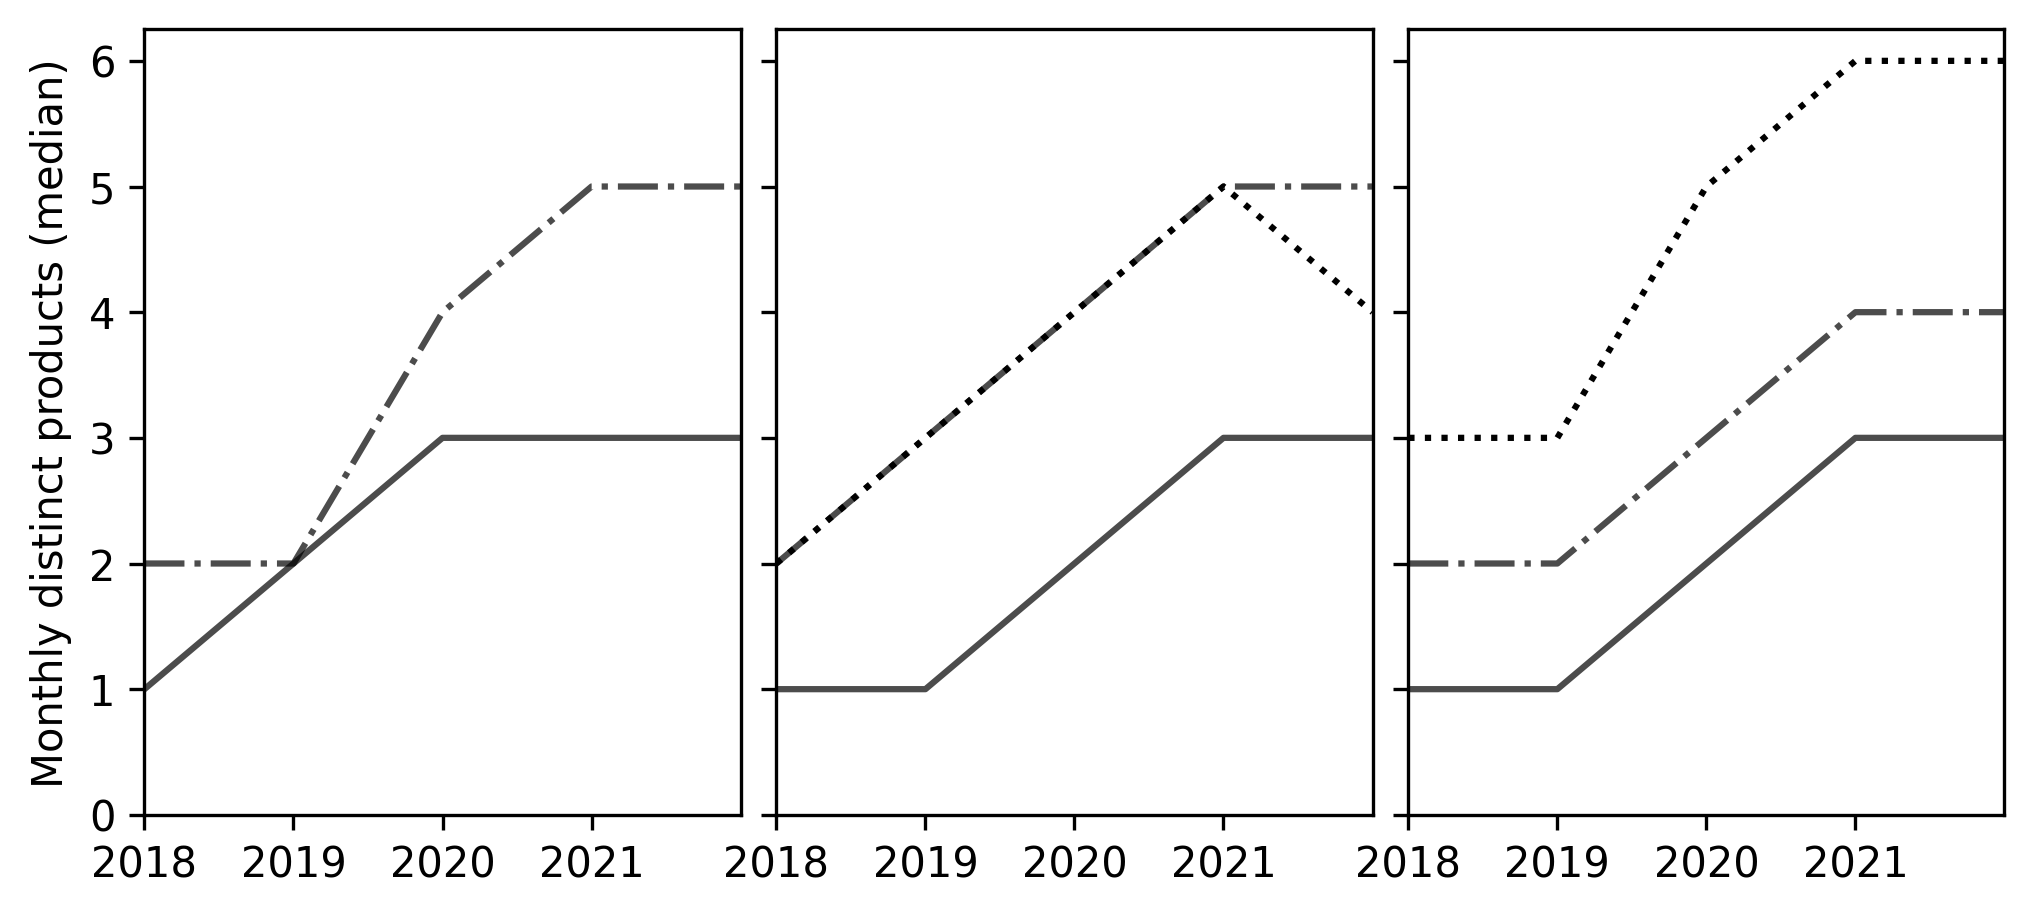

In [57]:
fig, axes = plt.subplots(1,3,figsize=(8,3.4), sharex=True, sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.06)
axes = plot_median_for_demos(panel_m, 'products', agg=YEAR, legend=False, axes=axes)
axes[0].set_ylim(0, axes[0].get_ylim()[1])
axes[0].set_xticks(['2018', '2019', '2020', '2021'])
axes[0].set_xlim('2018', '2022')
_ = axes[0].set_ylabel('Monthly distinct products (median)')

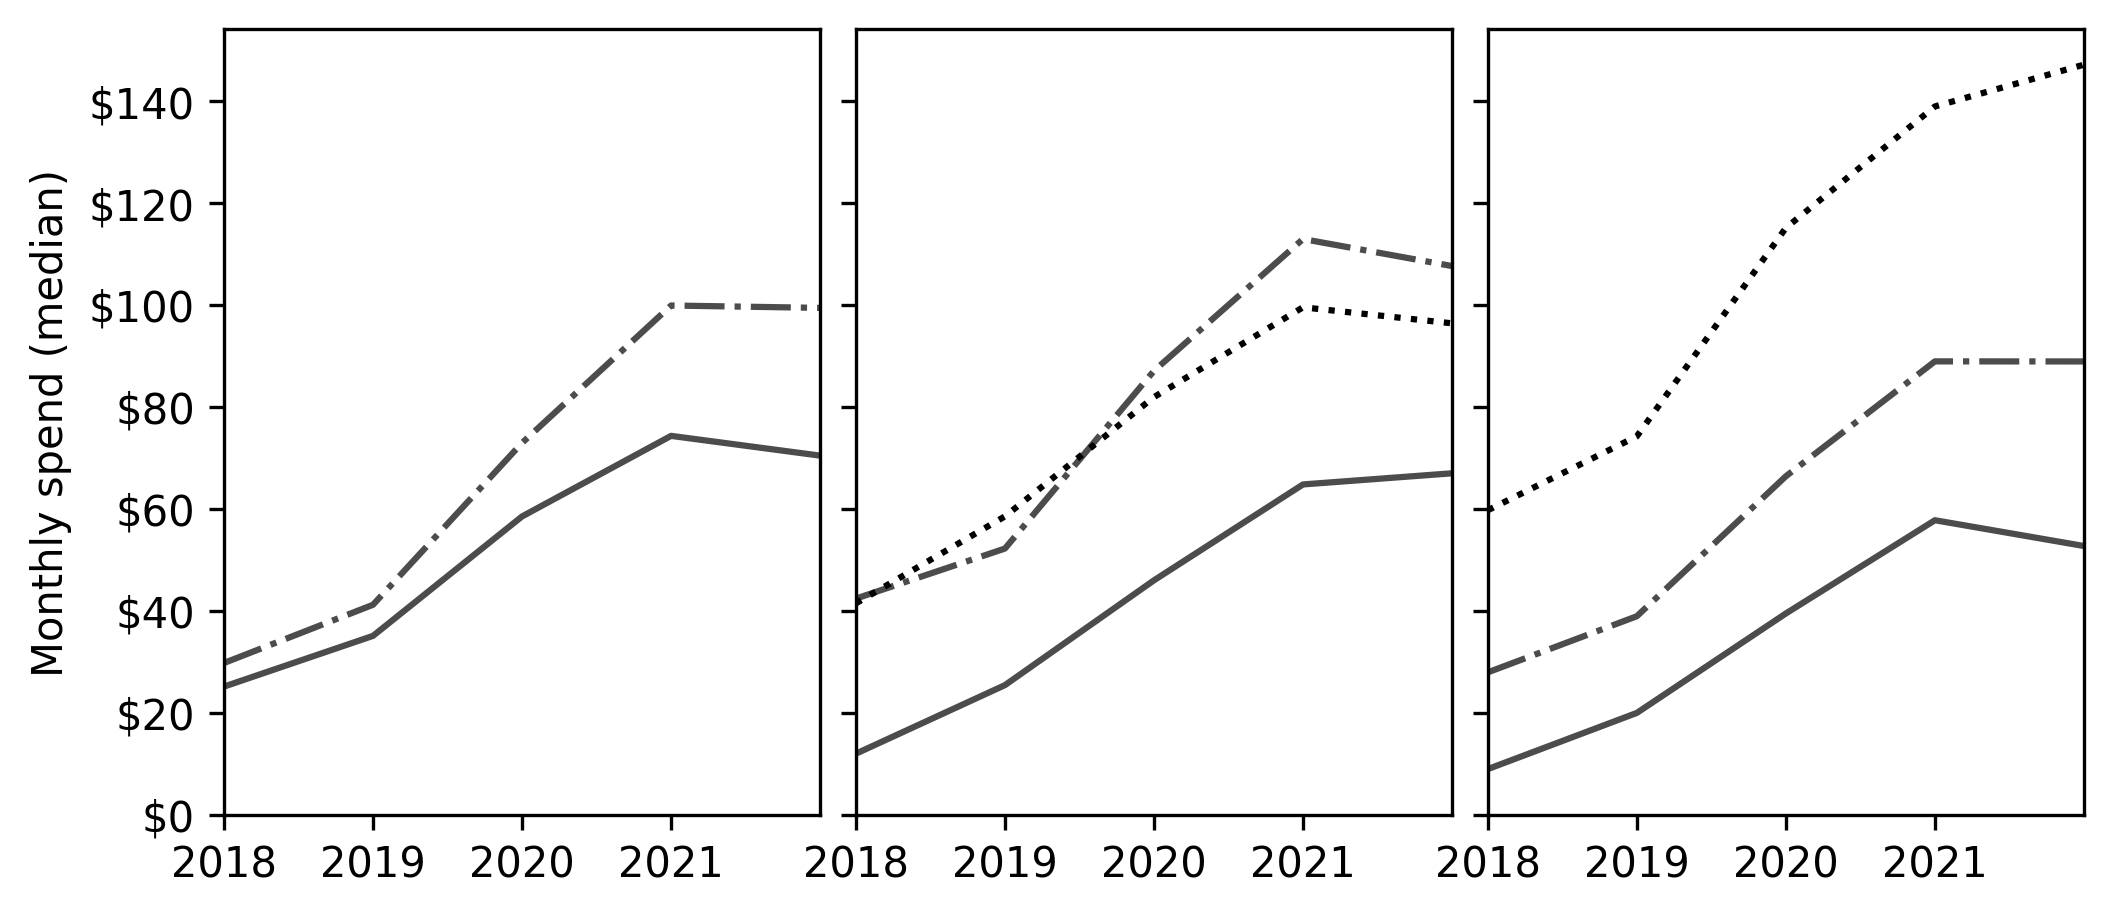

In [58]:
fig, axes = plt.subplots(1,3,figsize=(8,3.4), sharex=True, sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.06)
axes = plot_median_for_demos(panel_m, 'spend', agg=YEAR, axes=axes, legend=False)
axes[0].yaxis.set_major_formatter('${x:1.0f}')
axes[0].set_ylim(0, axes[0].get_ylim()[1])
axes[0].set_xticks(['2018', '2019', '2020', '2021'])
axes[0].set_xlim('2018', '2022')
_ = axes[0].set_ylabel('Monthly spend (median)')

### Relationship between metrics



Correlation analysis

In [59]:
print('Correlation between monthly spend and distinct products:')
print('Pearson r=%0.3f (p=%0.3f)' % pearsonr(panel_m['spend'], panel_m['products']))
print('Correlation between monthly spend and purchase days:')
print('Pearson r=%0.3f (p=%0.3f)' % pearsonr(panel_m['spend'], panel_m['purchase_days']))
print('Correlation between monthly purchase days and distinct products:')
print('Pearson r=%0.3f (p=%0.3f)' % pearsonr(panel_m['purchase_days'], panel_m['products']))

Correlation between monthly spend and distinct products:
Pearson r=0.757 (p=0.000)
Correlation between monthly spend and purchase days:
Pearson r=0.702 (p=0.000)
Correlation between monthly purchase days and distinct products:
Pearson r=0.835 (p=0.000)


#### Regression

On average, an additional purchase day per month corresponds to X additional distinct porudcts purchased each month...

products ~ purchase_days

In the regression, avoid intercept.

In [60]:
formula = 'products ~ purchase_days -1'
data = panel_m
print(formula)
res = smf.ols(formula, data=data).fit()
res.summary()

products ~ purchase_days -1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               products   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.784
Method:                 Least Squares   F-statistic:                          8.682e+05
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        11:44:45   Log-Likelihood:                     -7.4970e+05
No. Observations:              238670   AIC:                                  1.499e+06
Df Residuals:                  238669   BIC:                                  1.499e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
purchase_days     2.2698      0.002    931.784      0.000       2.265       2.275
==============================================================================
Omnibus:                   308618.001   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        168981230.707
Skew:                           6.827   Prob(JB):                         0.00
Kurtosis:                     132.637   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regression when controlling for Sex, Age, Income, with SEs clustered at the responseID

products ~ a[i] + purchase_days + Sex + Age + Income + e[i]

Result: This adjusts R-squared by 0.001 and coef for purchase_days does not change.

In [61]:
formula_covariates_age_sex_inc_str = "C(Sex, Treatment(reference='Male'))"
# actually higher p-value when use more specific ages
formula_covariates_age_sex_inc_str += " + C(Age3, Treatment(reference='35 - 54 years'))"
formula_covariates_age_sex_inc_str += " + C(Income3, Treatment(reference='\$50,000 - \$99,999'))"
# formula_covariates_age_sex_inc_str += " + C(Age6, Treatment(reference='35 - 44 years'))"
# formula_covariates_age_sex_inc_str += " + C(Income6, Treatment(reference='$75,000 - $99,999'))"

##### Incorporating time

We might ask whether this relationship between purchase frequency and products purchased has changed over time. 
In particular, as more people have gotten Prime subscriptions offering free shipping, and as other sellers have offered free shipping, people might make more smaller purchases.

So we also test this with the OLS

products ~ purchase_days + purchase_days x t


In [62]:
formula = 'products ~ purchase_days + purchase_days:t -1'
data = panel_m
print(formula)
res = smf.ols(formula, data=data).fit()
res.summary()

products ~ purchase_days + purchase_days:t -1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               products   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                          4.354e+05
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                        0.00
Time:                        11:44:48   Log-Likelihood:                     -7.4943e+05
No. Observations:              238670   AIC:                                  1.499e+06
Df Residuals:                  238668   BIC:                                  1.499e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
purchase_days       2.1428      0.006    359.448      0.000       2.131       2.154
purchase_days:t     0.0037      0.000     23.331      0.000       0.003       0.004
==============================================================================
Omnibus:                   307394.841   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        165363111.666
Skew:                           6.780   Prob(JB):                         0.00
Kurtosis:                     131.236   Cond. No.                         91.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
formula += (' + ' + formula_covariates_age_sex_inc_str)
data = panel_m.dropna()
print(formula)
model = smf.ols(formula, data=data)
# Fit with SEs clustered at the responseID
res = model.fit(cov_type = 'cluster',cov_kwds={'groups': data['ResponseID']})
res.summary()

products ~ purchase_days + purchase_days:t -1 + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               products   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                nan
Time:                        11:44:49   Log-Likelihood:            -7.2021e+05
No. Observations:              229390   AIC:                         1.440e+06
Df Residuals:                  229382   BIC:                         1.441e+06
Df Model:                           7                                         
Covariance Type:              cluster                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
C(Sex, Treatment(reference='Male'))[Female]                                    -0.1603      0.112     -1.427      0.154      -0.381       0.060
C(Sex, Treatment(reference='Male'))[Male]                                      -0.6057      0.117     -5.173      0.000      -0.835      -0.376
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                 -0.1598      0.094     -1.699      0.089      -0.344       0.025
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                  -0.4757      0.142     -3.350      0.001      -0.754      -0.197
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]      0.0286      0.117      0.244      0.807      -0.201       0.259
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]     0.1531      0.105      1.464      0.143      -0.052       0.358
purchase_days                                                                   2.2140      0.034     64.725      0.000       2.147       2.281
purchase_days:t                                                                 0.0033      0.001      4.336      0.000       0.002       0.005
==============================================================================
Omnibus:                   290847.069   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        155370749.946
Skew:                           6.572   Prob(JB):                         0.00
Kurtosis:                     129.819   Cond. No.                         731.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## Event study: Graphical

### Model

metric[i,t] = a[i] +  ∑ B[t]  + Beta x [Sex + Age + Income] + e[i]


In [64]:
formula_str = '{metric} ~ C(t, Treatment(reference=0))'
formula_str += (' + ' + formula_covariates_age_sex_inc_str)

With metric: spend

In [68]:
metric = 'spend'
data = panel_m[[
    'ResponseID', metric, 't', YYYY_MM,
    'Sex', 
    #'Age6', 'Income6',
    'Age3', 'Income3',
]].dropna()
formula = formula_str.format(metric=metric)
print(formula)
model = smf.ols(formula, data=data)
# Fit with SEs clustered at the responseID
res = model.fit(cov_type = 'cluster',cov_kwds={'groups': data['ResponseID']})
res.summary()

spend ~ C(t, Treatment(reference=0)) + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     35.90
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:47:37   Log-Likelihood:            -1.6190e+06
No. Observations:              229738   AIC:                         3.238e+06
Df Residuals:                  229675   BIC:                         3.239e+06
Df Model:                          62                                         
Covariance Type:              cluster                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     110.6751      6.387     17.327      0.000      98.156     123.194
C(t, Treatment(reference=0))[T.1]                                             -12.5827      3.675     -3.424      0.001     -19.786      -5.379
C(t, Treatment(reference=0))[T.2]                                              -4.0512      3.893     -1.041      0.298     -11.682       3.580
C(t, Treatment(reference=0))[T.3]                                             -12.8367      3.418     -3.756      0.000     -19.535      -6.138
C(t, Treatment(reference=0))[T.4]                                              -3.8322      3.964     -0.967      0.334     -11.602       3.938
C(t, Treatment(reference=0))[T.5]                                              -6.4640      3.872     -1.670      0.095     -14.052       1.124
C(t, Treatment(reference=0))[T.6]                                              19.8535      4.491      4.421      0.000      11.051      28.656
C(t, Treatment(reference=0))[T.7]                                               6.6078      3.953      1.672      0.095      -1.139      14.355
C(t, Treatment(reference=0))[T.8]                                              -6.2594      3.850     -1.626      0.104     -13.806       1.287
C(t, Treatment(reference=0))[T.9]                                              -2.7760      4.103     -0.677      0.499     -10.818       5.266
C(t, Treatment(reference=0))[T.10]                                             39.7161      4.440      8.946      0.000      31.014      48.418
C(t, Treatment(reference=0))[T.11]                                             59.8089      4.480     13.349      0.000      51.028      68.590
C(t, Treatment(reference=0))[T.12]                                              4.3406      3.900      1.113      0.266      -3.302      11.984
C(t, Treatment(reference=0))[T.13]                                             -0.7925      4.171     -0.190      0.849      -8.968       7.383
C(t, Treatment(reference=0))[T.14]                                              4.5710      4.052      1.128      0.259      -3.371      12.513
C(t, Treatment(reference=0))[T.15]                                              2.6269      3.924      0.669      0.503      -5.065      10.319
C(t, Treatment(reference=0))[T.16]                                             11.0083      4.017      2.740      0.006       3.135      18.882
C(t, Treatment(reference=0))[T.17]                                             12.0722      4.256      2.837      0.005       3.731      20.413
C(t, Treatment(reference=0))[T.18]                         

In [69]:
# Get the t related variables
t_coef_names = ['Intercept'] + [coef for coef in res.params.index if coef.startswith('C(t')]
t_coefs = res.params.loc[t_coef_names]
p = pd.DataFrame({
    't':list(range(len(t_coefs))),
    'coef': t_coefs, 
    'se': res.bse.loc[t_coef_names], 
})
p.iloc[0] = [0, 0, 0] # get rid of the intercent and set reference t values to 0
p['ci'] = 1.96*p['se']
p[YYYY_MM] = yyyy_mm_idx
p.head()

t       coef        se        ci  yyyy-mm
Intercept                          0   0.000000  0.000000  0.000000  2018-01
C(t, Treatment(reference=0))[T.1]  1 -12.582676  3.675272  7.203533  2018-02
C(t, Treatment(reference=0))[T.2]  2  -4.051237  3.893355  7.630975  2018-03
C(t, Treatment(reference=0))[T.3]  3 -12.836652  3.417800  6.698889  2018-04
C(t, Treatment(reference=0))[T.4]  4  -3.832219  3.964337  7.770100  2018-05

Estimated change in spend per month


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coef   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     12.06
Date:                Thu, 09 Jan 2025   Prob (F-statistic):            0.00197
Time:                        11:50:22   Log-Likelihood:                -115.31
No. Observations:                  26   AIC:                             234.6
Df Residuals:                      24   BIC:                             237.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.8832      8.098     -1.097      0.284     -25.598       7.831
t              1.9295      0.556      3.473      0.002       0.783       3.076
==============================================================================
Omnibus:                       12.850   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.741
Skew:                           1.480   Prob(JB):                      0.00282
Kurtosis:                       4.441   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

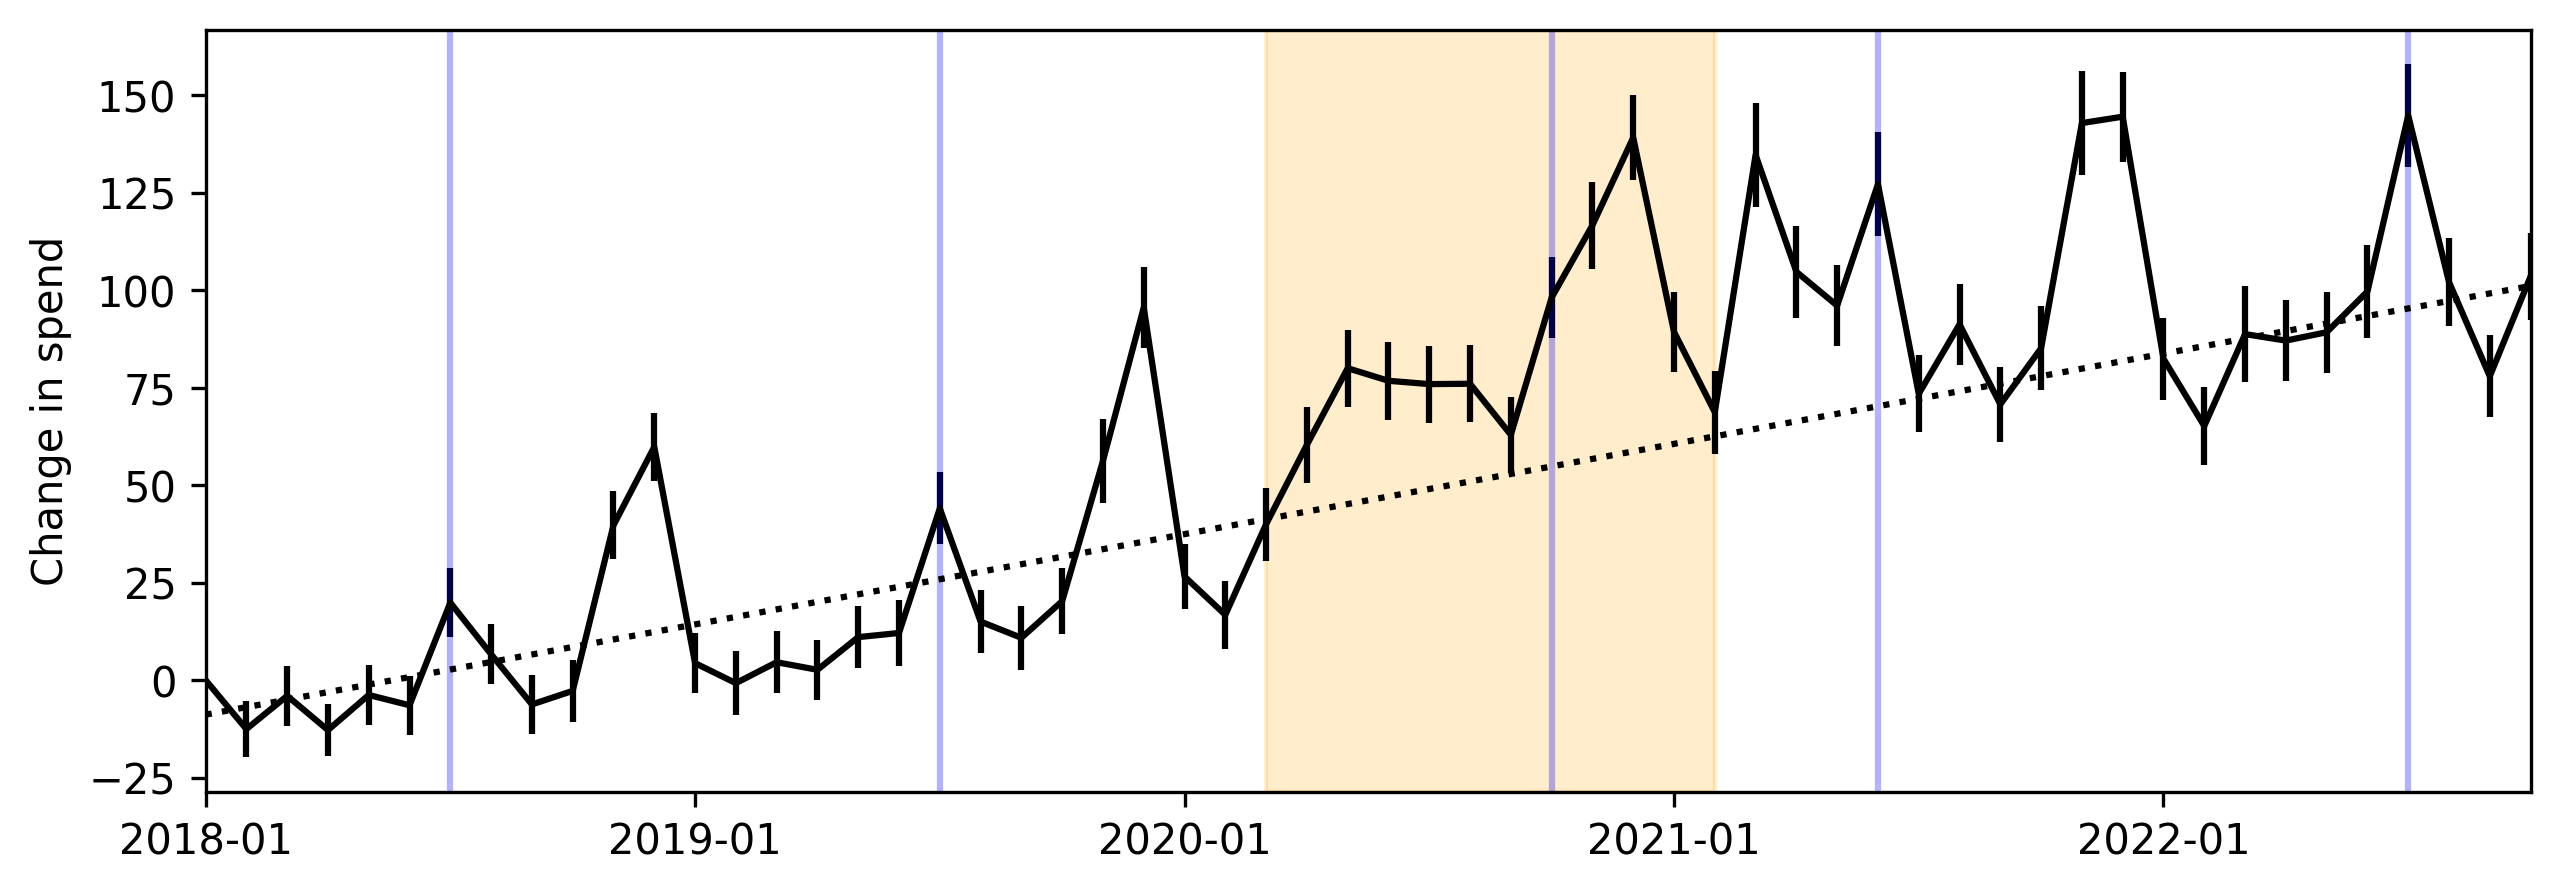

In [70]:
linear_fit_formula = 'coef ~ t'
pre_covid_coefs = p[p[YYYY_MM]<'2020-03']
post_covid_coefs = p[p[YYYY_MM] >= '2020-03']
linear_trend_model = smf.ols(linear_fit_formula, data=pre_covid_coefs).fit()
linear_trend_preds = linear_trend_model.predict(post_covid_coefs)
# x is yyyy_mm_idx
intercept = linear_trend_model.params[0]
trend = linear_trend_model.params[1]
linear_trend_y = [(intercept + trend*t) for t, _ym in enumerate(yyyy_mm_idx)]

fig, ax = plt.subplots(1,1, figsize=(10, 3.3), dpi=300)
ax.errorbar(x=YYYY_MM, y='coef', yerr = 'ci', data = p, color='black')
# show prime day months
[ax.axvline(x=m, ymin=0, color='blue', alpha=0.3) for m in amzn_prime_ms]
# show each 03
# [ax.axvline(x=m, ymin=0, color='orange', alpha=0.5, linestyle=':') for m in ['2018-03','2019-03','2021-03','2022-03']]
ax.set_xlim('2018-01', '2022-10')
ax.set_xticks(['2018-01', '2019-01', '2020-01', '2021-01', '2022-01'])
# ax.axvline(x='2020-03', ymin=0, linestyle='-', color='orange')
ax.axvspan('2020-03', '2021-02', alpha=0.2, color='orange')
ax.plot(linear_trend_y, color='black', linestyle=':')
print('Estimated change in spend per month')
_ = ax.set_ylabel('Change in spend')

linear_trend_model.summary()

For metric: purchase days

In [65]:
metric = 'purchase_days'
data = panel_m[[
    'ResponseID', metric, 't', YYYY_MM,
    'Sex', 
    #'Age6', 'Income6',
    'Age3', 'Income3',
]].dropna()
formula = formula_str.format(metric=metric)
print(formula)
model = smf.ols(formula, data=data)
# Fit with SEs clustered at the responseID
res = model.fit(cov_type = 'cluster',cov_kwds={'groups': data['ResponseID']})
res.summary()

purchase_days ~ C(t, Treatment(reference=0)) + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          purchase_days   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     56.65
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:45:48   Log-Likelihood:            -6.1201e+05
No. Observations:              229738   AIC:                         1.224e+06
Df Residuals:                  229675   BIC:                         1.225e+06
Df Model:                          62                                         
Covariance Type:              cluster                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       2.0990      0.096     21.930      0.000       1.911       2.287
C(t, Treatment(reference=0))[T.1]                                              -0.2588      0.032     -8.067      0.000      -0.322      -0.196
C(t, Treatment(reference=0))[T.2]                                              -0.0992      0.034     -2.906      0.004      -0.166      -0.032
C(t, Treatment(reference=0))[T.3]                                              -0.2010      0.035     -5.821      0.000      -0.269      -0.133
C(t, Treatment(reference=0))[T.4]                                              -0.0808      0.035     -2.305      0.021      -0.149      -0.012
C(t, Treatment(reference=0))[T.5]                                              -0.1497      0.036     -4.176      0.000      -0.220      -0.079
C(t, Treatment(reference=0))[T.6]                                               0.0725      0.038      1.883      0.060      -0.003       0.148
C(t, Treatment(reference=0))[T.7]                                               0.0558      0.039      1.442      0.149      -0.020       0.132
C(t, Treatment(reference=0))[T.8]                                              -0.1086      0.038     -2.849      0.004      -0.183      -0.034
C(t, Treatment(reference=0))[T.9]                                               0.0116      0.040      0.293      0.770      -0.066       0.089
C(t, Treatment(reference=0))[T.10]                                              0.3711      0.043      8.633      0.000       0.287       0.455
C(t, Treatment(reference=0))[T.11]                                              0.8664      0.046     19.023      0.000       0.777       0.956
C(t, Treatment(reference=0))[T.12]                                              0.2318      0.041      5.602      0.000       0.151       0.313
C(t, Treatment(reference=0))[T.13]                                             -0.0788      0.041     -1.930      0.054      -0.159       0.001
C(t, Treatment(reference=0))[T.14]                                              0.1580      0.043      3.655      0.000       0.073       0.243
C(t, Treatment(reference=0))[T.15]                                              0.0972      0.044      2.195      0.028       0.010       0.184
C(t, Treatment(reference=0))[T.16]                                              0.2194      0.043      5.076      0.000       0.135       0.304
C(t, Treatment(reference=0))[T.17]                                              0.2562      0.043      5.957      0.000       0.172       0.341
C(t, Treatment(reference=0))[T.18]                         

In [102]:
# Get the t related variables
t_coef_names = ['Intercept'] + [coef for coef in res.params.index if coef.startswith('C(t')]
t_coefs = res.params.loc[t_coef_names]
p = pd.DataFrame({
    't':list(range(len(t_coefs))),
    'coef': t_coefs, 
    'se': res.bse.loc[t_coef_names], 
})
p.iloc[0] = [0, 0, 0] # get rid of the intercent and set reference t values to 0
p['ci'] = 1.96*p['se']
p[YYYY_MM] = yyyy_mm_idx
p.head()

t      coef        se        ci  yyyy-mm
Intercept                          0  0.000000  0.000000  0.000000  2018-01
C(t, Treatment(reference=0))[T.1]  1 -0.258773  0.032080  0.062876  2018-02
C(t, Treatment(reference=0))[T.2]  2 -0.099217  0.034144  0.066923  2018-03
C(t, Treatment(reference=0))[T.3]  3 -0.200959  0.034523  0.067666  2018-04
C(t, Treatment(reference=0))[T.4]  4 -0.080788  0.035051  0.068701  2018-05

Estimated change in purchase days per month


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coef   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     34.70
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           4.46e-06
Time:                        13:43:47   Log-Likelihood:               -0.50719
No. Observations:                  26   AIC:                             5.014
Df Residuals:                      24   BIC:                             7.531
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2362      0.098     -2.413      0.024      -0.438      -0.034
t              0.0396      0.007      5.891      0.000       0.026       0.053
==============================================================================
Omnibus:                       16.372   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.758
Skew:                           1.578   Prob(JB):                     0.000139
Kurtosis:                       5.536   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

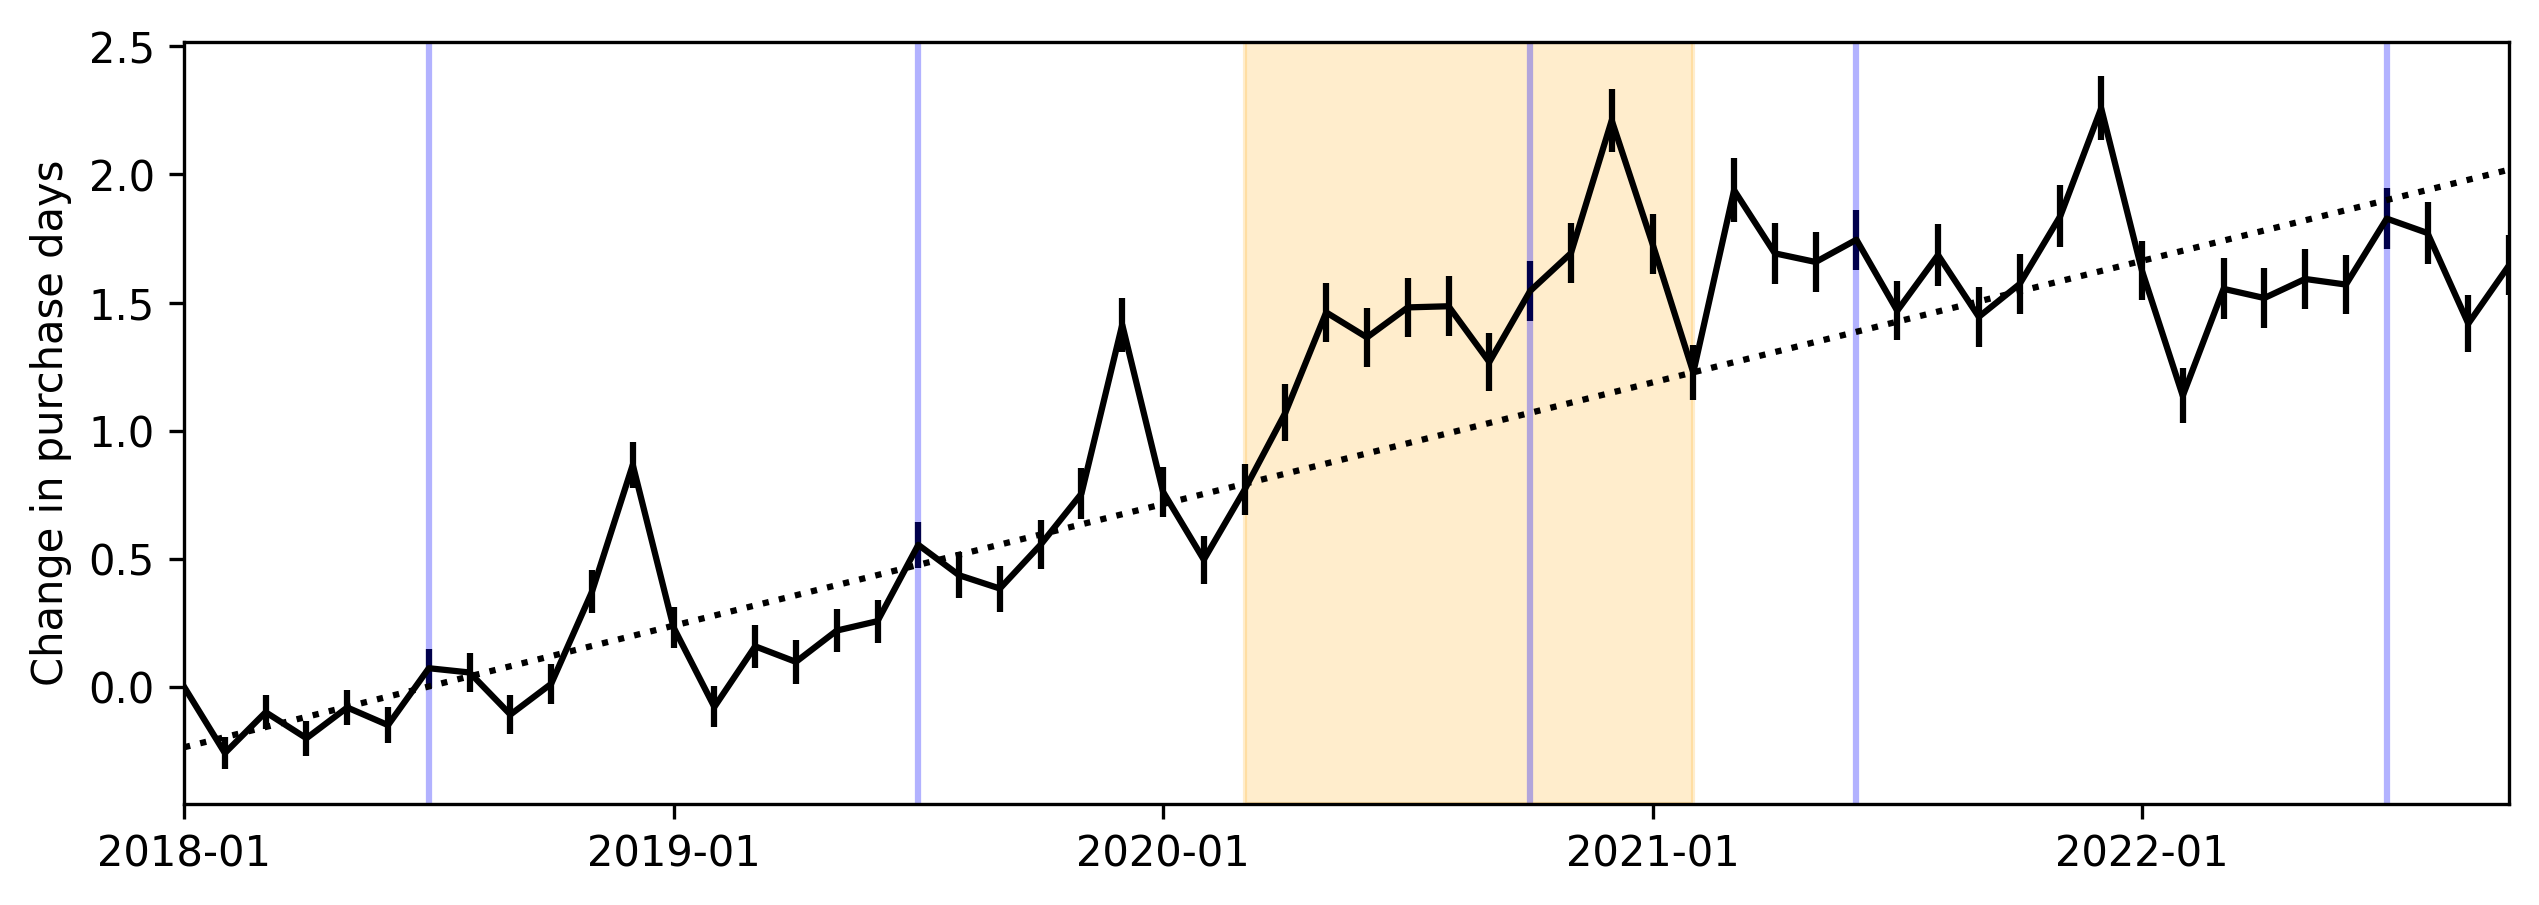

In [104]:
linear_fit_formula = 'coef ~ t'
pre_covid_coefs = p[p[YYYY_MM]<'2020-03']
post_covid_coefs = p[p[YYYY_MM] >= '2020-03']
linear_trend_model = smf.ols(linear_fit_formula, data=pre_covid_coefs).fit()
linear_trend_preds = linear_trend_model.predict(post_covid_coefs)
# x is yyyy_mm_idx
intercept = linear_trend_model.params[0]
trend = linear_trend_model.params[1]
linear_trend_y = [(intercept + trend*t) for t, _ym in enumerate(yyyy_mm_idx)]

fig, ax = plt.subplots(1,1, figsize=(10, 3.3), dpi=300)
ax.errorbar(x=YYYY_MM, y='coef', yerr = 'ci', data = p, color='black')
# show prime day months
[ax.axvline(x=m, ymin=0, color='blue', alpha=0.3) for m in amzn_prime_ms]
# show each 03
# [ax.axvline(x=m, ymin=0, color='orange', alpha=0.5, linestyle=':') for m in ['2018-03','2019-03','2021-03','2022-03']]
ax.set_xlim('2018-01', '2022-10')
ax.set_xticks(['2018-01', '2019-01', '2020-01', '2021-01', '2022-01'])
# ax.axvline(x='2020-03', ymin=0, linestyle='-', color='orange')
ax.axvspan('2020-03', '2021-02', alpha=0.2, color='orange')
ax.plot(linear_trend_y, color='black', linestyle=':')
print('Estimated change in purchase days per month')
_ = ax.set_ylabel('Change in purchase days')

linear_trend_model.summary()

Do the same for products

In [105]:
metric = 'products'
data = panel_m[[
    'ResponseID', metric, 't', YYYY_MM, 
    'Sex', 
    #'Age6', 'Income6',
    'Age3', 'Income3',
]].dropna()
formula = formula_str.format(metric=metric)
print(formula)
model = smf.ols(formula, data=data)
# Fit with SEs clustered at the responseID
res = model.fit(cov_type = 'cluster',cov_kwds={'groups': data['ResponseID']})
res.summary()

products ~ C(t, Treatment(reference=0)) + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               products   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     40.94
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        13:52:24   Log-Likelihood:            -8.5053e+05
No. Observations:              229738   AIC:                         1.701e+06
Df Residuals:                  229675   BIC:                         1.702e+06
Df Model:                          62                                         
Covariance Type:              cluster                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       4.2369      0.243     17.421      0.000       3.760       4.714
C(t, Treatment(reference=0))[T.1]                                              -0.5786      0.096     -6.001      0.000      -0.768      -0.390
C(t, Treatment(reference=0))[T.2]                                              -0.2047      0.101     -2.029      0.043      -0.403      -0.007
C(t, Treatment(reference=0))[T.3]                                              -0.5289      0.098     -5.401      0.000      -0.721      -0.337
C(t, Treatment(reference=0))[T.4]                                              -0.3163      0.104     -3.035      0.002      -0.521      -0.112
C(t, Treatment(reference=0))[T.5]                                              -0.4279      0.102     -4.196      0.000      -0.628      -0.228
C(t, Treatment(reference=0))[T.6]                                               0.1835      0.111      1.654      0.098      -0.034       0.401
C(t, Treatment(reference=0))[T.7]                                               0.0823      0.110      0.751      0.452      -0.132       0.297
C(t, Treatment(reference=0))[T.8]                                              -0.3739      0.102     -3.661      0.000      -0.574      -0.174
C(t, Treatment(reference=0))[T.9]                                              -0.2275      0.113     -2.017      0.044      -0.449      -0.006
C(t, Treatment(reference=0))[T.10]                                              1.0412      0.132      7.871      0.000       0.782       1.300
C(t, Treatment(reference=0))[T.11]                                              2.3903      0.140     17.130      0.000       2.117       2.664
C(t, Treatment(reference=0))[T.12]                                              0.2219      0.116      1.909      0.056      -0.006       0.450
C(t, Treatment(reference=0))[T.13]                                             -0.3249      0.122     -2.663      0.008      -0.564      -0.086
C(t, Treatment(reference=0))[T.14]                                              0.1419      0.125      1.131      0.258      -0.104       0.388
C(t, Treatment(reference=0))[T.15]                                             -0.0422      0.120     -0.351      0.726      -0.278       0.193
C(t, Treatment(reference=0))[T.16]                                              0.2376      0.119      1.995      0.046       0.004       0.471
C(t, Treatment(reference=0))[T.17]                                              0.3327      0.121      2.740      0.006       0.095       0.571
C(t, Treatment(reference=0))[T.18]                         

In [106]:
# Get the t related variables
t_coef_names = ['Intercept'] + [coef for coef in res.params.index if coef.startswith('C(t')]
t_coefs = res.params.loc[t_coef_names]
p = pd.DataFrame({
    't':list(range(len(t_coefs))),
    'coef': t_coefs, 
    'se': res.bse.loc[t_coef_names], 
})
p.iloc[0] = [0, 0, 0] # get rid of the intercent and set reference t values to 0
p['ci'] = 1.96*p['se']
p[YYYY_MM] = yyyy_mm_idx
p.head()

t      coef        se        ci  yyyy-mm
Intercept                          0  0.000000  0.000000  0.000000  2018-01
C(t, Treatment(reference=0))[T.1]  1 -0.578642  0.096420  0.188983  2018-02
C(t, Treatment(reference=0))[T.2]  2 -0.204746  0.100934  0.197831  2018-03
C(t, Treatment(reference=0))[T.3]  3 -0.528907  0.097927  0.191937  2018-04
C(t, Treatment(reference=0))[T.4]  4 -0.316334  0.104231  0.204292  2018-05

Estimated monthly change in distinct products purchased


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coef   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     17.88
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           0.000296
Time:                        13:52:32   Log-Likelihood:                -29.958
No. Observations:                  26   AIC:                             63.92
Df Residuals:                      24   BIC:                             66.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5917      0.304     -1.947      0.063      -1.219       0.035
t              0.0881      0.021      4.228      0.000       0.045       0.131
==============================================================================
Omnibus:                       18.722   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.105
Skew:                           1.751   Prob(JB):                     1.58e-05
Kurtosis:                       5.854   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

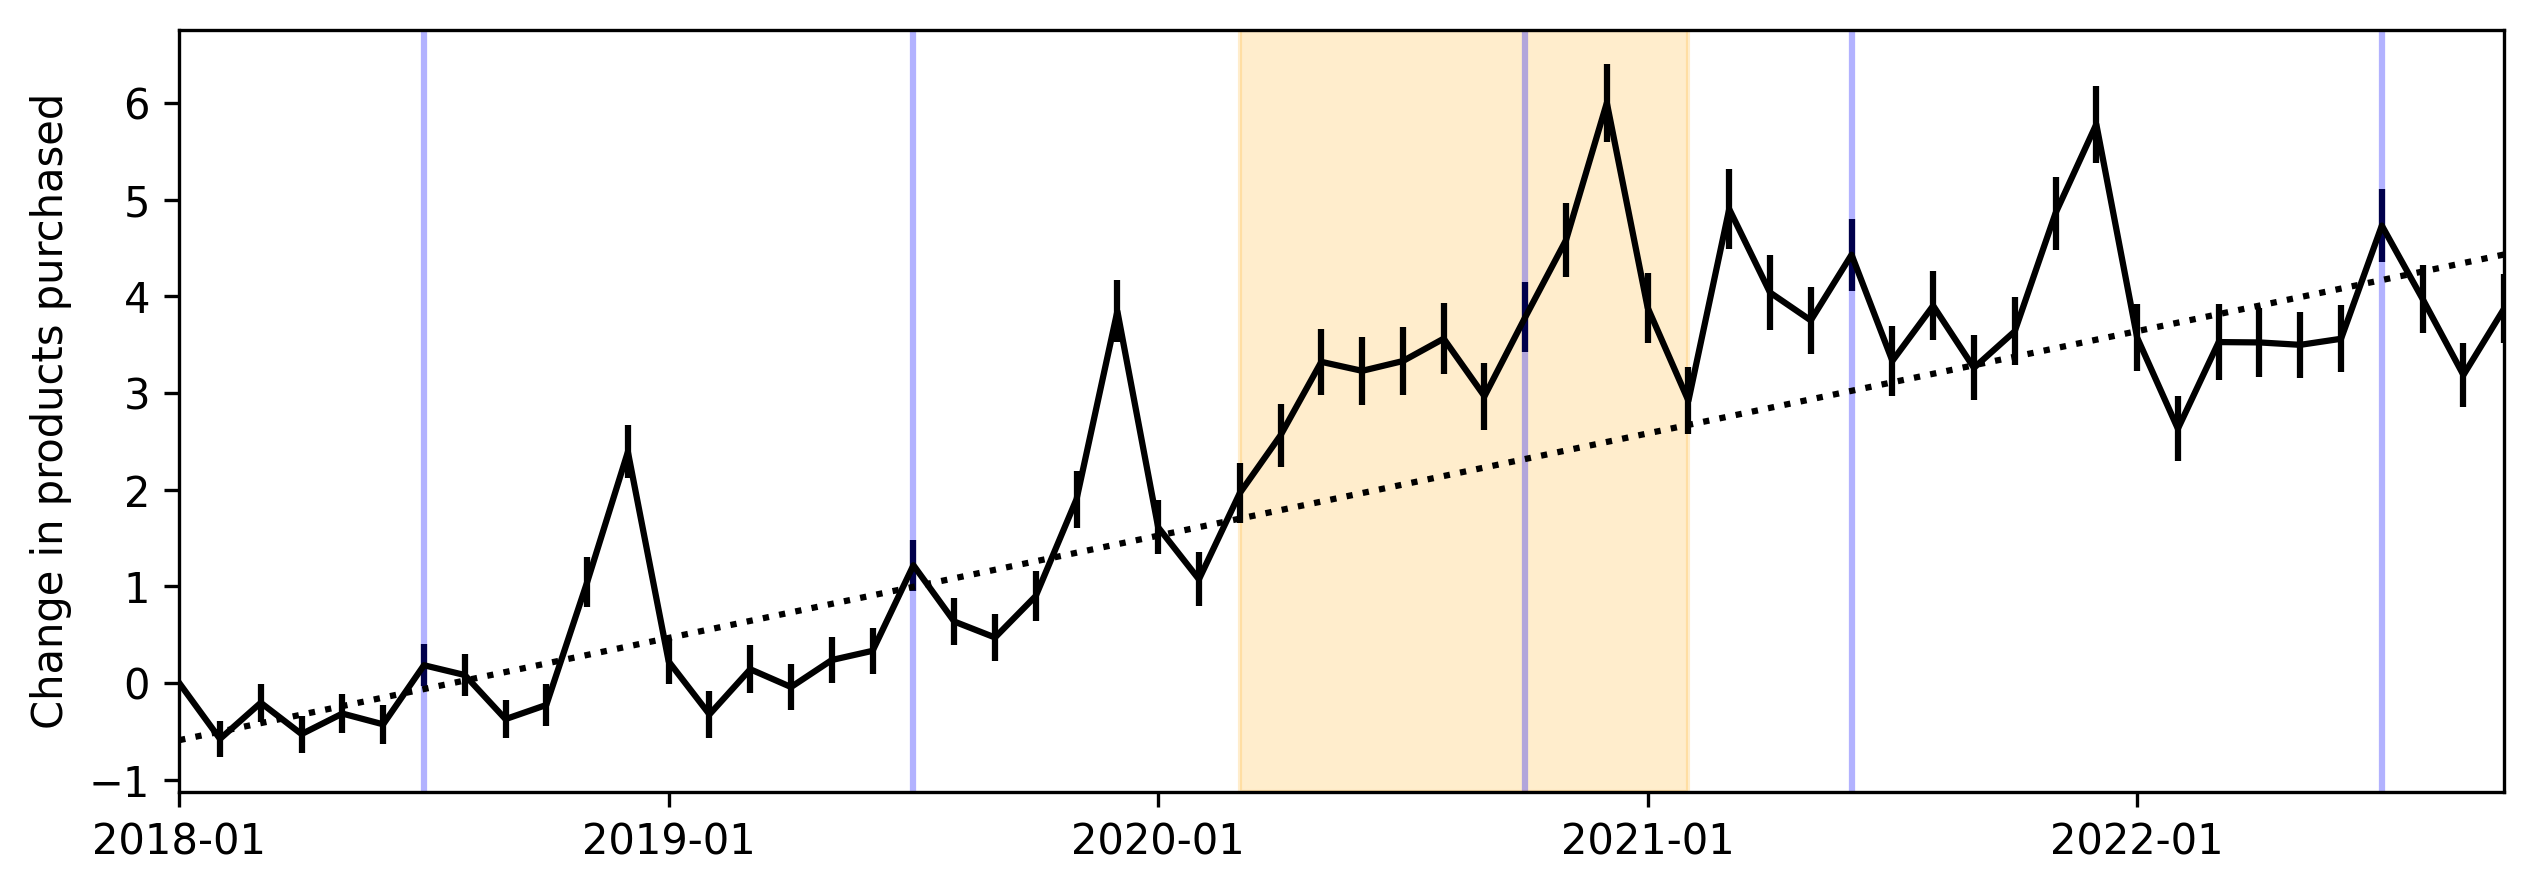

In [108]:
linear_fit_formula = 'coef ~ t'
pre_covid_coefs = p[p[YYYY_MM]<'2020-03']
post_covid_coefs = p[p[YYYY_MM] >= '2020-03']
linear_trend_model = smf.ols(linear_fit_formula, data=pre_covid_coefs).fit()
linear_trend_preds = linear_trend_model.predict(post_covid_coefs)
# x is yyyy_mm_idx
intercept = linear_trend_model.params[0]
trend = linear_trend_model.params[1]
linear_trend_y = [(intercept + trend*t) for t, _ym in enumerate(yyyy_mm_idx)]

fig, ax = plt.subplots(1,1, figsize=(10, 3.3), dpi=300)
ax.errorbar(x=YYYY_MM, y='coef', yerr = 'ci', data = p, color='black')
# show prime day months
[ax.axvline(x=m, ymin=0, color='blue', alpha=0.3) for m in amzn_prime_ms]
# show each 03
# [ax.axvline(x=m, ymin=0, color='orange', alpha=0.5, linestyle=':') for m in ['2018-03','2019-03','2021-03','2022-03']]
ax.set_xlim('2018-01', '2022-10')
ax.set_xticks(['2018-01', '2019-01', '2020-01', '2021-01', '2022-01'])
# ax.axvline(x='2020-03', ymin=0, linestyle='-', color='orange')
ax.axvspan('2020-03', '2021-02', alpha=0.2, color='orange')
ax.plot(linear_trend_y, color='black', linestyle=':')
print('Estimated monthly change in distinct products purchased')
_ = ax.set_ylabel('Change in products purchased')

linear_trend_model.summary()

### Event study with regression to measure significance of COVID

metric[i, t] = a[i] + B1 x t + B2 x postCovid + month[t] + B3 x X + e[i]

- postCOVID: 1 if 2020-03 or later; 0 otherwise
- X: vector representing user demographics: Sex, Age, Income

Here we are testing for the statistical significance of the postCOVID variable

We limit the study to dates before 2021-03. This way we are comparing the periods:
- Before COVID: 2018-01 to 2020-02
- First year of COVID: 2020-03 to 2021-02



In [110]:
formula_str = '{metric} ~ t + postCovid'
formula_str += ' + C(month)'
formula_str += (' + ' + formula_covariates_age_sex_inc_str)
print(formula_str + '\n')
metric = 'purchase_days'
data = panel_m[[
    'ResponseID', metric, 't', YYYY_MM, 'month',
    'postCovid',
    'Sex', 
    #'Age6', 'Income6',
    'Age3', 'Income3',
]].dropna()
data = data[data[YYYY_MM] < '2021-03']
formula = formula_str.format(metric=metric)
print(formula)
model = smf.ols(formula, data=data)
# Fit with SEs clustered at the responseID
res = model.fit(cov_type = 'cluster', cov_kwds={'groups': data['ResponseID']})
res.summary()

{metric} ~ t + postCovid + C(month) + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))

purchase_days ~ t + postCovid + C(month) + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          purchase_days   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     157.3
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:04:32   Log-Likelihood:            -3.8933e+05
No. Observations:              150518   AIC:                         7.787e+05
Df Residuals:                  150499   BIC:                         7.789e+05
Df Model:                          18                                         
Covariance Type:              cluster                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       2.0878      0.089     23.562      0.000       1.914       2.261
C(month)[T.02]                                                                 -0.3667      0.019    -19.225      0.000      -0.404      -0.329
C(month)[T.03]                                                                 -0.3206      0.024    -13.503      0.000      -0.367      -0.274
C(month)[T.04]                                                                 -0.3071      0.024    -13.022      0.000      -0.353      -0.261
C(month)[T.05]                                                                 -0.1284      0.023     -5.586      0.000      -0.174      -0.083
C(month)[T.06]                                                                 -0.2043      0.023     -8.843      0.000      -0.250      -0.159
C(month)[T.07]                                                                 -0.0245      0.024     -1.032      0.302      -0.071       0.022
C(month)[T.08]                                                                 -0.1007      0.024     -4.268      0.000      -0.147      -0.054
C(month)[T.09]                                                                 -0.2780      0.022    -12.420      0.000      -0.322      -0.234
C(month)[T.10]                                                                 -0.1209      0.023     -5.321      0.000      -0.165      -0.076
C(month)[T.11]                                                                  0.0819      0.025      3.318      0.001       0.034       0.130
C(month)[T.12]                                                                  0.6069      0.026     23.407      0.000       0.556       0.658
C(Sex, Treatment(reference='Male'))[T.Female]                                   0.4574      0.077      5.945      0.000       0.307       0.608
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                 -0.8400      0.084    -10.053      0.000      -1.004      -0.676
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                  -0.1442      0.131     -1.101      0.271      -0.401       0.112
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]      0.9046      0.107      8.417      0.000       0.694       1.115
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]    -0.5181      0.082     -6.351      0.000      -0.678      -0.358
t                                                                               0.0326      0.002     19.727      0.000       0.029       0.036
postCovid                                                  

## Regression analyses measuring relationships between metrics and demographics


### Regression analysis helper functions

In [169]:
def format_res_str(row):
    stars = ('*' if row['p-value']<0.05 else '')
    stars += ('*' if row['p-value']<0.01 else '')
    stars += ('*' if row['p-value']<0.001 else '')
    return '%0.3f%s (%0.3f)'%(row['coef'], stars, row['SE'])

def get_res_table(res):
    d = res.params.rename('coef').to_frame()
    d['SE'] = res.bse
    d['p-value'] = res.pvalues
    d['CI_lower'] = res.conf_int()[0]
    d['CI_upper'] = res.conf_int()[1]
    d['CI'] = d.apply(lambda row: (row['CI_lower'], row['CI_upper']), axis=1)
    d['formatted'] = d.apply(format_res_str, axis=1)
    return d.drop(['CI_lower', 'CI_upper'], axis=1)

def get_plt_res_table(res):
    d = get_res_table(res)
    d['*'] = d['p-value'].apply(lambda p: p<0.05)
    return d

### Analyze change in monthly metrics

Make a table keyed by responseID, where each column is for the time period of study.
Each column is computed as the monthly median across the period.

```
responseID, 2018, 2022, pre-COVID, COVID, post-COVID, [covariates]
```

- 2018 and 2022 limited to months that exclude November, December


- changes

#### When measuring change, we first measure the metric summed across the period, rather than the median

This is necessary to avoid many 0's.

##### 2018 to 2022
Excluding Nov, Dec months


##### COVID change
12 months pre-COVID to 12 months of COVID: Measured as percent change from over (2019-03 to 2020-02) to over (2020-03 to 2021-02) 


In [170]:
m_rids_idx = pd.MultiIndex.from_product([resp_ids, list(range(1, 11))], names=[RESPONSE_ID, MONTH])

def get_med_monthly_purchase_days(df):
    return (
        df.groupby([RESPONSE_ID, MONTH])[DATE].nunique().reindex(m_rids_idx).fillna(0)
        .reset_index()
        .groupby(RESPONSE_ID)[DATE].median()
    )

def get_total_purchase_days(df):
    return (
        df.groupby([RESPONSE_ID])[DATE].nunique().reindex(resp_ids).fillna(0)
    )

def get_med_monthly_products(df):
    return (
        df.groupby([RESPONSE_ID, MONTH])[PRODUCT_CODE].nunique().reindex(m_rids_idx).fillna(0)
        .reset_index()
        .groupby(RESPONSE_ID)[PRODUCT_CODE].median()
    )

def get_total_products(df):
    return (
        df.groupby([RESPONSE_ID])[PRODUCT_CODE].nunique().reindex(resp_ids).fillna(0)
    )

In [171]:
def get_pct_change(col1, col2):
    return 100*((col2 - col1)/col1).fillna(0)

In [172]:
df = amzn_data
exclude_months = [11, 12]
m_purchase_days = pd.DataFrame({
    '2018': get_med_monthly_purchase_days(df[(df[YEAR]==2018) & (~df[MONTH].isin(exclude_months))]),
    '2022': get_med_monthly_purchase_days(df[(df[YEAR]==2022) & (~df[MONTH].isin(exclude_months))]),
    '2018 total': get_total_purchase_days(
        df[(df[YEAR]==2018) & (~df[MONTH].isin(exclude_months))]
    ),
    '2022 total': get_total_purchase_days(
        df[(df[YEAR]==2022) & (~df[MONTH].isin(exclude_months))]
    ),
    '2019-03 to 2020-02': get_total_purchase_days(
        df[(df[YYYY_MM]>='2019-03') & (df[YYYY_MM]<='2020-02')]
    ),
    '2020-03 to 2021-02': get_total_purchase_days(
        df[(df[YYYY_MM]>='2020-03') & (df[YYYY_MM]<='2021-02')]
    )
})
m_purchase_days['2018 to 2022 change'] = get_pct_change(
    m_purchase_days['2018 total'], m_purchase_days['2022 total']
)
m_purchase_days['COVID change'] = get_pct_change(
    m_purchase_days['2019-03 to 2020-02'], m_purchase_days['2020-03 to 2021-02']
)
m_purchase_days = pd.merge(m_purchase_days, survey_df, left_index=True, right_index=True)
m_purchase_days.head()

2018  2022  2018 total  2022 total  2019-03 to 2020-02   
Survey ResponseID                                                           
R_01vNIayewjIIKMF   0.0   0.0         0.0           6                33.0  \
R_037XK72IZBJyF69   1.5   7.0        19.0          65                30.0   
R_038ZU6kfQ5f89fH   0.0   0.0         0.0           2                 4.0   
R_03aEbghUILs9NxD   0.0   0.0         6.0           6                15.0   
R_06RZP9pS7kONINr   1.5   2.0        15.0          27                21.0   

                   2020-03 to 2021-02  2018 to 2022 change  COVID change   
Survey ResponseID                                                          
R_01vNIayewjIIKMF                12.0                  inf    -63.636364  \
R_037XK72IZBJyF69                90.0           242.105263    200.000000   
R_038ZU6kfQ5f89fH                 8.0                  inf    100.000000   
R_03aEbghUILs9NxD                 2.0             0.000000    -86.666667   
R_06RZP9pS7kONINr                35.0            80.000000     66.666667   

                            Age6 Hispanic  ...  Black  Other lost_job divorce   
Survey ResponseID                          ...                                  
R_01vNIayewjIIKMF  35 - 44 years      Yes  ...   True  False    False   False  \
R_037XK72IZBJyF69  55 - 64 years       No  ...  False  False    False   False   
R_038ZU6kfQ5f89fH  25 - 34 years       No  ...  False  False     True   False   
R_03aEbghUILs9NxD  35 - 44 years       No  ...  False  False    False   False   
R_06RZP9pS7kONINr   65 and older       No  ...  False  False    False   False   

                   moved pregnant had_child     Region     Sex  wheelchair  
Survey ResponseID                                                           
R_01vNIayewjIIKMF  False    False     False  Northeast    Male          No  
R_037XK72IZBJyF69  False    False     False  Northeast  Female          No  
R_038ZU6kfQ5f89fH  False    False     False       West    Male          No  
R_03aEbghUILs9NxD  False    False     False      South    Male          No  
R_06RZP9pS7kONINr   True    False     False    Midwest  Female          No  

[5 rows x 30 columns]

In [173]:
print('We do not use this -- we do not do the complete analysis for distinct products purchased')
m_products = pd.DataFrame({
    '2018': get_med_monthly_products(df[(df[YEAR]==2018) & (~df[MONTH].isin(exclude_months))]),
    '2022': get_med_monthly_products(df[(df[YEAR]==2022) & (~df[MONTH].isin(exclude_months))]),
    '2018 total': get_total_products(
        df[(df[YEAR]==2018) & (~df[MONTH].isin(exclude_months))]
    ),
    '2022 total': get_total_products(
        df[(df[YEAR]==2022) & (~df[MONTH].isin(exclude_months))]
    ),
    '2019-03 to 2020-02': get_total_products(
        df[(df[YYYY_MM]>='2019-03') & (df[YYYY_MM]<='2020-02')]
    ),
    '2020-03 to 2021-02': get_total_products(
        df[(df[YYYY_MM]>='2020-03') & (df[YYYY_MM]<='2021-02')]
    )
})
m_products['2018 to 2022 change'] = get_pct_change(
    m_products['2018 total'], m_products['2022 total']
)
m_products['COVID change'] = get_pct_change(
    m_products['2019-03 to 2020-02'], m_products['2020-03 to 2021-02']
)
m_products = pd.merge(m_products, survey_df, left_index=True, right_index=True)
# m_products.head(3)

We do not use this -- we do not do the complete analysis for distinct products purchased


In [174]:
formula_covariates = "C(Sex, Treatment(reference='Male'))"
# # actually higher p-value when use more specific ages
# # formula_covariates += " + C(Age6, Treatment(reference='35 - 44 years'))"
formula_covariates += " + C(Age3, Treatment(reference='35 - 54 years'))"
# # formula_covariates += " + C(Income6, Treatment(reference='$75,000 - $99,999'))"
formula_covariates += " + C(Income3, Treatment(reference='\$50,000 - \$99,999'))"
# # formula_covariates += " + Region" # tiny impact on R-squared; using state instead raises by >0.01
formula_covariates += " + state" # tiny impact on R-squared; using state instead raises > 0.01
formula_covariates += " + White + Hispanic + Black + Asian"
# # formula_covariates += " + White + Hispanic + Black + Asian + Other"
# # formula_covariates += " + education" Doesn't increase adj R-squared and no stat.significance
formula_covariates += " + C(hh_size, Treatment(reference='2'))"

In [175]:
formula = "metric ~ " + formula_covariates
data = m_purchase_days.rename(columns={'2018': 'metric'})
print(formula)
freq_res2018 = smf.ols(formula=formula, data=data).fit()
freq_res2018.summary()

metric ~ C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999')) + state + White + Hispanic + Black + Asian + C(hh_size, Treatment(reference='2'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     5.903
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           7.78e-43
Time:                        13:17:19   Log-Likelihood:                -8717.6
No. Observations:                3961   AIC:                         1.756e+04
Df Residuals:                    3897   BIC:                         1.797e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       1.7103      0.346      4.944      0.000       1.032       2.389
C(Sex, Treatment(reference='Male'))[T.Female]                                   0.2500      0.071      3.516      0.000       0.111       0.389
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                 -0.6467      0.077     -8.358      0.000      -0.798      -0.495
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                  -0.0485      0.119     -0.407      0.684      -0.282       0.185
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]      0.6653      0.091      7.323      0.000       0.487       0.843
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]    -0.3672      0.085     -4.337      0.000      -0.533      -0.201
state[T.Alaska]                                                                -0.5420      0.948     -0.572      0.567      -2.400       1.316
state[T.Arizona]                                                               -0.1786      0.395     -0.452      0.651      -0.953       0.596
state[T.Arkansas]                                                               0.9291      0.484      1.918      0.055      -0.020       1.879
state[T.California]                                                             0.1950      0.318      0.612      0.540      -0.429       0.819
state[T.Colorado]                                                               0.1469      0.392      0.375      0.708      -0.622       0.915
state[T.Connecticut]                                                            0.2490      0.484      0.514      0.607      -0.701       1.199
state[T.Delaware]                                                               1.2162      0.702      1.733      0.083      -0.160       2.592
state[T.District of Columbia]                                                   1.4949      0.679      2.200      0.028       0.163       2.827
state[T.Florida]                                                                0.2282      0.327      0.698      0.485      -0.413       0.869
state[T.Georgia]                                                                0.0572      0.355      0.161      0.872      -0.639       0.753
state[T.Hawaii]                                                                -0.3201      0.618     -0.518      0.605      -1.532       0.892
state[T.I did not reside in the United States]                                 -0.3523      1.592     -0.221      0.825      -3.473       2.769
state[T.Idaho]                                             

In [176]:
formula = "metric ~ " + formula_covariates
data = m_purchase_days.rename(columns={'2022': 'metric'})
print(formula)
freq_res2022 = smf.ols(formula=formula, data=data).fit()
freq_res2022.summary()

metric ~ C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999')) + state + White + Hispanic + Black + Asian + C(hh_size, Treatment(reference='2'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     7.534
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           4.60e-60
Time:                        13:17:19   Log-Likelihood:                -10371.
No. Observations:                3961   AIC:                         2.087e+04
Df Residuals:                    3897   BIC:                         2.127e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       2.3378      0.525      4.451      0.000       1.308       3.368
C(Sex, Treatment(reference='Male'))[T.Female]                                   0.8193      0.108      7.591      0.000       0.608       1.031
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                 -0.8074      0.117     -6.874      0.000      -1.038      -0.577
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                  -0.0821      0.181     -0.453      0.650      -0.437       0.273
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]      0.9951      0.138      7.214      0.000       0.725       1.265
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]    -0.6767      0.129     -5.264      0.000      -0.929      -0.425
state[T.Alaska]                                                                -0.5899      1.439     -0.410      0.682      -3.411       2.231
state[T.Arizona]                                                                0.2629      0.600      0.438      0.661      -0.913       1.439
state[T.Arkansas]                                                               0.3114      0.735      0.424      0.672      -1.130       1.753
state[T.California]                                                             0.8680      0.483      1.795      0.073      -0.080       1.816
state[T.Colorado]                                                               0.1900      0.595      0.319      0.750      -0.977       1.357
state[T.Connecticut]                                                            0.2804      0.735      0.381      0.703      -1.162       1.722
state[T.Delaware]                                                               2.1544      1.065      2.022      0.043       0.066       4.243
state[T.District of Columbia]                                                   2.5063      1.032      2.430      0.015       0.484       4.529
state[T.Florida]                                                                0.7896      0.496      1.591      0.112      -0.184       1.763
state[T.Georgia]                                                                0.6626      0.539      1.230      0.219      -0.394       1.719
state[T.Hawaii]                                                                -0.4519      0.938     -0.482      0.630      -2.292       1.388
state[T.I did not reside in the United States]                                 -2.1273      2.417     -0.880      0.379      -6.865       2.611
state[T.Idaho]                                             

In [177]:
formula = "metric ~ " + formula_covariates
data = m_purchase_days.rename(columns={'2018 to 2022 change': 'metric'}).replace([np.inf, -np.inf], np.nan)
print(formula)
freq_chg_20182022 = smf.ols(formula=formula, data=data).fit()
freq_chg_20182022.summary()

metric ~ C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999')) + state + White + Hispanic + Black + Asian + C(hh_size, Treatment(reference='2'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.375
Date:                Tue, 01 Oct 2024   Prob (F-statistic):             0.0270
Time:                        13:17:19   Log-Likelihood:                -30677.
No. Observations:                3792   AIC:                         6.148e+04
Df Residuals:                    3728   BIC:                         6.188e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      56.1538    128.563      0.437      0.662    -195.907     308.214
C(Sex, Treatment(reference='Male'))[T.Female]                                  78.6119     26.239      2.996      0.003      27.168     130.056
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                 47.2164     28.652      1.648      0.099      -8.958     103.391
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                 -21.9140     43.626     -0.502      0.615    -107.448      63.620
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]    -78.6988     33.417     -2.355      0.019    -144.216     -13.181
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]    -7.2964     31.374     -0.233      0.816     -68.808      54.215
state[T.Alaska]                                                                33.2463    372.968      0.089      0.929    -697.995     764.488
state[T.Arizona]                                                               47.4227    145.845      0.325      0.745    -238.521     333.367
state[T.Arkansas]                                                              -1.5777    176.769     -0.009      0.993    -348.152     344.996
state[T.California]                                                            94.4681    118.196      0.799      0.424    -137.266     326.202
state[T.Colorado]                                                              54.9858    145.094      0.379      0.705    -229.487     339.458
state[T.Connecticut]                                                          -42.5694    176.806     -0.241      0.810    -389.215     304.076
state[T.Delaware]                                                            -111.3282    254.733     -0.437      0.662    -610.758     388.102
state[T.District of Columbia]                                                   0.1959    246.718      0.001      0.999    -483.520     483.912
state[T.Florida]                                                              140.0262    121.278      1.155      0.248     -97.752     377.805
state[T.Georgia]                                                              153.3572    131.652      1.165      0.244    -104.760     411.475
state[T.Hawaii]                                                                42.9420    224.889      0.191      0.849    -397.976     483.860
state[T.I did not reside in the United States]                                291.5287    575.709      0.506      0.613    -837.207    1420.265
state[T.Idaho]                                             

In [178]:
# when using age3 there is a stat. difference for oldest age group
# showing oldest age group did not drive change
formula = "metric ~ " + formula_covariates
data = m_purchase_days.rename(columns={'COVID change': 'metric'}).replace([np.inf, -np.inf], np.nan)
print(formula)
freq_chg_covid = smf.ols(formula=formula, data=data).fit()
freq_chg_covid.summary()

metric ~ C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999')) + state + White + Hispanic + Black + Asian + C(hh_size, Treatment(reference='2'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.209
Date:                Tue, 01 Oct 2024   Prob (F-statistic):              0.126
Time:                        13:17:19   Log-Likelihood:                -27360.
No. Observations:                3862   AIC:                         5.485e+04
Df Residuals:                    3798   BIC:                         5.525e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      84.4685     47.150      1.791      0.073      -7.974     176.911
C(Sex, Treatment(reference='Male'))[T.Female]                                   7.6282      9.517      0.802      0.423     -11.031      26.288
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                -11.6364     10.366     -1.123      0.262     -31.959       8.686
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                 -44.9681     15.930     -2.823      0.005     -76.200     -13.737
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]    -22.1327     12.125     -1.825      0.068     -45.906       1.640
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]     3.4021     11.353      0.300      0.764     -18.856      25.660
state[T.Alaska]                                                                -5.3573    125.674     -0.043      0.966    -251.753     241.038
state[T.Arizona]                                                               10.2911     53.805      0.191      0.848     -95.198     115.781
state[T.Arkansas]                                                             -42.4719     64.882     -0.655      0.513    -169.679      84.736
state[T.California]                                                            33.8528     43.527      0.778      0.437     -51.485     119.190
state[T.Colorado]                                                              36.0471     53.054      0.679      0.497     -67.970     140.064
state[T.Connecticut]                                                          -42.1102     65.519     -0.643      0.520    -170.565      86.345
state[T.Delaware]                                                             -79.7657     93.334     -0.855      0.393    -262.756     103.224
state[T.District of Columbia]                                                 -41.3537     90.415     -0.457      0.647    -218.621     135.913
state[T.Florida]                                                               12.4987     44.626      0.280      0.779     -74.995      99.992
state[T.Georgia]                                                               49.5741     48.294      1.026      0.305     -45.111     144.260
state[T.Hawaii]                                                                35.1636     82.419      0.427      0.670    -126.426     196.753
state[T.I did not reside in the United States]                                 30.1207    294.199      0.102      0.918    -546.683     606.924
state[T.Idaho]                                             

### Plots

In [179]:
idx_map = {
    'Intercept': 'Intercept', 
    "C(Sex, Treatment(reference='Male'))[T.Female]": 'Female',
    "C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]": '18 - 34 yrs',
    "C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]": '55+',
    "C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]": '$100k or more',
    "C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]": 'Less than $50k',
    'White[T.True]': 'White', 
    'Hispanic[T.Yes]': 'Hispanic', 
    'Black[T.True]': 'Black', 
    'Asian[T.True]': 'Asian', 
    "C(hh_size, Treatment(reference='2'))[T.1 (just me!)]": '1 (single)',
    "C(hh_size, Treatment(reference='2'))[T.3]": '3',
    "C(hh_size, Treatment(reference='2'))[T.4+]": '4+'
}

In [180]:
# get the table for plotting
plt_freq_res_tab = pd.merge(
    get_plt_res_table(freq_res2018), get_plt_res_table(freq_res2022), 
    left_index=True, right_index=True, suffixes=['_2018', '_2022']
).rename(idx_map)
plt_freq_res_tab.head(3)

coef_2018   SE_2018  p-value_2018   
Intercept     1.710275  0.345963  7.995193e-07  \
Female        0.249998  0.071101  4.428935e-04   
18 - 34 yrs  -0.646705  0.077375  8.766284e-17   

                                                CI_2018     formatted_2018   
Intercept      (1.0319902744889353, 2.3885604848849207)   1.710*** (0.346)  \
Female        (0.11060042827531871, 0.3893965675387453)   0.250*** (0.071)   
18 - 34 yrs  (-0.7984052309837489, -0.4950054617249905)  -0.647*** (0.077)   

             *_2018  coef_2022   SE_2022  p-value_2022   
Intercept      True   2.337786  0.525226  8.785924e-06  \
Female         True   0.819339  0.107942  3.962482e-14   
18 - 34 yrs    True  -0.807434  0.117468  7.256373e-12   

                                               CI_2022     formatted_2022   
Intercept      (1.3080413137806948, 3.367530524522886)   2.338*** (0.525)  \
Female          (0.607710446648471, 1.030967301626881)   0.819*** (0.108)   
18 - 34 yrs  (-1.037738377145465, -0.5771293010050643)  -0.807*** (0.117)   

             *_2022  
Intercept      True  
Female         True  
18 - 34 yrs    True

In [181]:
plt_freq_chg_res_tab = pd.merge(
    get_plt_res_table(freq_chg_20182022), get_plt_res_table(freq_chg_covid), 
    left_index=True, right_index=True, suffixes=['_20182022', '_covid']
).rename(idx_map)
plt_freq_chg_res_tab

coef_20182022  SE_20182022  p-value_20182022   
Intercept          56.153783   128.562935          0.662296  \
Female             78.611890    26.239075          0.002754   
18 - 34 yrs        47.216375    28.651864          0.099451   
55+               -21.914015    43.626206          0.615477   
$100k or more     -78.698773    33.416992          0.018572   
...                      ...          ...               ...   
Black              81.350569    67.584892          0.228790   
Asian              -6.167247    67.155223          0.926834   
1 (single)         32.877046    36.078716          0.362218   
3                  20.016874    37.645803          0.594954   
4+                 79.425498    35.759965          0.026406   

                                              CI_20182022 formatted_20182022   
Intercept       (-195.90677507472867, 308.21434024169406)   56.154 (128.563)  \
Female           (27.167546383470103, 130.05623373878353)  78.612** (26.239)   
18 - 34 yrs       (-8.958484487418879, 103.3912341302854)    47.216 (28.652)   
55+             (-107.44757715660467, 63.619547117645766)   -21.914 (43.626)   
$100k or more  (-144.21614539015428, -13.181399845052965)  -78.699* (33.417)   
...                                                   ...                ...   
Black              (-51.1564054793602, 213.8575432876392)    81.351 (67.585)   
Asian           (-137.83181225638157, 125.49731814068154)    -6.167 (67.155)   
1 (single)      (-37.858903465007614, 103.61299496859877)    32.877 (36.079)   
3                (-53.791508028188304, 93.82525539473787)    20.017 (37.646)   
4+                (9.314490635369609, 149.53650450882435)   79.425* (35.760)   

               *_20182022  coef_covid   SE_covid  p-value_covid   
Intercept           False   84.468495  47.150340       0.073297  \
Female               True    7.628184   9.517263       0.422886   
18 - 34 yrs         False  -11.636387  10.365605       0.261680   
55+                 False  -44.968128  15.929684       0.004784   
$100k or more        True  -22.132714  12.125427       0.068032   
...                   ...         ...        ...            ...   
Black               False   62.943336  24.170908       0.009248   
Asian               False  -12.317884  24.193173       0.610679   
1 (single)          False   26.367674  13.089604       0.044038   
3                   False   16.108205  13.642348       0.237776   
4+                   True   15.126378  12.937577       0.242404   

                                                CI_covid     formatted_covid   
Intercept        (-7.97393369180439, 176.91092367901837)     84.468 (47.150)  \
Female         (-11.031255646651555, 26.287624554570737)       7.628 (9.517)   
18 - 34 yrs     (-31.959075547556285, 8.686301087406445)    -11.636 (10.366)   
55+             (-76.19968790277301, -13.73656717864612)  -44.968** (15.930)   
$100k or more   (-45.90569096666616, 1.6402624144427058)    -22.133 (12.125)   
...                                                  ...                 ...   
Black           (15.554124632961212, 110.33254767852645)   62.943** (24.171)   
Asian            (-59.75074759811688, 35.11497921440397)    -12.318 (24.193)   
1 (single)       (0.704342841060889, 52.031005644906244)    26.368* (13.090)   
3               (-10.638829479801188, 42.85524044100838)     16.108 (13.642)   
4+             (-10.238891125236849, 40.491647045992465)     15.126 (12.938)   

               *_covid  
Intercept        False  
Female           False  
18 - 34 yrs      False  
55+               True  
$100k or more    False  
...                ...  
Black             True  
Asian            False  
1 (single)        True  
3                False  
4+               False  

[64 rows x 12 columns]

In [182]:
# select and order the index
plt_idx = [
    'Intercept', 
    'Sex (Ref: Male)',
    'Female', 
    'Age (Ref: 35 - 54 yrs)', 
    '18 - 34 yrs', '55+', 
    'Income (Ref: \$50k - \$100k)', 
    'Less than $50k', 
    '$100k or more', 
    'Race and ethnicity',
    'White', 'Hispanic', 'Black', 'Asian',
    'Household size (Ref: 2)',
    '1 (single)', '3', '4+', 
]

In [183]:
# Put in fake rows for plotting purposes and arrange them
for tab in [plt_freq_res_tab, plt_freq_chg_res_tab]:
    tab.loc['Sex (Ref: Male)'] = [0]*len(tab.columns)
    tab.loc['Age (Ref: 35 - 54 yrs)'] = [0]*len(tab.columns)
    tab.loc['Income (Ref: \$50k - \$100k)'] = [0]*len(tab.columns)
    tab.loc['Race and ethnicity'] = [0]*len(tab.columns)
    tab.loc['Household size (Ref: 2)'] = [0]*len(tab.columns)
    tab = tab.loc[reversed(plt_idx)]

In [184]:
plt_freq_res_tab = plt_freq_res_tab.loc[reversed(plt_idx)]
plt_freq_chg_res_tab = plt_freq_chg_res_tab.loc[reversed(plt_idx)]
# plt_freq_chg_res_tab

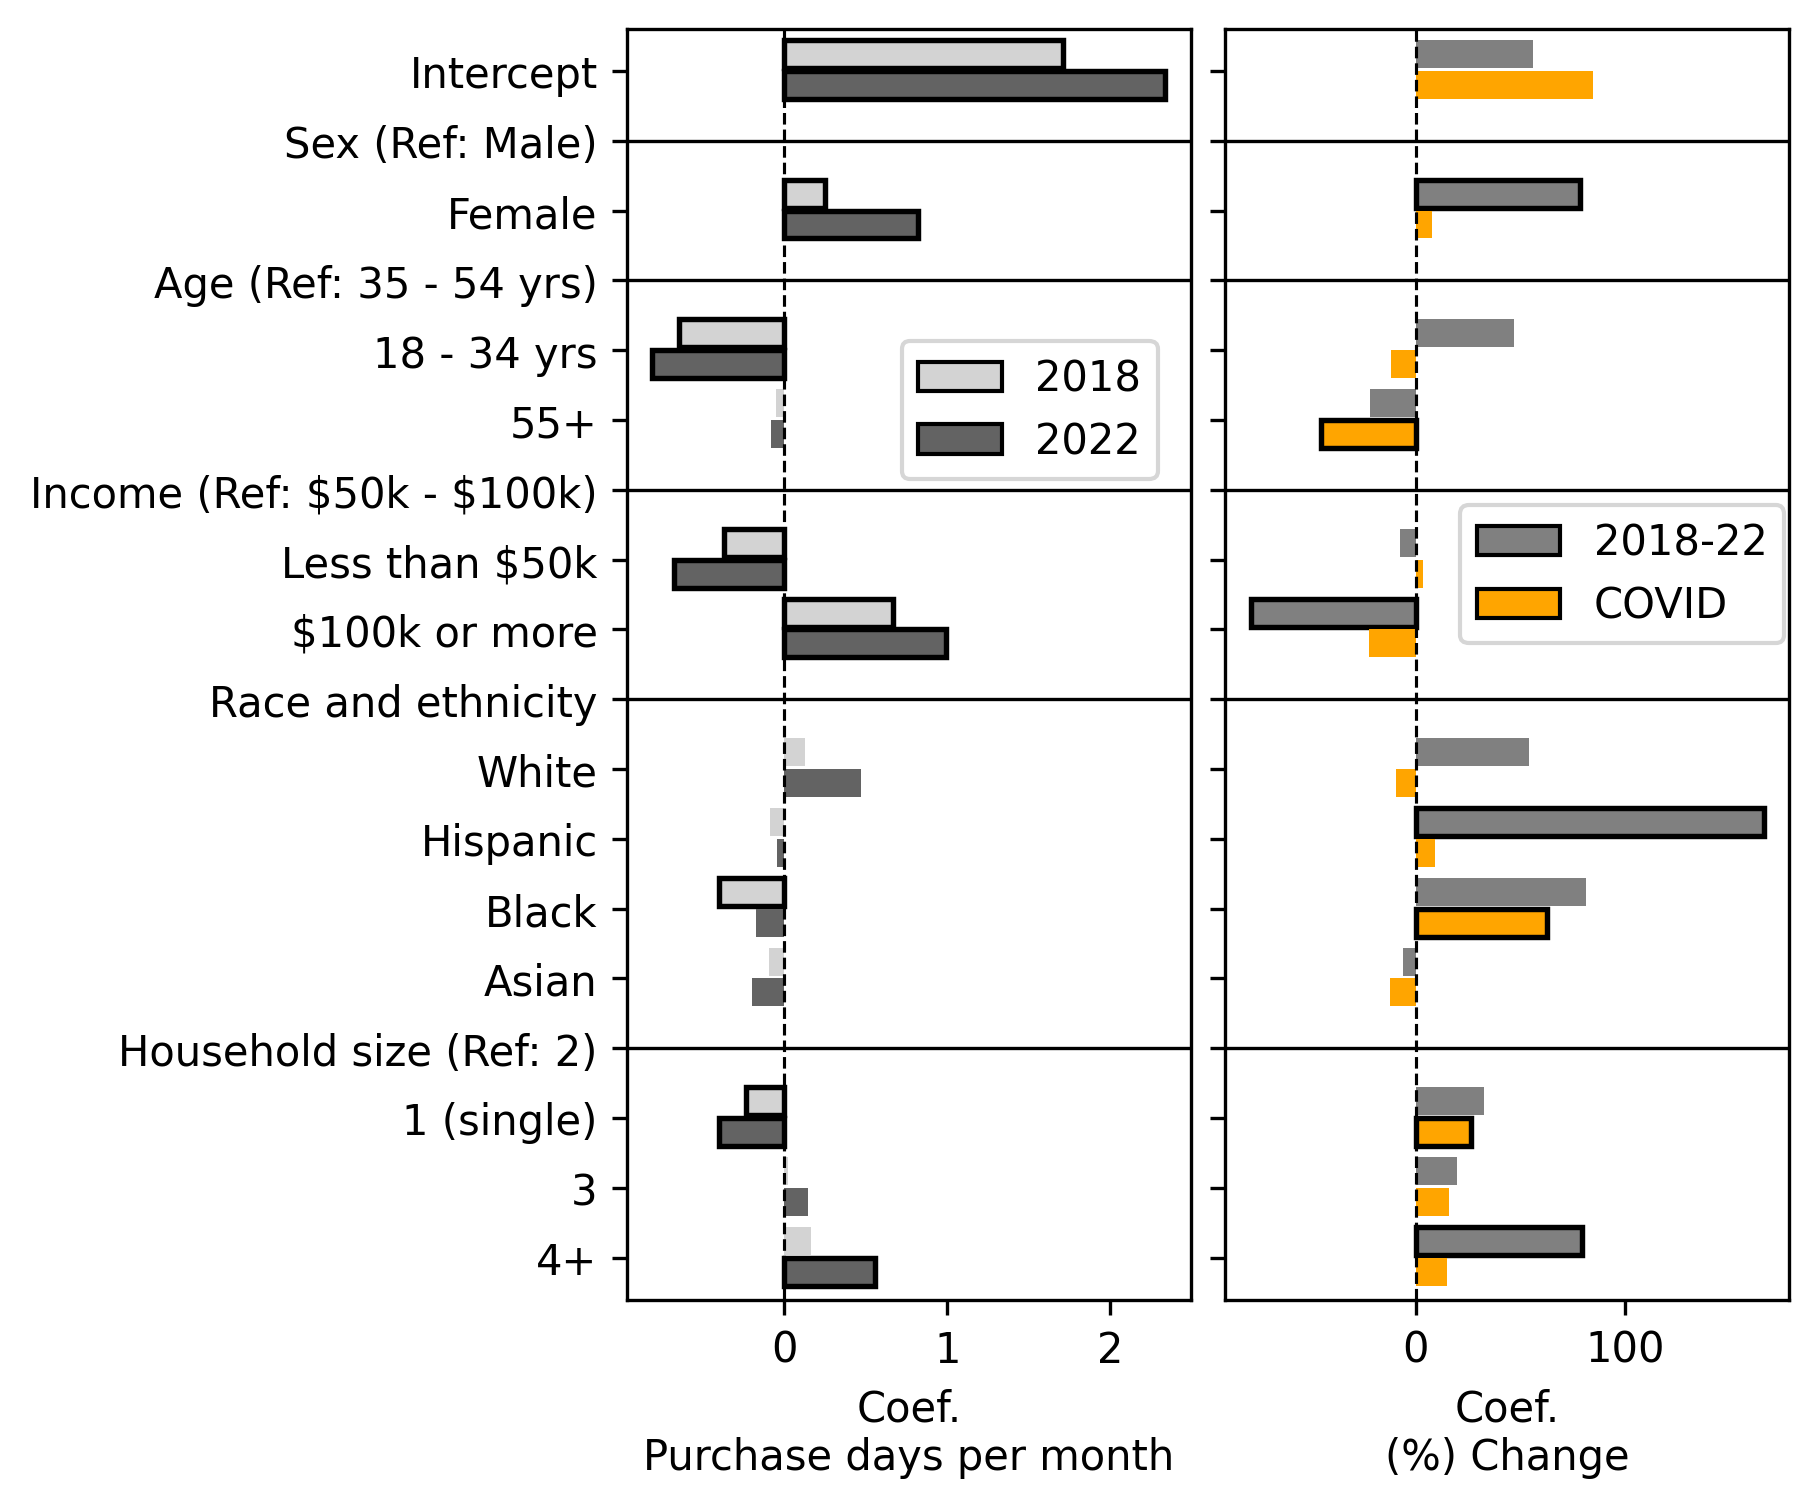

In [185]:
import matplotlib.patches as mpatches # for customizing legend
# colors
c_2018 = 'lightgray'
c_2022 = '#636363'
c_20182022 = 'gray'
c_covid = 'orange'
fig, axes = plt.subplots(1,2, figsize=(5, 5.5), sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.06)
res_tab = plt_freq_res_tab
index = np.arange(len(res_tab))
width = 0.4
axes[0].barh(index + width+0.04, res_tab['coef_2018'], width, align='edge',
        edgecolor='black',
        color=c_2018, 
        linewidth=[(1.3 if sig else 0) for sig in res_tab['*_2018']],
        label='2018')
axes[0].barh(index, res_tab['coef_2022'], width, align='edge', 
        color=c_2022,
        linewidth=[(1.3 if sig else 0) for sig in res_tab['*_2022']],
        edgecolor='black',
        label='2022')

axes[1].barh(index + width+0.04, plt_freq_chg_res_tab['coef_20182022'], width, 
             align='edge',
        edgecolor='black',
        color=c_20182022, 
        linewidth=[(1.3 if sig else 0) for sig in plt_freq_chg_res_tab['*_20182022']],
        label='2018 to 2022')
axes[1].barh(index, plt_freq_chg_res_tab['coef_covid'], width, 
             align='edge',
            edgecolor='black',
            color=c_covid, 
            linewidth=[(1.3 if sig else 0) for sig in plt_freq_chg_res_tab['*_covid']],
            label='COVID period')
axes[0].set(
    yticks=index + width, 
    yticklabels=res_tab.index, 
    ylim=[2*width - 1, len(res_tab)])
axes[0].set_xlabel('Coef.\nPurchase days per month')
axes[1].set_xlabel('Coef.\n(%) Change')
_ = axes[0].legend(handles=[
    mpatches.Patch(facecolor=c_2018, label='2018', edgecolor='black'),
    mpatches.Patch(facecolor=c_2022, label='2022', edgecolor='black')
],bbox_to_anchor=(0.45, 0.7))
_ = axes[1].legend(handles=[
    mpatches.Patch(facecolor=c_20182022, label='2018-22', edgecolor='black'),
    mpatches.Patch(facecolor=c_covid, label='COVID', edgecolor='black')],
                   bbox_to_anchor=(0.38, 0.5)
                  )
line_locs = [3, 8, 11, 14, 16]
for y in line_locs:
    axes[0].axhline(y=y+0.4, color='black', linewidth=0.8)
    axes[1].axhline(y=y+0.4, color='black', linewidth=0.8)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.75)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.75)
plt.show()

#### Formatted regression tables

column contains: 
```
coef** (SE)
```

Four separate OLS models were estimated, only differing in the dependent variable: (1) median monthly purchase days for 2018, (2) median monthly purchase days in 2022, (3) percent change in purchase days from 2018 to 2022, (3) percent change in purchase days from the year prior to COVID (2019-03 to 2020-02) to the period spanning the first year of COVID-19 (2020-03 to 2021-02).

In [218]:
res_table_formatted = pd.DataFrame({
    '(1)': get_res_table(freq_res2018)['formatted'],
    '(2)': get_res_table(freq_res2022)['formatted'],
    '(3)': get_res_table(freq_chg_20182022)['formatted'],
    '(4)': get_res_table(freq_chg_covid)['formatted'],
})
res_table_formatted.loc['N'] = [
    int(freq_res2018.nobs), int(freq_res2022.nobs), int(freq_chg_20182022.nobs), int(freq_chg_covid.nobs)
]
res_table_formatted.loc['R-squared'] = [
    round(freq_res2018.rsquared, 3), round(freq_res2022.rsquared, 3), 
    round(freq_chg_20182022.rsquared, 3), round(freq_chg_covid.rsquared, 3)
]

tab = res_table_formatted.rename(idx_map)
tab.loc['Sex (Ref: Male)'] = ['']*len(tab.columns)
tab.loc['Age (Ref: 35 - 54 yrs)'] = ['']*len(tab.columns)
tab.loc['Income (Ref: \$50k - \$100k)'] = ['']*len(tab.columns)
tab.loc['Race and ethnicity'] = ['']*len(tab.columns)
tab.loc['Household size (Ref: 2)'] = ['']*len(tab.columns)
tab = tab.loc[plt_idx + ['N','R-squared']]
tab

(1)                (2)   
Intercept                      1.710*** (0.346)   2.338*** (0.525)  \
Sex (Ref: Male)                                                      
Female                         0.250*** (0.071)   0.819*** (0.108)   
Age (Ref: 35 - 54 yrs)                                               
18 - 34 yrs                   -0.647*** (0.077)  -0.807*** (0.117)   
55+                              -0.049 (0.119)     -0.082 (0.181)   
Income (Ref: \$50k - \$100k)                                         
Less than $50k                -0.367*** (0.085)  -0.677*** (0.129)   
$100k or more                  0.665*** (0.091)   0.995*** (0.138)   
Race and ethnicity                                                   
White                             0.129 (0.162)      0.468 (0.246)   
Hispanic                         -0.089 (0.126)     -0.045 (0.191)   
Black                           -0.397* (0.179)     -0.170 (0.272)   
Asian                            -0.092 (0.179)     -0.200 (0.271)   
Household size (Ref: 2)                                              
1 (single)                      -0.232* (0.098)   -0.398** (0.149)   
3                                 0.026 (0.102)      0.145 (0.155)   
4+                                0.164 (0.097)   0.554*** (0.147)   
N                                          3961               3961   
R-squared                                 0.087              0.109   

                                              (3)                 (4)  
Intercept                        56.154 (128.563)     84.468 (47.150)  
Sex (Ref: Male)                                                        
Female                          78.612** (26.239)       7.628 (9.517)  
Age (Ref: 35 - 54 yrs)                                                 
18 - 34 yrs                       47.216 (28.652)    -11.636 (10.366)  
55+                              -21.914 (43.626)  -44.968** (15.930)  
Income (Ref: \$50k - \$100k)                                           
Less than $50k                    -7.296 (31.374)      3.402 (11.353)  
$100k or more                   -78.699* (33.417)    -22.133 (12.125)  
Race and ethnicity                                                     
White                             54.350 (60.959)     -9.470 (21.922)  
Hispanic                      166.143*** (46.673)      9.195 (17.001)  
Black                             81.351 (67.585)   62.943** (24.171)  
Asian                             -6.167 (67.155)    -12.318 (24.193)  
Household size (Ref: 2)                                                
1 (single)                        32.877 (36.079)    26.368* (13.090)  
3                                 20.017 (37.646)     16.108 (13.642)  
4+                               79.425* (35.760)     15.126 (12.938)  
N                                            3792                3862  
R-squared                                   0.023                0.02

### Totals: Make yearly metrics tables 

`total_spend`

`purchase_days`


`products`


```
responseIDd, 2018, 2019, 2020, 2021, 2022
```

In [124]:
def get_user_yr_spend(df, year, exclude_nov_dec=True, rids=rids):
    exclude_months = [11, 12] if exclude_nov_dec else []
    return (df[(df[YEAR]==year) & (~df[MONTH].isin(exclude_months))]
            .groupby(RESPONSE_ID)[TOTAL_SPEND].sum().reindex(rids))#.fillna(0))


def get_user_yr_purchase_days(df, year, exclude_nov_dec=True, rids=rids):
    """Returns the number of distinct days each user made a purchase (order dates)."""
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[(df[YEAR]==year) & (~df[MONTH].isin(exclude_months))]
            .groupby(RESPONSE_ID)[DATE].nunique().reindex(rids))#.fillna(0).astype(int))


def get_user_yr_products(df, year, exclude_nov_dec=True, rids=rids):
    """Returns the number of distinct categories purchased by each user in given year."""
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[(df[YEAR]==year) & (~df[MONTH].isin(exclude_months))]
            .groupby(RESPONSE_ID)[PRODUCT_CODE].nunique().reindex(rids))#.fillna(0).astype(int))

In [125]:
products = pd.DataFrame(
    {yr: get_user_yr_products(amzn_data, yr) for yr in years}
)
products.head(3)

2018  2019  2020   2021  2022
Survey ResponseID                               
R_1HjyB8kWn4gmwp5   1.0   7.0   4.0    8.0     3
R_3L51Lbe8dT8TJHD  30.0  44.0  19.0   24.0    51
R_3p8Rjor8VyZP2Qp  77.0  65.0  54.0  135.0   133

In [126]:
products.describe()

2018         2019         2020         2021         2022
count  3942.000000  3925.000000  3975.000000  4033.000000  4115.000000
mean     38.871892    44.577580    65.880000    74.281428    70.730498
std      50.111832    52.432559    76.522322    84.939552    82.829730
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       8.000000    11.000000    17.000000    21.000000    18.000000
50%      23.000000    27.000000    41.000000    48.000000    45.000000
75%      52.000000    59.000000    86.000000    98.000000    94.000000
max     717.000000   655.000000   841.000000  1064.000000  1269.000000

In [127]:
purchase_days = pd.DataFrame(
    {yr: get_user_yr_purchase_days(amzn_data, yr) for yr in years}
)
purchase_days.describe()

2018         2019         2020         2021         2022
count  3942.000000  3925.000000  3975.000000  4033.000000  4115.000000
mean     20.258498    23.987261    32.865660    36.949169    35.640826
std      22.446585    24.765461    32.527687    35.046718    34.385441
min       1.000000     1.000000     1.000000     1.000000     1.000000
25%       5.000000     7.000000     9.000000    11.000000    10.000000
50%      13.000000    16.000000    23.000000    27.000000    25.000000
75%      28.000000    33.000000    45.000000    50.000000    50.000000
max     218.000000   231.000000   238.000000   236.000000   239.000000

In [128]:
total_spend = pd.DataFrame(
    {yr: get_user_yr_spend(amzn_data, yr) for yr in years}
)
total_spend.describe()

2018          2019          2020          2021          2022
count   3942.000000   3925.000000   3975.000000   4033.000000   4115.000000
mean    1022.176773   1174.100910   1662.307580   1970.534902   1928.898566
std     1375.855881   1468.040754   1938.198533   2317.927373   2313.338308
min        0.100000      0.010000      2.760000      1.940000      2.460000
25%      170.627500    246.760000    406.580000    504.810000    477.185000
50%      561.575000    676.550000   1027.330000   1272.560000   1171.470000
75%     1346.337500   1525.930000   2184.735000   2587.320000   2572.050000
max    19064.870000  17390.460000  19224.620000  36324.430000  25895.950000

In [129]:
total_spend.head()

2018     2019     2020     2021     2022
Survey ResponseID                                             
R_1HjyB8kWn4gmwp5    14.99    57.70    85.33   138.94    45.77
R_3L51Lbe8dT8TJHD   232.17   486.27   242.83   298.21   852.31
R_3p8Rjor8VyZP2Qp  1444.44   989.97   944.15  2412.87  2402.48
R_22zUFw96HSXLvK9   276.90   412.87   532.68  1276.50   918.80
R_2pWPV1jAXWmFSlW  2176.51  1206.63  4059.75  4122.04  2847.23

## Side quest: Impact of Amazon prime days

use model to determine how prime days impacted monthly purchase days/products

In [225]:
metric = 'purchase_days'
data = panel_m[[
    'ResponseID', metric,'t', 
    'month', 'isPrimeMonth',
    'Sex', 'Age3', 'Income3'
]].dropna()
primeday_formula_str = '{metric} ~ t + C(month) + isPrimeMonth'
primeday_formula_str += (' + ' + formula_covariates_age_sex_inc_str)
primeday_formula = primeday_formula_str.format(metric=metric)
print(primeday_formula)
model = smf.ols(primeday_formula, data=data)
# Fit with SEs clustered at the responseID
primeday_purchase_days_res = model.fit(cov_type = 'cluster',cov_kwds={'groups': data['ResponseID']})
primeday_purchase_days_res.summary()

purchase_days ~ t + C(month) + isPrimeMonth + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          purchase_days   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     177.2
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:16:58   Log-Likelihood:            -6.1259e+05
No. Observations:              229738   AIC:                         1.225e+06
Df Residuals:                  229719   BIC:                         1.225e+06
Df Model:                          18                                         
Covariance Type:              cluster                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       2.0350      0.093     21.887      0.000       1.853       2.217
C(month)[T.02]                                                                 -0.4038      0.018    -22.805      0.000      -0.439      -0.369
C(month)[T.03]                                                                 -0.0830      0.020     -4.212      0.000      -0.122      -0.044
C(month)[T.04]                                                                 -0.1507      0.020     -7.501      0.000      -0.190      -0.111
C(month)[T.05]                                                                 -0.0547      0.020     -2.711      0.007      -0.094      -0.015
C(month)[T.06]                                                                 -0.1408      0.021     -6.828      0.000      -0.181      -0.100
C(month)[T.07]                                                                 -0.1248      0.024     -5.191      0.000      -0.172      -0.078
C(month)[T.08]                                                                 -0.0547      0.020     -2.676      0.007      -0.095      -0.015
C(month)[T.09]                                                                 -0.2995      0.020    -15.066      0.000      -0.338      -0.261
C(month)[T.10]                                                                 -0.1876      0.021     -8.993      0.000      -0.229      -0.147
C(month)[T.11]                                                                  0.1392      0.023      6.080      0.000       0.094       0.184
C(month)[T.12]                                                                  0.6235      0.024     26.223      0.000       0.577       0.670
isPrimeMonth[T.True]                                                            0.1713      0.019      9.219      0.000       0.135       0.208
C(Sex, Treatment(reference='Male'))[T.Female]                                   0.5863      0.083      7.082      0.000       0.424       0.749
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                 -0.8814      0.090     -9.778      0.000      -1.058      -0.705
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                  -0.2021      0.140     -1.445      0.149      -0.476       0.072
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]      0.9536      0.115      8.282      0.000       0.728       1.179
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]    -0.5812      0.089     -6.540      0.000      -0.755      -0.407
t                                                          

In [226]:
metric = 'products'
data = panel_m[[
    'ResponseID', metric,'t', 
    'month', 'isPrimeMonth',
    'Sex', 'Age3', 'Income3'
]].dropna()
primeday_formula_str = '{metric} ~ t + C(month) + isPrimeMonth'
primeday_formula_str += (' + ' + formula_covariates_age_sex_inc_str)

primeday_formula = primeday_formula_str.format(metric=metric)
print(primeday_formula)
model = smf.ols(primeday_formula, data=data)
# Fit with SEs clustered at the responseID
primeday_products_res = model.fit(cov_type = 'cluster', cov_kwds={'groups': data['ResponseID']})
primeday_products_res.summary()

products ~ t + C(month) + isPrimeMonth + C(Sex, Treatment(reference='Male')) + C(Age3, Treatment(reference='35 - 54 years')) + C(Income3, Treatment(reference='\$50,000 - \$99,999'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               products   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     126.2
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:17:10   Log-Likelihood:            -8.5106e+05
No. Observations:              229738   AIC:                         1.702e+06
Df Residuals:                  229719   BIC:                         1.702e+06
Df Model:                          18                                         
Covariance Type:              cluster                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       3.8324      0.229     16.711      0.000       3.383       4.282
C(month)[T.02]                                                                 -0.8084      0.057    -14.242      0.000      -0.920      -0.697
C(month)[T.03]                                                                  0.0194      0.069      0.282      0.778      -0.116       0.154
C(month)[T.04]                                                                 -0.2300      0.063     -3.674      0.000      -0.353      -0.107
C(month)[T.05]                                                                 -0.1365      0.063     -2.177      0.030      -0.259      -0.014
C(month)[T.06]                                                                 -0.2507      0.065     -3.864      0.000      -0.378      -0.124
C(month)[T.07]                                                                 -0.3040      0.079     -3.853      0.000      -0.459      -0.149
C(month)[T.08]                                                                 -0.0867      0.064     -1.362      0.173      -0.211       0.038
C(month)[T.09]                                                                 -0.7101      0.062    -11.540      0.000      -0.831      -0.590
C(month)[T.10]                                                                 -0.4589      0.067     -6.874      0.000      -0.590      -0.328
C(month)[T.11]                                                                  0.8614      0.076     11.275      0.000       0.712       1.011
C(month)[T.12]                                                                  2.1746      0.086     25.173      0.000       2.005       2.344
isPrimeMonth[T.True]                                                            0.7327      0.063     11.687      0.000       0.610       0.856
C(Sex, Treatment(reference='Male'))[T.Female]                                   1.8096      0.209      8.660      0.000       1.400       2.219
C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                 -2.1978      0.232     -9.473      0.000      -2.652      -1.743
C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]                  -0.9459      0.344     -2.747      0.006      -1.621      -0.271
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]      2.2399      0.292      7.672      0.000       1.668       2.812
C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]    -1.1959      0.225     -5.309      0.000      -1.637      -0.754
t                                                          

In [243]:
idx_map = {
    'Intercept': 'Intercept',
    'C(month)[T.02]': '2', 
    'C(month)[T.03]': '3', 
    'C(month)[T.04]': '4',
    'C(month)[T.05]': '5', 
    'C(month)[T.06]': '6', 
    'C(month)[T.07]': '7', 
    'C(month)[T.08]': '8',
    'C(month)[T.09]': '9', 
    'C(month)[T.10]': '10', 
    'C(month)[T.11]': '11', 
    'C(month)[T.12]': '12',
    'isPrimeMonth[T.True]': 'is Prime Day Month',
    "C(Sex, Treatment(reference='Male'))[T.Female]": 'Female',
    "C(Age3, Treatment(reference='35 - 54 years'))[T.18 - 34 years]": '18 - 34 yrs',
    "C(Age3, Treatment(reference='35 - 54 years'))[T.55 and older]": '55+',
    "C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.$100,000 or more]": '$100k or more',
    "C(Income3, Treatment(reference='\$50,000 - \$99,999'))[T.Less than $50,000]": 'Less than $50k',
}
plt_idx = [
    'Intercept',
    'Sex (Ref: Male)',
    'Female', 
    'Age (Ref: 35 - 54 yrs)', 
    '18 - 34 yrs', '55+', 
    'Income (Ref: \$50k - \$100k)', 
    'Less than $50k', 
    '$100k or more',
    'Month (Ref: 1)',
    '2', 
    '3',
    '4',
    '5',
    '6', 
    '7', 
    '8',
    '9',
    '10', 
    '11', 
    '12',
    't',
    'is Prime Day Month',
]
res_table_formatted = pd.DataFrame({
    'Monthly purchase days': get_res_table(primeday_purchase_days_res)['formatted'],
    'Monthly distinct products': get_res_table(primeday_products_res)['formatted'],
})
res_table_formatted.loc['N'] = [
    int(primeday_purchase_days_res.nobs), int(primeday_products_res.nobs),
]
res_table_formatted.loc['R-squared'] = [
    round(primeday_purchase_days_res.rsquared, 3), round(primeday_products_res.rsquared, 3), 
]
tab = res_table_formatted.rename(idx_map)
tab.loc['Sex (Ref: Male)'] = ['']*len(tab.columns)
tab.loc['Age (Ref: 35 - 54 yrs)'] = ['']*len(tab.columns)
tab.loc['Income (Ref: \$50k - \$100k)'] = ['']*len(tab.columns)
tab.loc['Month (Ref: 1)'] = ['']*len(tab.columns)
tab = tab.loc[plt_idx + ['N','R-squared']]
tab

Monthly purchase days Monthly distinct products
Intercept                         2.035*** (0.093)          3.832*** (0.229)
Sex (Ref: Male)                                                             
Female                            0.586*** (0.083)          1.810*** (0.209)
Age (Ref: 35 - 54 yrs)                                                      
18 - 34 yrs                      -0.881*** (0.090)         -2.198*** (0.232)
55+                                 -0.202 (0.140)          -0.946** (0.344)
Income (Ref: \$50k - \$100k)                                                
Less than $50k                   -0.581*** (0.089)         -1.196*** (0.225)
$100k or more                     0.954*** (0.115)          2.240*** (0.292)
Month (Ref: 1)                                                              
2                                -0.404*** (0.018)         -0.808*** (0.057)
3                                -0.083*** (0.020)             0.019 (0.069)
4                                -0.151*** (0.020)         -0.230*** (0.063)
5                                 -0.055** (0.020)           -0.136* (0.063)
6                                -0.141*** (0.021)         -0.251*** (0.065)
7                                -0.125*** (0.024)         -0.304*** (0.079)
8                                 -0.055** (0.020)            -0.087 (0.064)
9                                -0.299*** (0.020)         -0.710*** (0.062)
10                               -0.188*** (0.021)         -0.459*** (0.067)
11                                0.139*** (0.023)          0.861*** (0.076)
12                                0.624*** (0.024)          2.175*** (0.086)
t                                 0.039*** (0.001)          0.094*** (0.003)
is Prime Day Month                0.171*** (0.019)          0.733*** (0.063)
N                                           229738                    229738
R-squared                                    0.087                     0.067